In [1]:
from scipy import ndimage as ndi
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from pathlib import Path
import cv2
from PIL import Image
from skimage import io
from tqdm import tqdm
import torch as t
from torch.nn.modules.loss import BCELoss, BCEWithLogitsLoss
from torch.utils import data
from torchvision import transforms as tsf
import torchvision
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
from transforms import *
from models import *
from skimage.transform import resize
from skimage.morphology import label
from utils_and_losses import *
torch.manual_seed(1)
from sklearn.model_selection import train_test_split

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline
files_for_test = sorted(list(Path('../data/stage_1_test/').iterdir()))

In [2]:
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

def read_image(filepath, color_mode=cv2.IMREAD_COLOR, target_size=None):
    """Read an image from a file and resize it."""
    img = cv2.imread(filepath, color_mode)
    if target_size: 
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)
    return img
      
def read_mask(directory, target_size=None):
    """Read and resize masks contained in a given directory."""
    for i,filename in enumerate(next(os.walk(directory))[2]):
        mask_path = os.path.join(directory, filename)
        mask_tmp = read_image(mask_path, cv2.IMREAD_GRAYSCALE, target_size)
        if not i: mask = mask_tmp
        else: mask = np.maximum(mask, mask_tmp)
    return mask 

def get_contour(img):
    img_contour = np.zeros_like(img)
    _, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    cv2.drawContours(img_contour, contours, -1, (255, 255, 255), 2)
    return img_contour

def iou_t(target, pred):
    target_y = label(target > 0.5)
    pred_y = label(pred > 0.5)
    true_objs = len(np.unique(target_y))
    pred_objs = len(np.unique(pred_y))
    intersection = np.histogram2d(target_y.flatten(),
                                pred_y.flatten(),
                                bins=(true_objs, pred_objs))[0]
  
    area_true = np.histogram(target_y, bins = true_objs)[0]
    area_pred = np.histogram(pred_y, bins = pred_objs)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
  
    union = area_true + area_pred - intersection
  
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union
  
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)
  
def get_center(img):
    img_center = np.zeros_like(img)
    y, x = ndi.measurements.center_of_mass(img)
    cv2.circle(img_center, (int(x), int(y)), 3, (255, 255, 255), -1)
    return img_center

TRAIN_DIR = '../data/stage1_train/'

train_ids = os.listdir(TRAIN_DIR)
train_images = [os.path.join(TRAIN_DIR, train_id, 'images', train_id + '.png') 
                for train_id in train_ids]
train_masks = {train_id: [os.path.join(TRAIN_DIR, train_id, 'masks', img_name) 
                          for img_name in os.listdir(os.path.join(TRAIN_DIR, train_id, 'masks'))]
               for train_id in train_ids}

TEST_DIR = '../data/stage_1_test/'
test_ids = os.listdir(TEST_DIR)
test_images = [os.path.join(TEST_DIR, test_id, 'images', test_id + '.png') 
                for test_id in test_ids]

In [3]:
class Dataset():
    def __init__(self, root_dir, img_id, transform=None, train=True):
        self.root_dir = root_dir
        self.img_id = img_id
        self.transform = transform
        self.train = train
        self.images = [os.path.join(root_dir, train_id, 'images', train_id + '.png') for train_id in img_id]
        if train:
            self.train_masks = {train_id: [os.path.join(root_dir, train_id, 'masks', img_name) for img_name in os.listdir(os.path.join(root_dir, train_id, 'masks'))] for train_id in img_id}
    
    def __getitem__(self, idx):
        if self.train:
            img_dir = os.path.join(TRAIN_DIR, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            img = cv2.imread(img_dir)
            masks = [cv2.imread(train_mask)[..., 0] for train_mask in self.train_masks[self.img_id[idx]]]
            mask = sum(masks) #FOR STAS: Here is a mask reading and center+contour extraction
            centers = []
            for m in masks:
                centers.append(get_center(m))#works only for single mask file(not for the sum of masks)
            mask_center = sum(centers)
            mask_contour = get_contour(mask) #works for sum of masks(but may be better for single mask file, need tests)
            
            mask_contour = np.expand_dims(mask_contour, -1)
            mask_center = np.expand_dims(mask_center, -1)
            mask = np.expand_dims(mask, -1)
            
            mask[mask > 0.00001] = 255
            # print(img.shape, mask.shape, mask_center.shape, mask_contour.shape)
            img, mask, mask_center, mask_contour = self.transform(img, mask, mask_center, mask_contour)
            img[:,:,0], img[:,:,2] = img[:,:,2], img[:,:,0] #return_to_RGB
            # print(img.shape, mask.shape, mask_center.shape, mask_contour.shape)
            
            
            mask = np.swapaxes(mask, 2, 0) / 255.0
            img = np.swapaxes(img, 2, 0) / 255.0
            mask_contour = np.swapaxes(mask_contour, 2, 0) / 255.0
            mask_center = np.swapaxes(mask_center, 2, 0) / 255.0
            
            # print(img.shape, mask.shape, mask_center.shape, mask_contour.shape)
            
            
            # sample = torch.FloatTensor(np.stack((img[0], img[1], img[2], mask[0], mask_center[0], mask_contour[0])))
            return torch.FloatTensor(np.stack((img[0], img[1], img[2]))) , torch.FloatTensor(np.stack((mask[0], mask_center[0], mask_contour[0])))
            
          
        else:
            img_dir = os.path.join(self.root_dir, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            img = cv2.imread(img_dir)
            shape = img.shape
            # print(shape)
            img = self.transform(img)
            img[:,:,0], img[:,:,2] = img[:,:,2], img[:,:,0] #return_to_RGB
            img = np.swapaxes(img, 2, 0) / 255.0
            # print(img.shape)
            #sample = torch.FloatTensor(np.stack((img[0], img[1], img[2]))) # probably big crutch
            return torch.FloatTensor(np.stack((img[0], img[1], img[2])))
        # return sample
        
    def __len__(self):
        return len(self.img_id)

In [4]:
train_transform = DanillCompose([
        DanillTransform(UnetTansformation(),instruction=(True, True, True, True)),
        RandomCrop4(prob=0),#prob = 0 - 100%, 
        ShiftScaleRotate4(),
        HorizontalFlip4(),
        VerticalFlip4(),
        DanillTransform(RandomHueSaturationValue(), instruction=(True, False, False, False)),
        DanillTransform(RandomBrightness(limit=0.1), instruction=(True, False, False, False)),
        DanillTransform(RandomContrast(limit=0.1), instruction=(True, False, False, False)),
        DanillTransform(Normalize(),instruction=(True, False, False, False),prob=0.5),
        Reshape4()
    ])

val_transform = DanillCompose([
    DanillTransform(UnetTansformation(),instruction=(True, True, True, True)),
    RandomCrop4(prob = 0),#prob=0.5),
    DanillTransform(RandomHueSaturationValue(), instruction=(True, False, False, False)),
    DanillTransform(RandomBrightness(limit=0.1), instruction=(True, False, False, False)),
    DanillTransform(RandomContrast(limit=0.1), instruction=(True, False, False, False)),
    DanillTransform(Normalize(),instruction=(True, False, False, False),prob=0.5),
    Reshape4()
])

In [5]:
training_ids, valid_ids = train_test_split(train_ids, shuffle = True, train_size=0.8)

train_dataset = Dataset(TRAIN_DIR, training_ids, transform=train_transform)
valid_dataset = Dataset(TRAIN_DIR, valid_ids   , transform=val_transform)

trainloader = t.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 16)
validloader = t.utils.data.DataLoader(valid_dataset, batch_size = 100, shuffle = True, num_workers = 16)

/media/stas/fastdata/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CPU times: user 101 ms, sys: 523 µs, total: 101 ms
Wall time: 99.3 ms


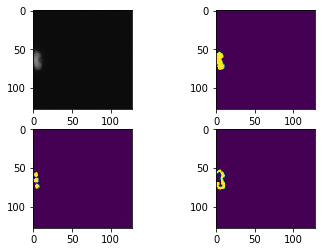

In [6]:
%%time
x, y = train_dataset[32]
img, mask, mask_center, mask_contour = x[[0,1,2]].permute(1,2,0).numpy(), y[0].numpy(), y[1].numpy(), y[2].numpy()

if img.min() < 0:
    img = img * .5 + .5

plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(mask)
plt.subplot(223)
plt.imshow(mask_center)
plt.subplot(224)
plt.imshow(mask_contour)

In [7]:
model = AlbuNet(pretrained=True, num_classes=3).cuda()
optimizer = t.optim.Adam(model.parameters(),lr = 1e-3)
# loss_bin = LossBinary()

In [8]:
loss_array = []
minimalochka = 100
early_stop = 10
i_will_wait = 0
ious = []

for epoch in tqdm(range(100)):
    model.train()
    for x_train, y_train  in trainloader:
        ls = []
        #print(sample.shape)
        x = t.autograd.Variable(x_train.cuda())
        y = t.autograd.Variable(y_train.cuda())
        optimizer.zero_grad()
        o = model(x)
        loss = LossBinary()
        loss = loss(o, y)
        loss.backward()
        optimizer.step()
        
        ls.append(loss.data[0])
    
    loss_array.append(np.mean(ls))
    model.eval()
    iou = []
    for x_train, y_train  in validloader:#valid
        ls = []
        x = t.autograd.Variable(x_train.cuda())
        y = t.autograd.Variable(y_train.cuda())
        
        o = model(x)
        # o = o - o.min()
        # o = o / o.max()
        for i in range(len(o)):
            q = iou_t(y[i][0].data.cpu().numpy(), o[i][0].data.cpu().numpy())
            if q <=0.000001:
                iou.append(0)
            else:
                iou.append(q)
            
    ious.append(np.mean(np.array(iou,dtype=np.float64)))
    
    
    if loss_array[-1] < minimalochka:
        minimalochka = loss_array[-1]
        i_will_wait = 0
        #print(epoch + 1,loss_array[-1],end="")
        torch.save(model, "cool_model_which_can_work.torch")
    if i_will_wait > (early_stop-1):
        print(epoch + 1)
        break
        
    i_will_wait += 1

 35%|███▌      | 35/100 [20:24<37:54, 35.00s/it]

36


In [12]:
iou_t(y[0][0].data.cpu().numpy(), 1-i)

AttributeError: 'bool' object has no attribute 'shape'

In [17]:
masks = o[0][0].data.cpu().numpy()

In [19]:
masks = masks - masks.min()
masks = masks / masks.max()

In [20]:
masks

array([[0.3341585 , 0.29589388, 0.2832498 , ..., 0.34149012, 0.35537493,
        0.3747782 ],
       [0.34721035, 0.31616002, 0.29727268, ..., 0.3311793 , 0.339567  ,
        0.35003838],
       [0.37548357, 0.3485078 , 0.30896625, ..., 0.33555782, 0.35329857,
        0.35829937],
       ...,
       [0.42910722, 0.44137108, 0.46695584, ..., 0.23504998, 0.24359334,
        0.264925  ],
       [0.42972714, 0.4372722 , 0.47421592, ..., 0.24153839, 0.23744857,
        0.26550314],
       [0.42161274, 0.43412086, 0.46112075, ..., 0.2516205 , 0.25153673,
        0.29759964]], dtype=float32)

In [29]:
valid_dataset[0][0]


( 0 ,.,.) = 
 -0.8275 -0.8353 -0.8353  ...  -0.8118 -0.8039 -0.8039
 -0.8353 -0.8353 -0.8353  ...  -0.8039 -0.7961 -0.7961
 -0.8588 -0.8510 -0.8431  ...  -0.7882 -0.7882 -0.7961
           ...             ⋱             ...          
 -0.9608 -0.9608 -0.9608  ...  -0.9451 -0.9451 -0.9451
 -0.9608 -0.9529 -0.9608  ...  -0.9529 -0.9529 -0.9529
 -0.9843 -0.9843 -0.9843  ...  -0.9843 -0.9843 -0.9843

( 1 ,.,.) = 
 -0.8353 -0.8431 -0.8431  ...  -0.8118 -0.8118 -0.8118
 -0.8431 -0.8431 -0.8431  ...  -0.8118 -0.8118 -0.8118
 -0.8667 -0.8588 -0.8510  ...  -0.8039 -0.8039 -0.8118
           ...             ⋱             ...          
 -0.9608 -0.9608 -0.9608  ...  -0.9451 -0.9451 -0.9451
 -0.9608 -0.9529 -0.9608  ...  -0.9529 -0.9529 -0.9529
 -0.9843 -0.9843 -0.9843  ...  -0.9843 -0.9843 -0.9843

( 2 ,.,.) = 
 -0.8275 -0.8353 -0.8353  ...  -0.8118 -0.8039 -0.8039
 -0.8353 -0.8353 -0.8353  ...  -0.8039 -0.7961 -0.7961
 -0.8588 -0.8510 -0.8431  ...  -0.7882 -0.7882 -0.7961
           ...         

In [42]:
x[0][[0,1,2]].data.permute(1,2,0).cpu().numpy()*0.5+0.5

array([[[0.06274509, 0.06274509, 0.06274509],
        [0.06666666, 0.06666666, 0.06666666],
        [0.05490196, 0.05490196, 0.05490196],
        ...,
        [0.05098039, 0.05098039, 0.05098039],
        [0.05098039, 0.05098039, 0.05098039],
        [0.05098039, 0.05098039, 0.05098039]],

       [[0.05882353, 0.05882353, 0.05882353],
        [0.05490196, 0.05490196, 0.05490196],
        [0.06274509, 0.06274509, 0.06274509],
        ...,
        [0.04705882, 0.04705882, 0.04705882],
        [0.05098039, 0.05098039, 0.05098039],
        [0.05490196, 0.05490196, 0.05490196]],

       [[0.05882353, 0.05882353, 0.05882353],
        [0.05490196, 0.05490196, 0.05490196],
        [0.06274509, 0.06274509, 0.06274509],
        ...,
        [0.05098039, 0.05098039, 0.05098039],
        [0.05490196, 0.05490196, 0.05490196],
        [0.05098039, 0.05098039, 0.05098039]],

       ...,

       [[0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353],
        [0.07058823, 0

In [62]:
center

array([[ -5.083233 ,  -8.881042 , -10.002464 , ...,  -3.929336 ,
         -3.4876916,  -2.3957944],
       [ -6.4660773, -10.7937765,  -9.846887 , ...,  -4.152679 ,
         -3.8141365,  -3.179066 ],
       [ -6.8304095,  -9.512293 ,  -8.003698 , ...,  -4.0376463,
         -4.247247 ,  -3.8712838],
       ...,
       [ -6.781831 ,  -7.8708706,  -6.113093 , ...,  -6.314045 ,
         -5.982918 ,  -6.6783237],
       [ -6.078066 ,  -7.604755 ,  -6.2259507, ...,  -6.5213437,
         -6.518213 ,  -6.7588296],
       [ -3.9297514,  -5.5357466,  -5.0646076, ...,  -5.6072254,
         -5.872263 ,  -5.1908307]], dtype=float32)

/media/stas/fastdata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


CPU times: user 5.67 s, sys: 682 ms, total: 6.35 s
Wall time: 5.53 s


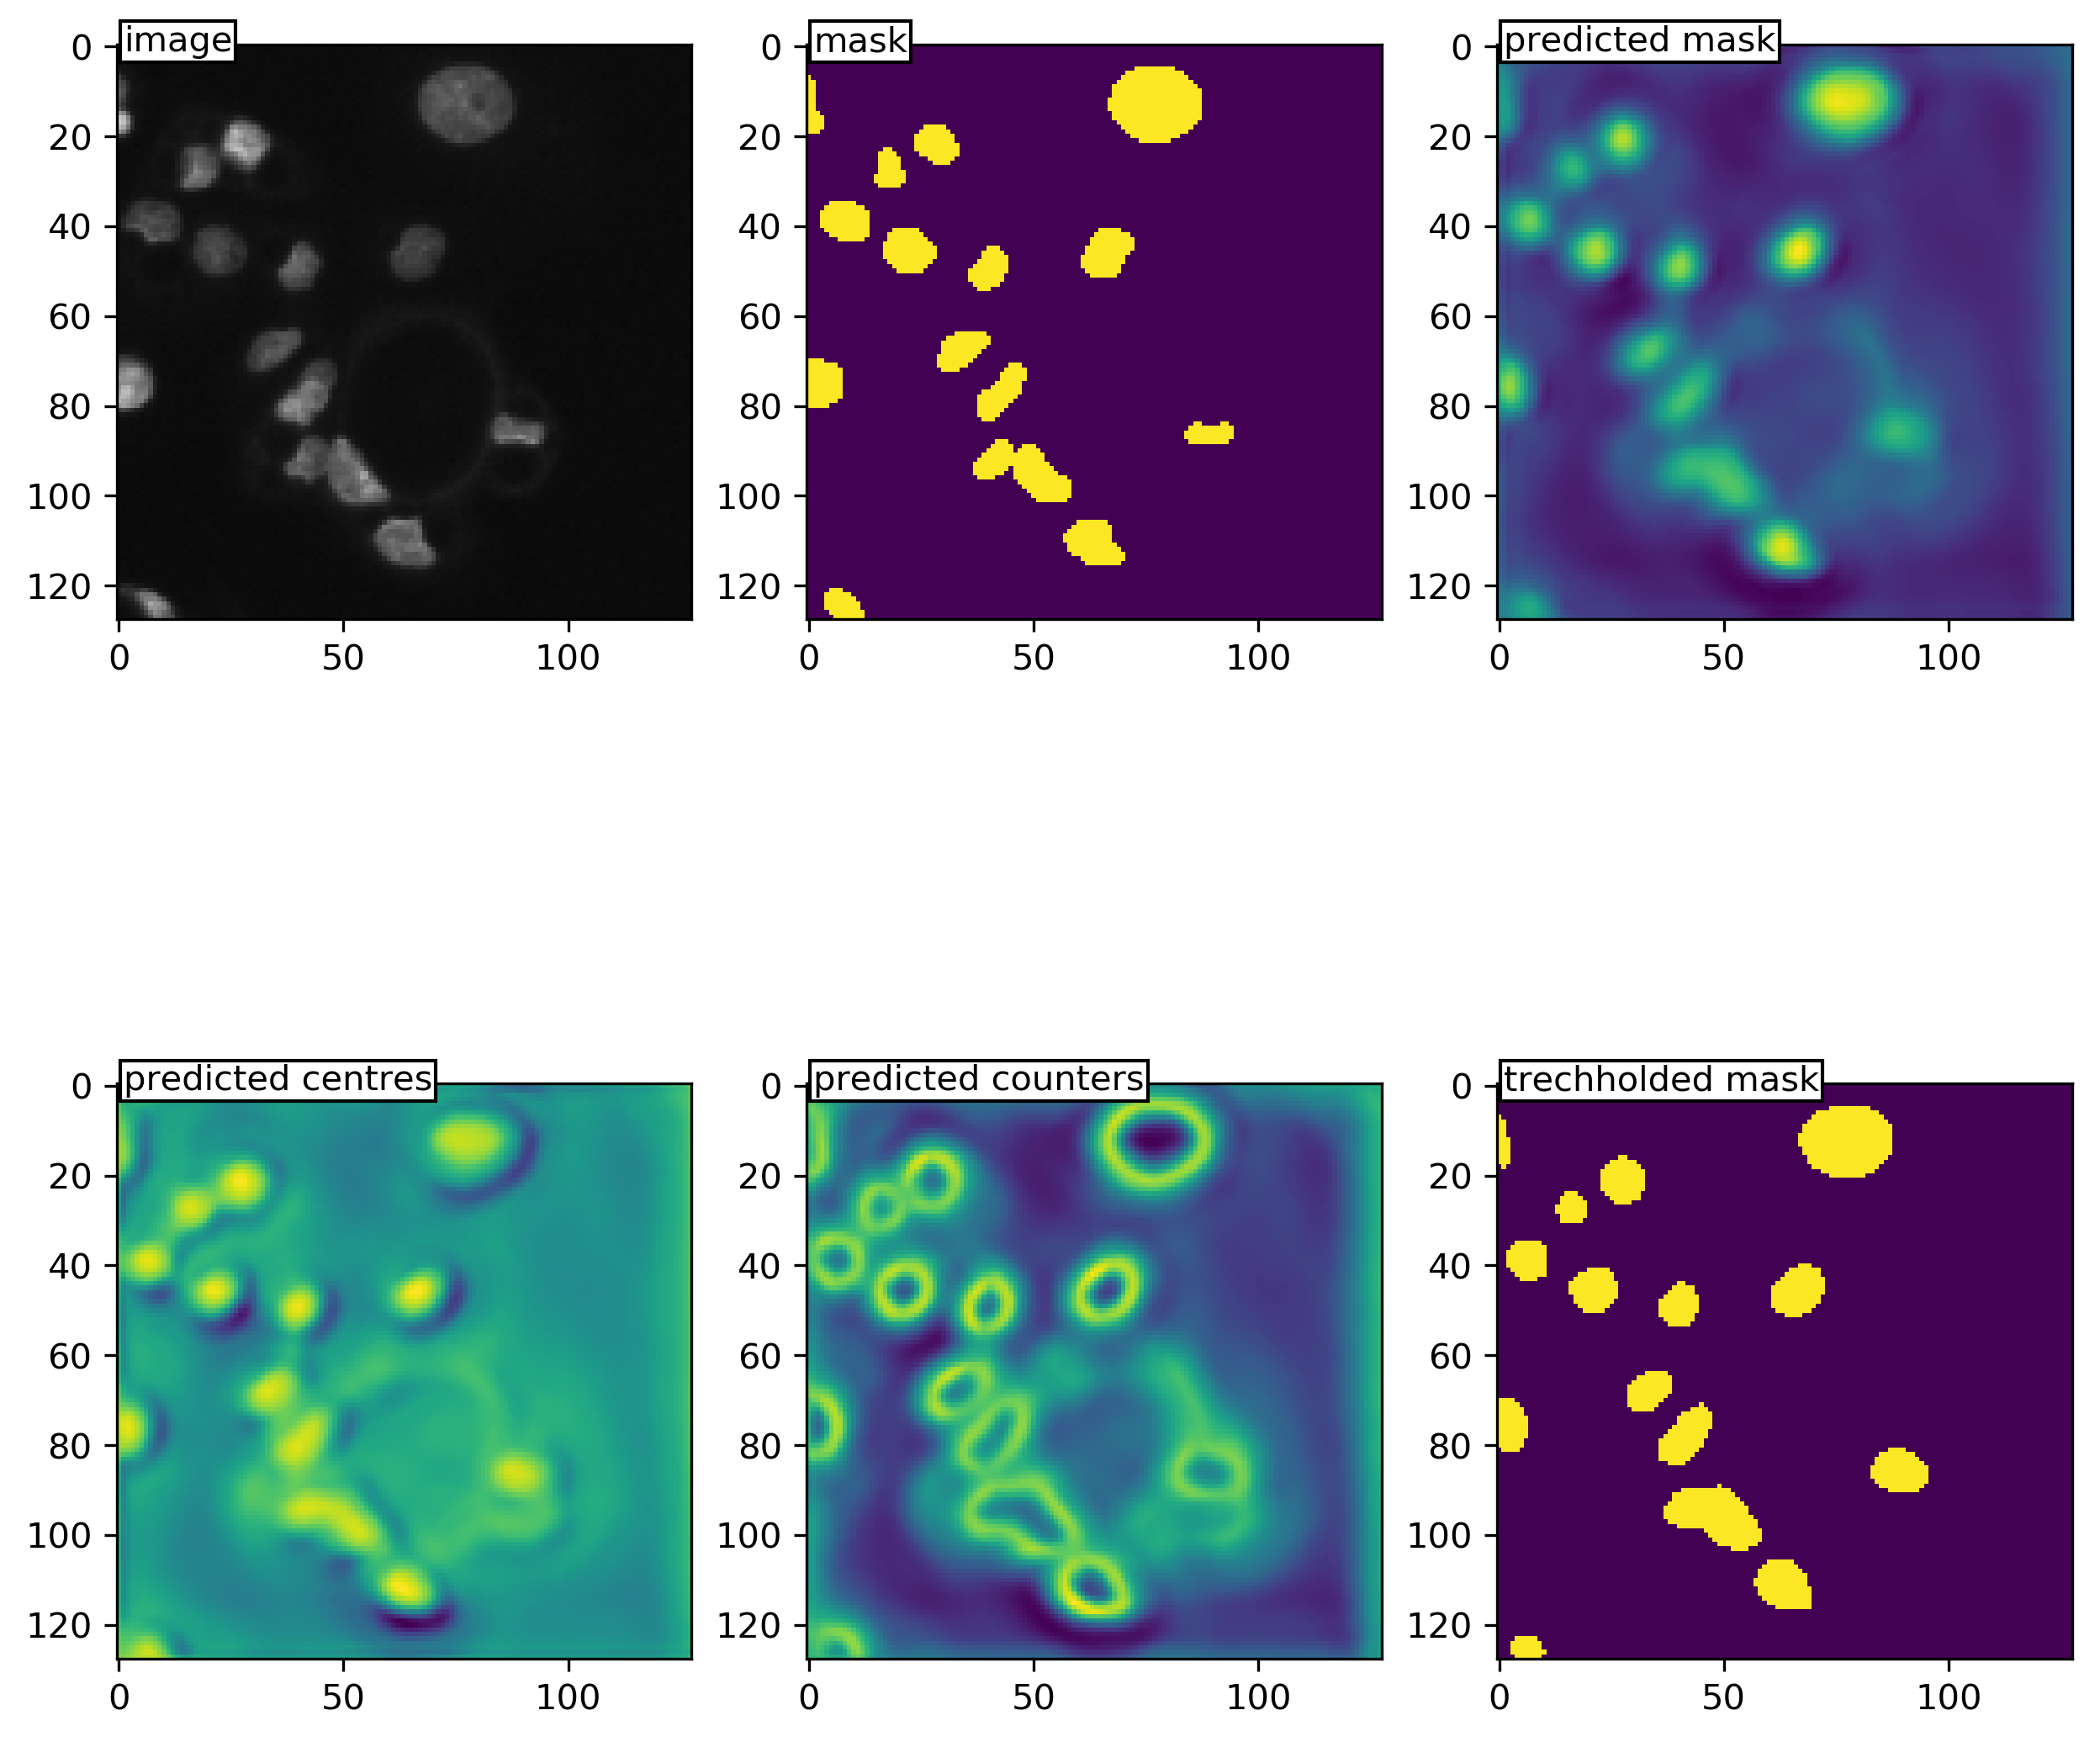

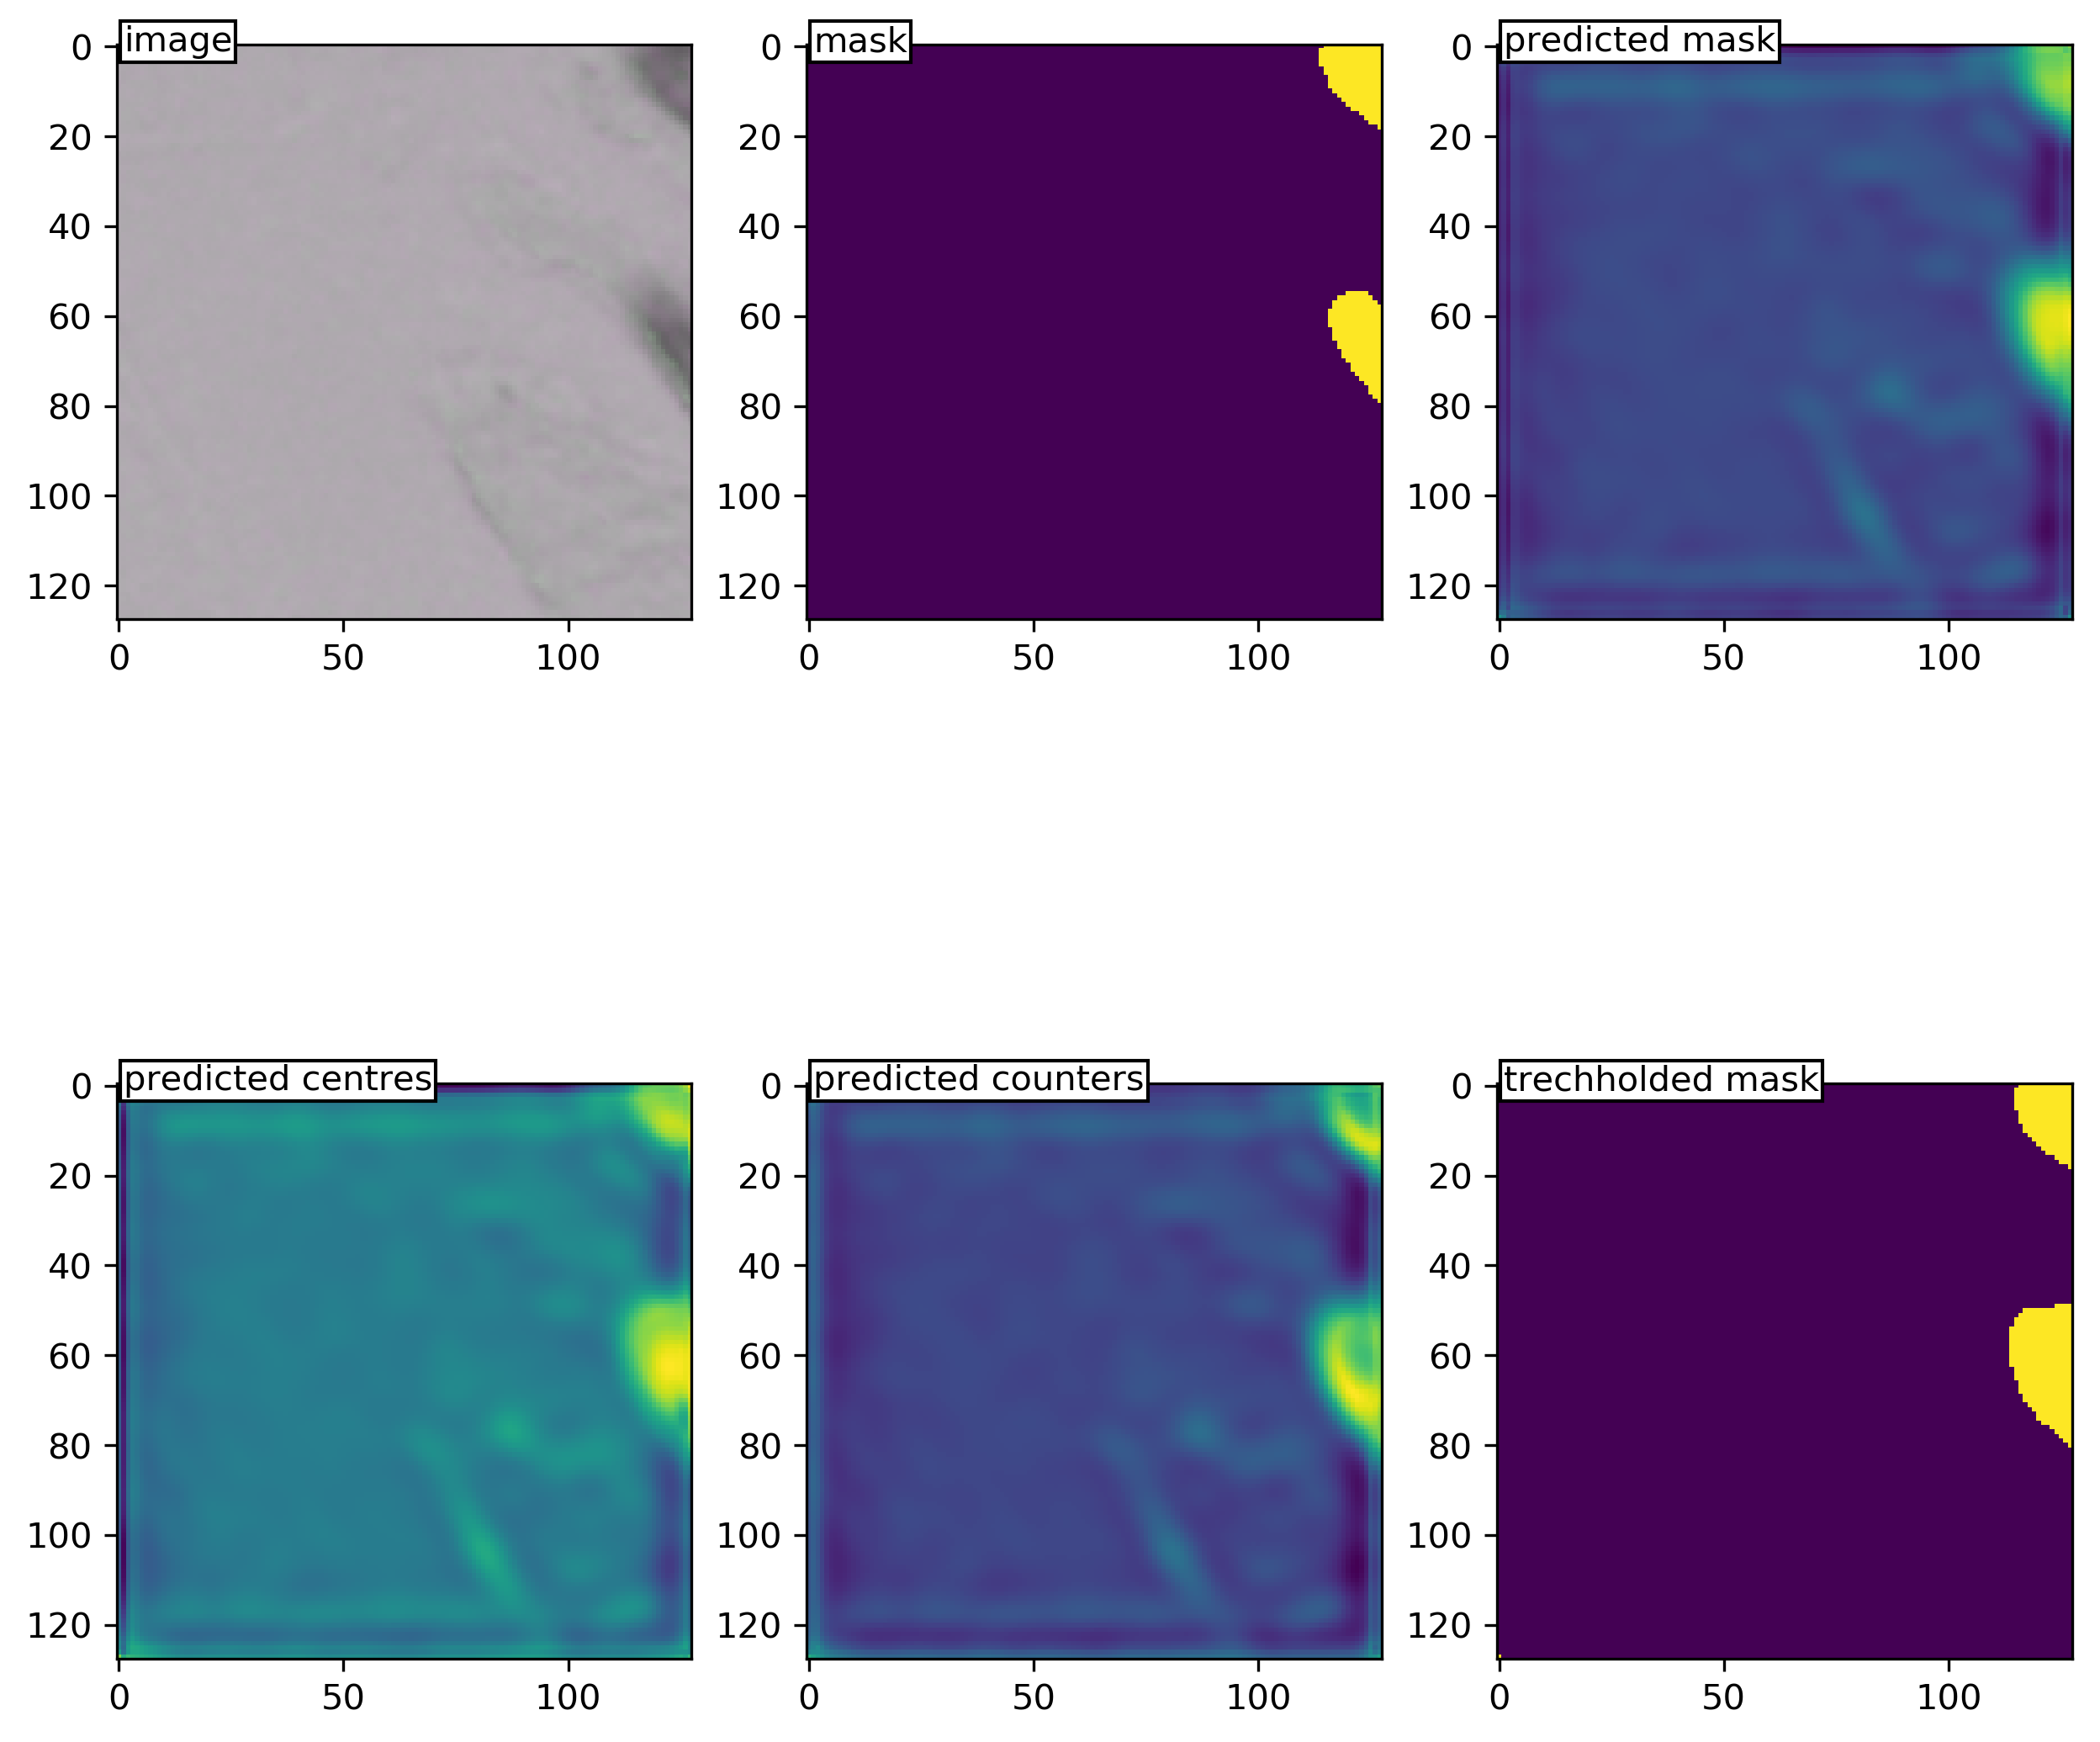

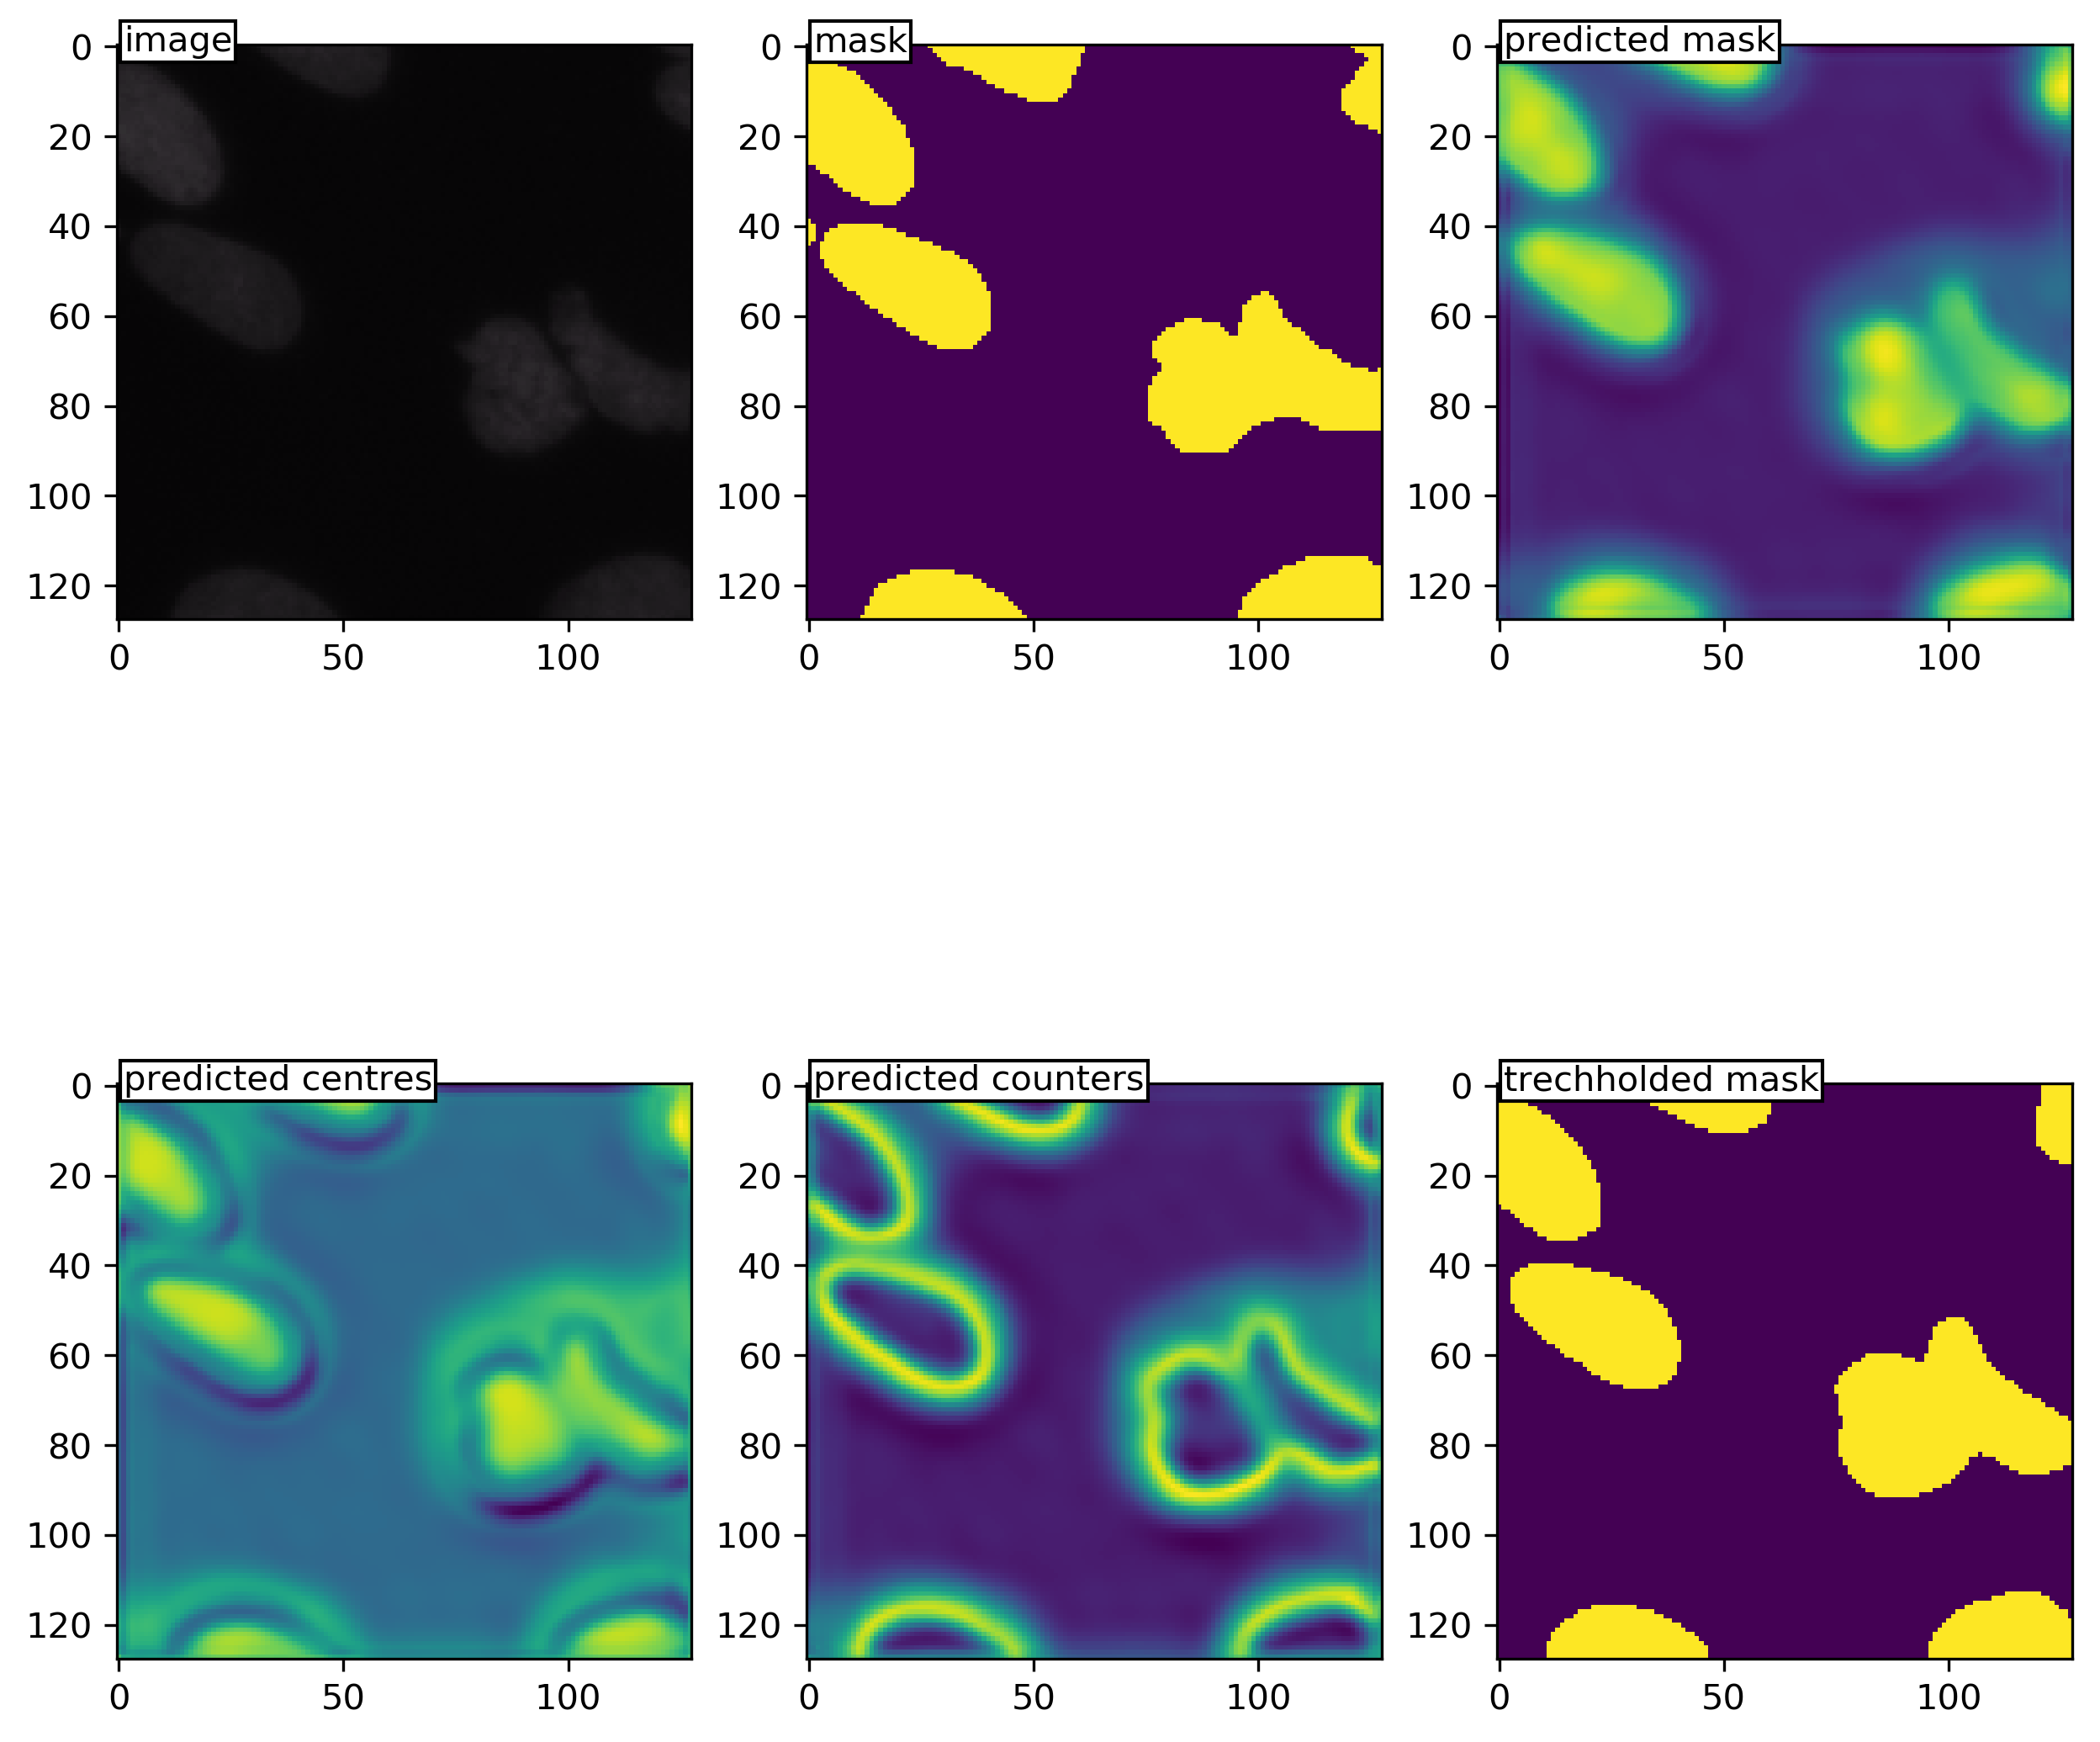

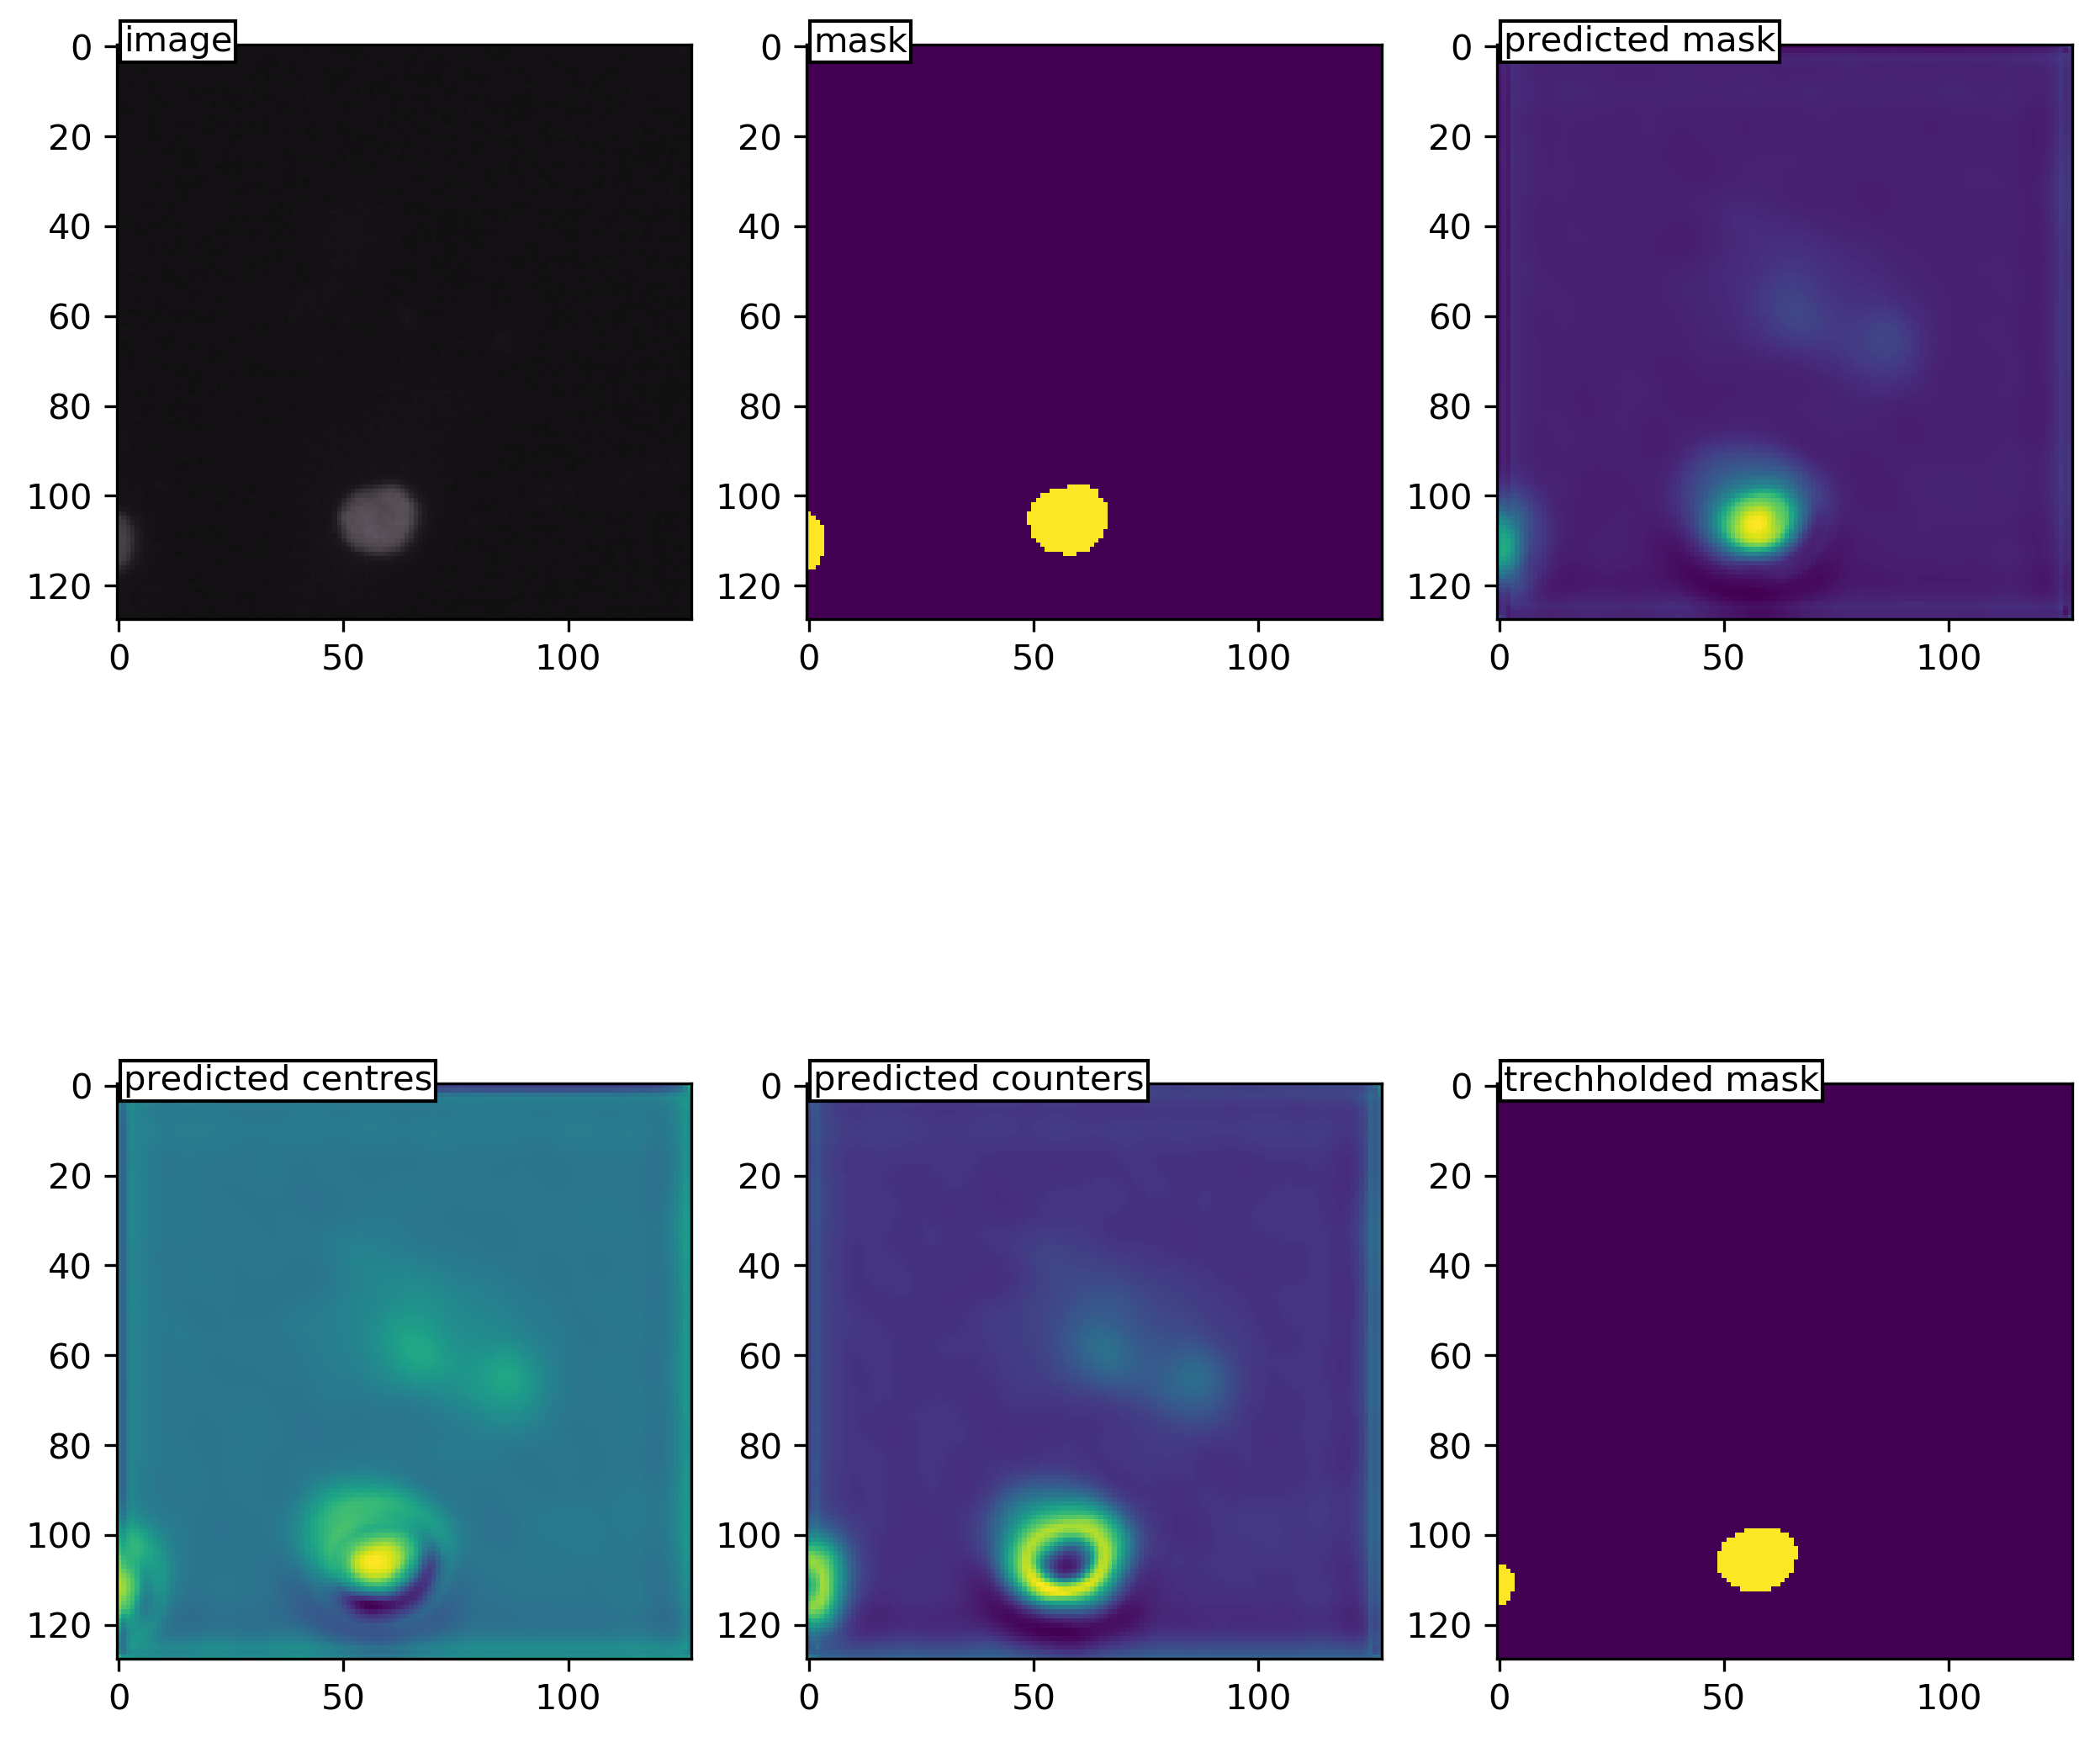

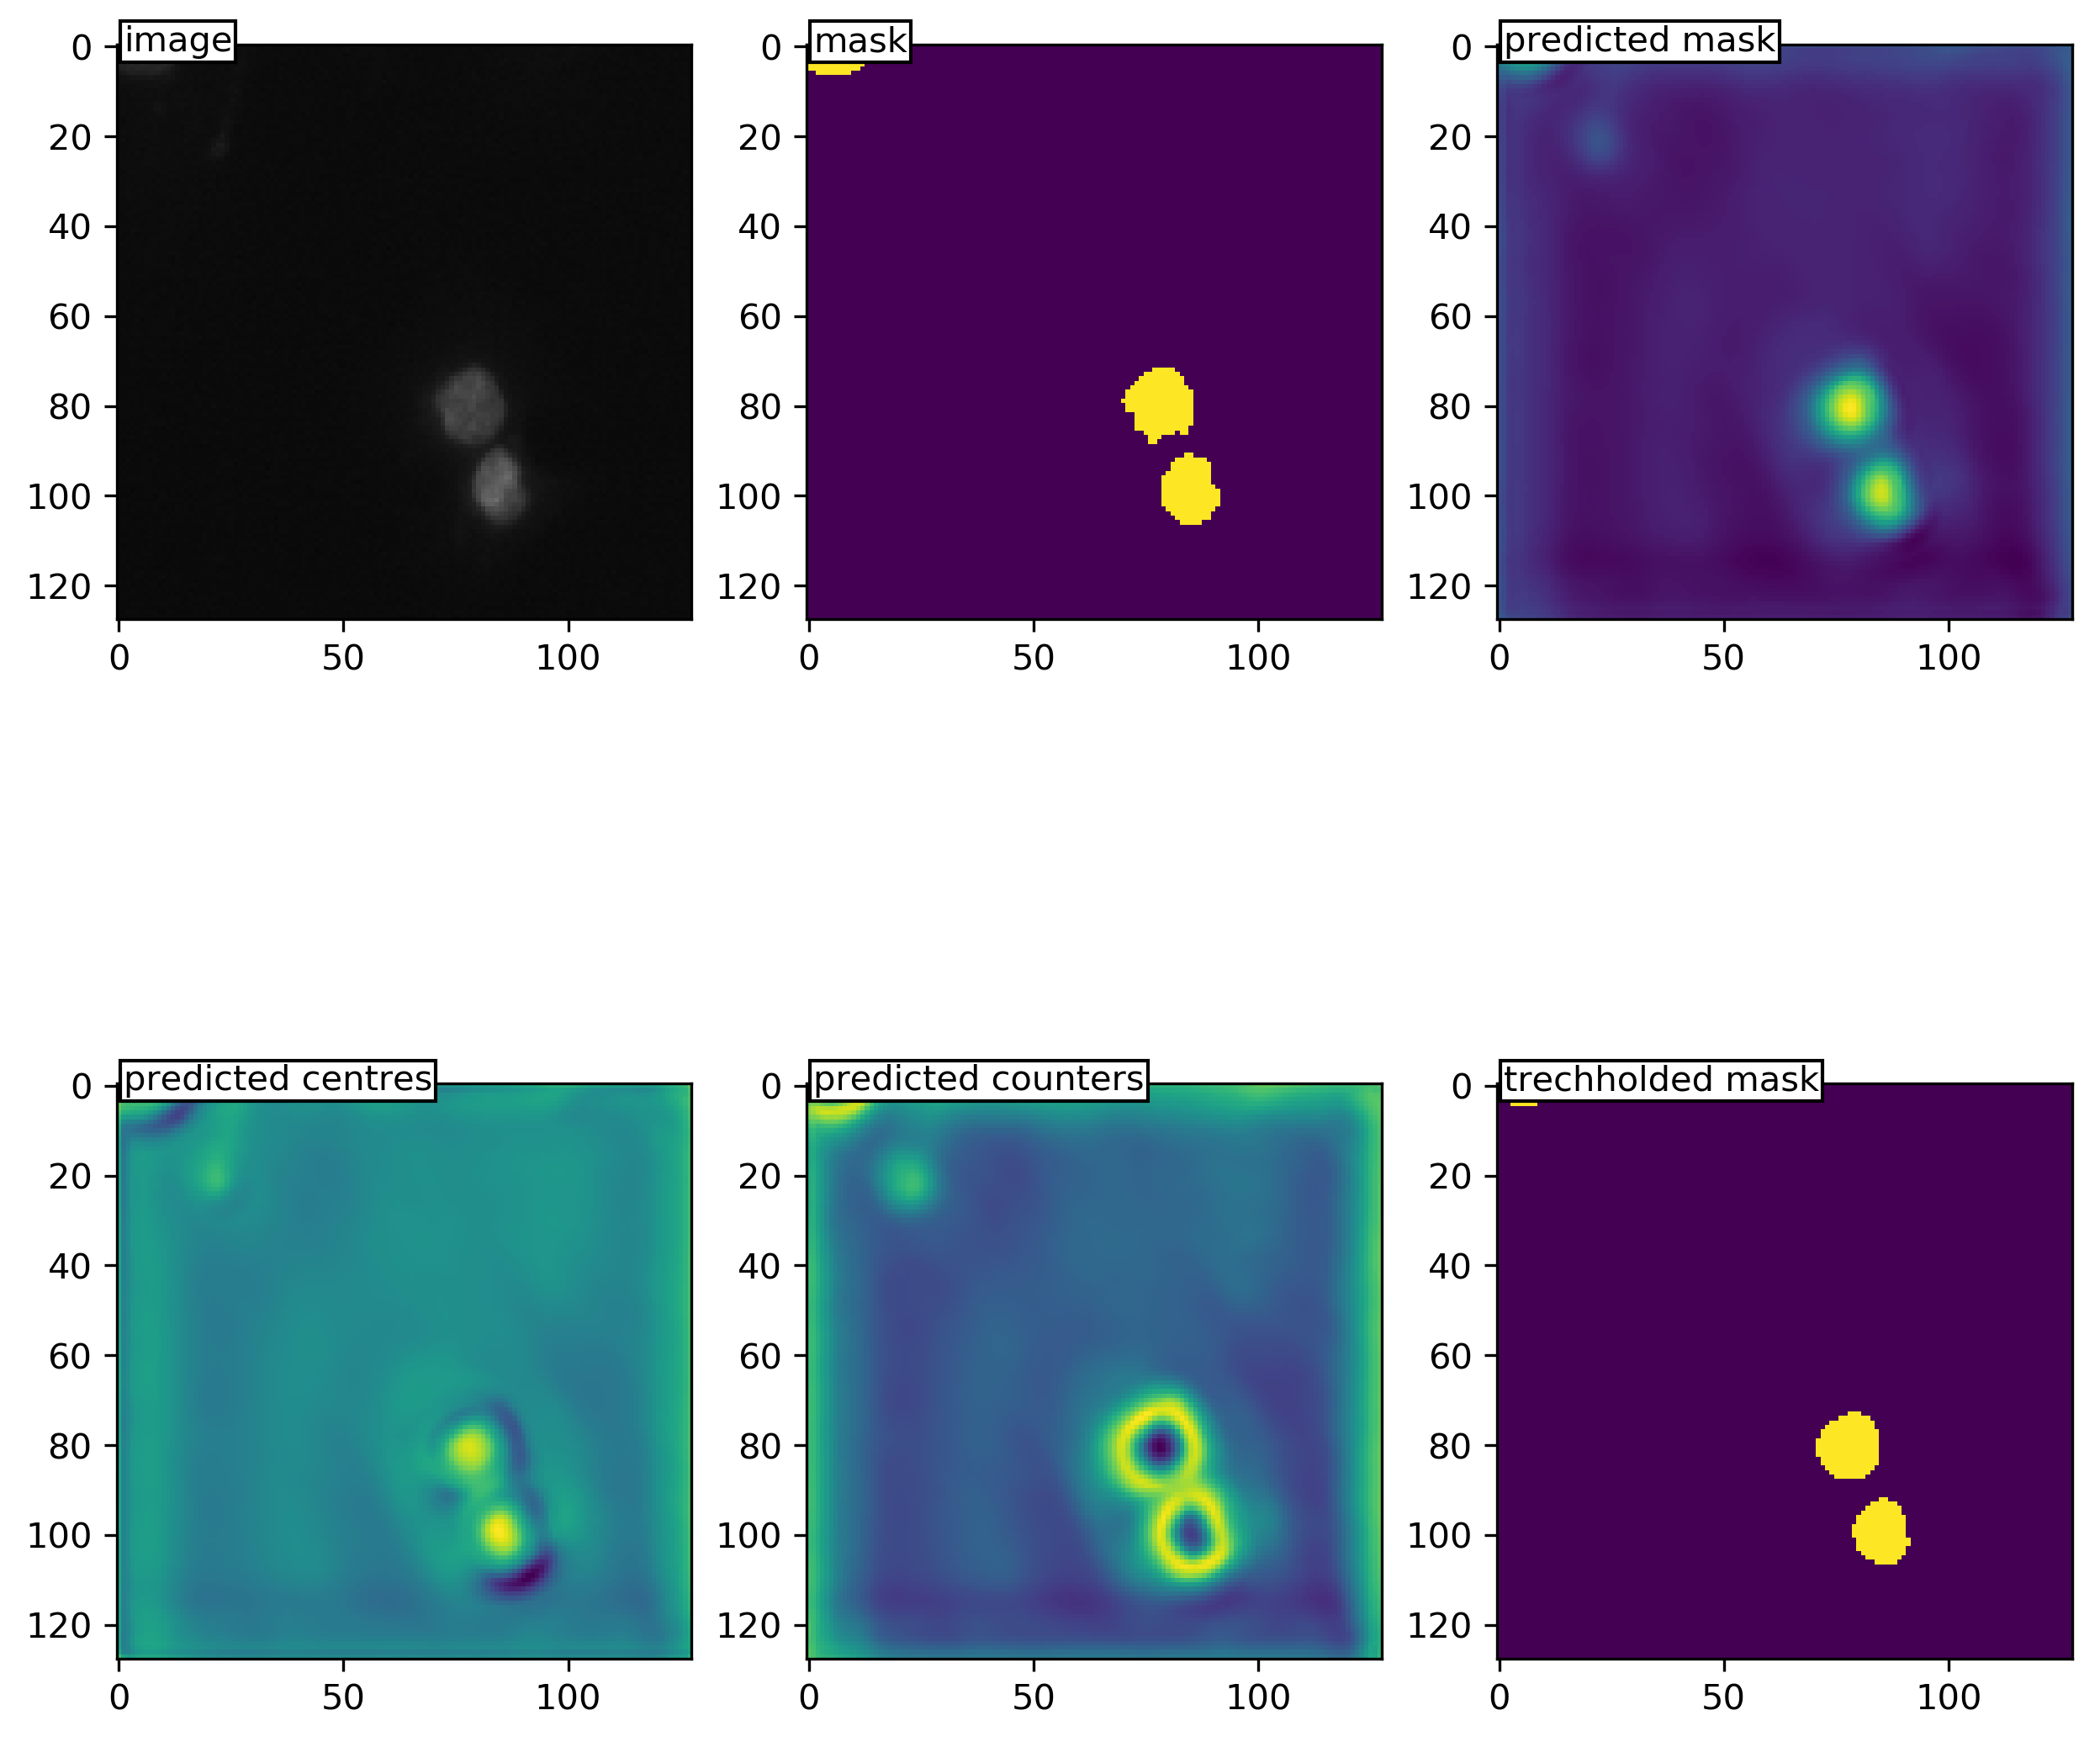

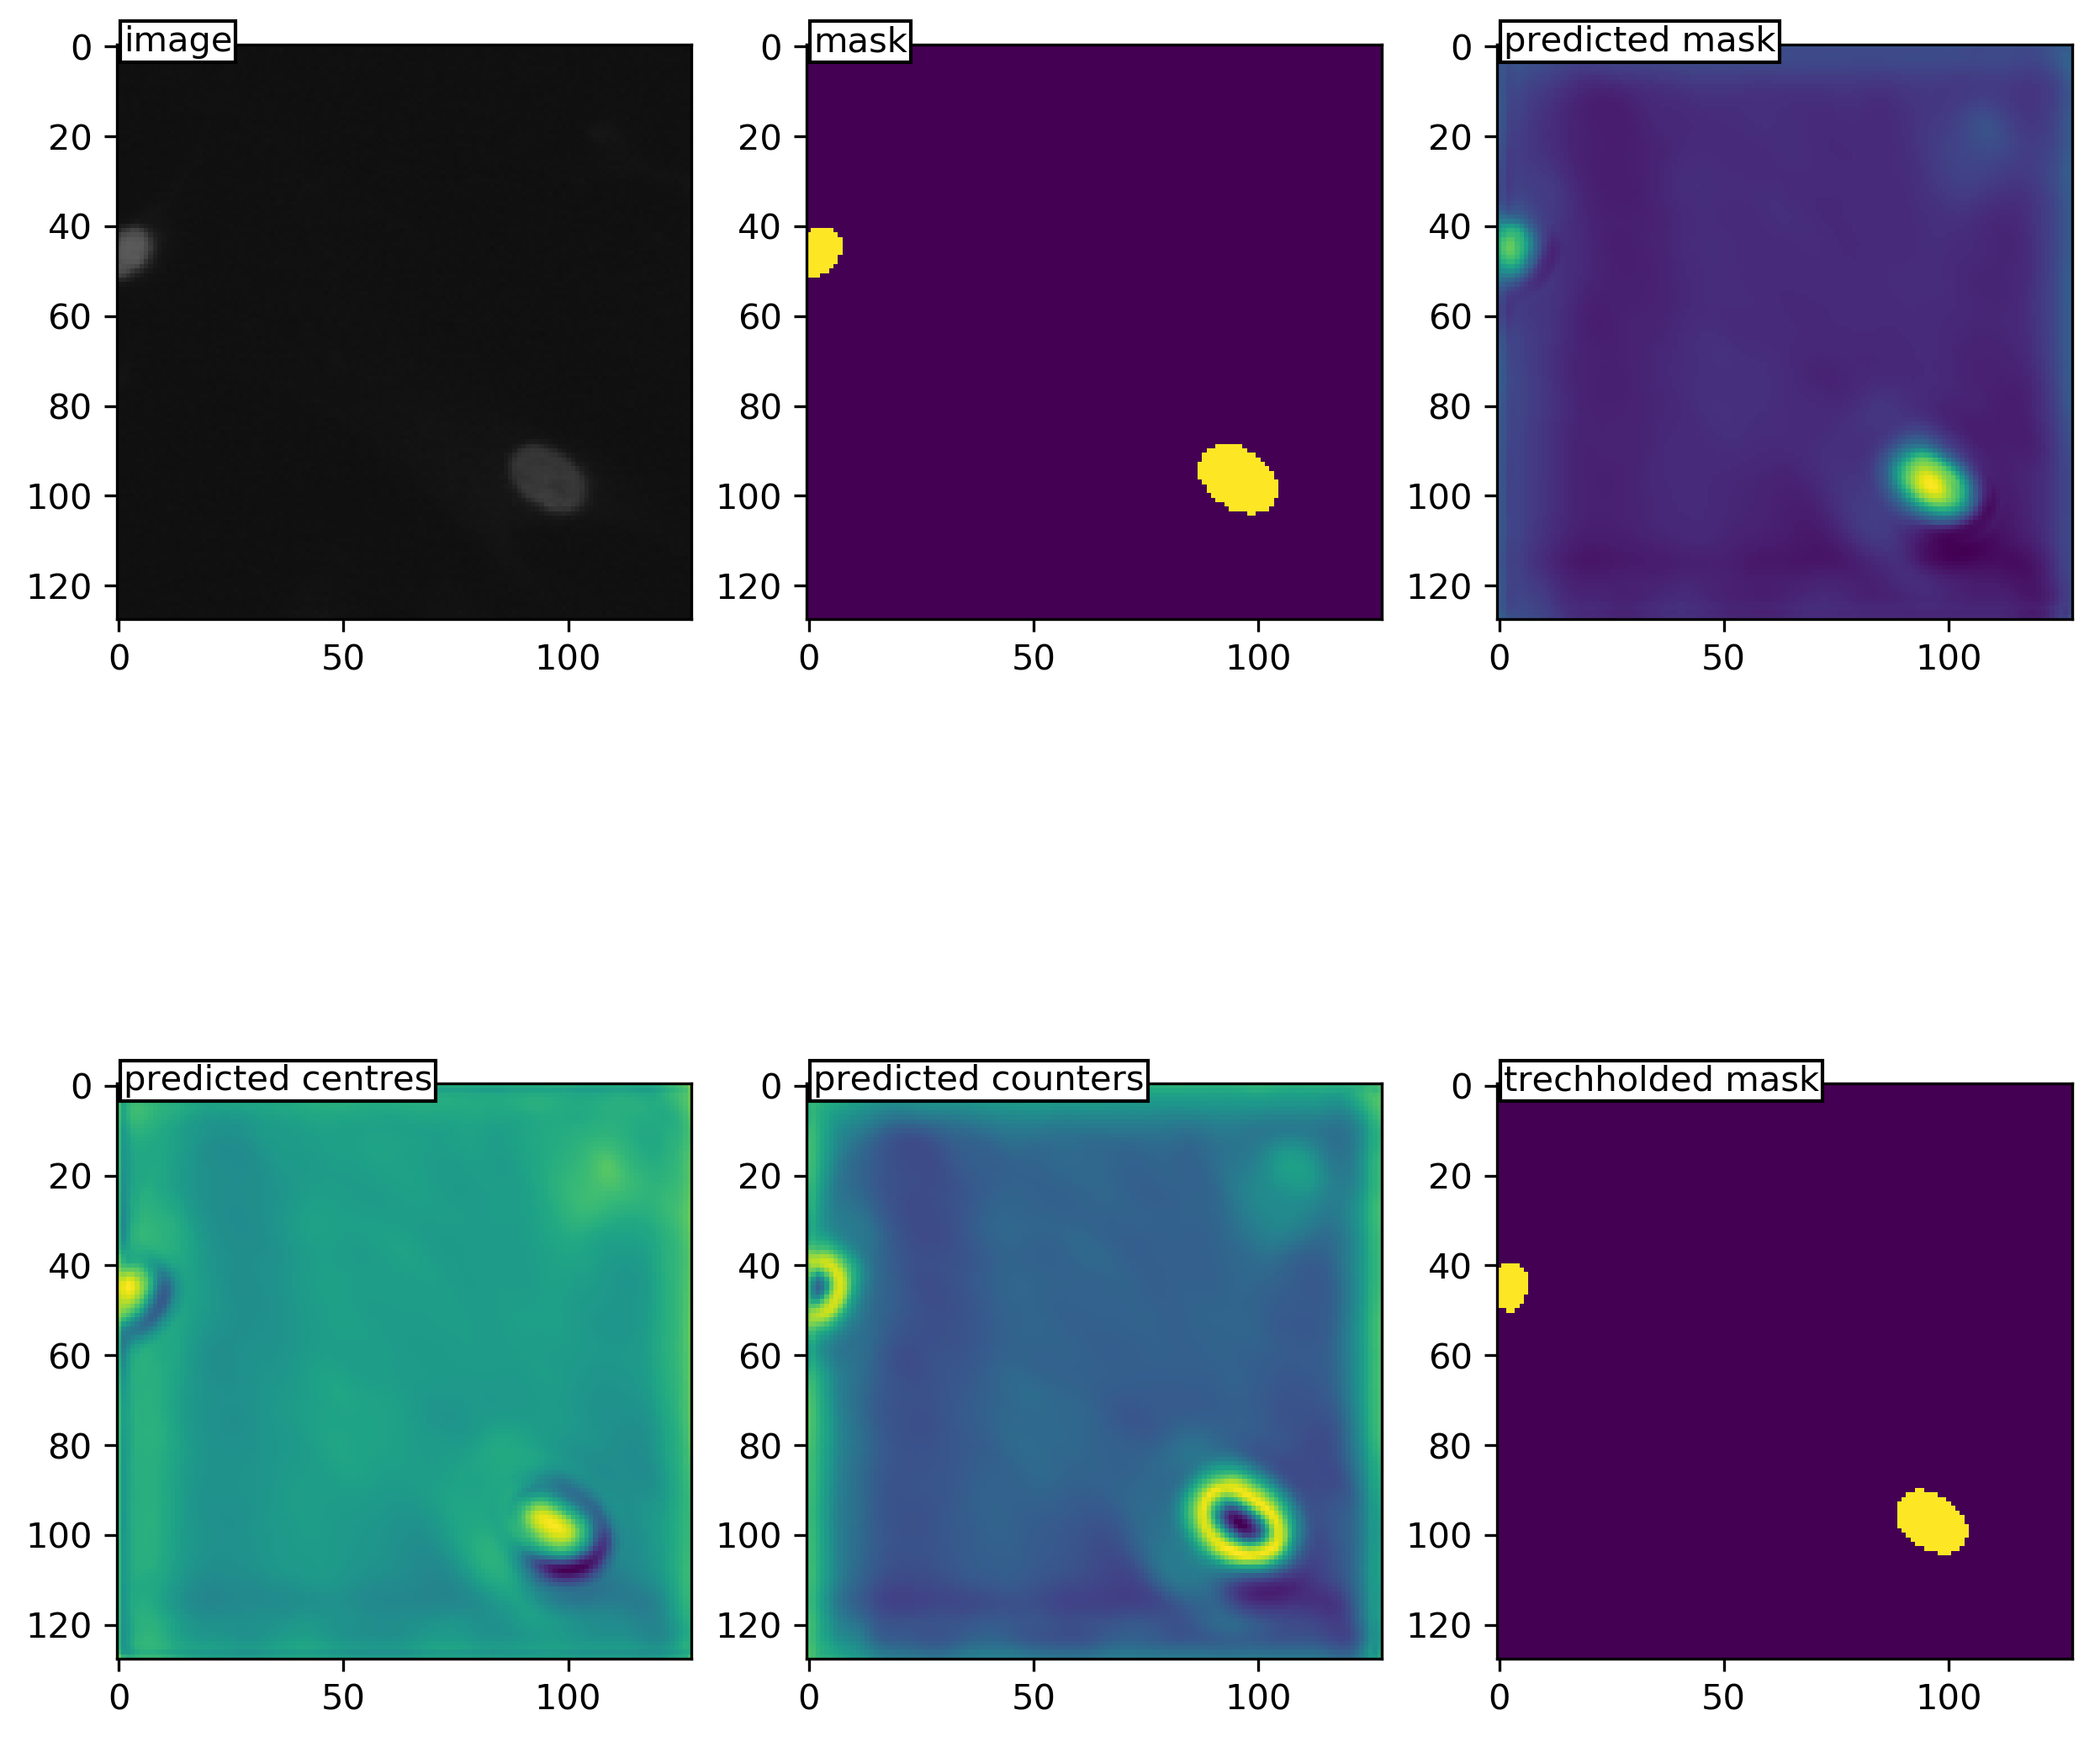

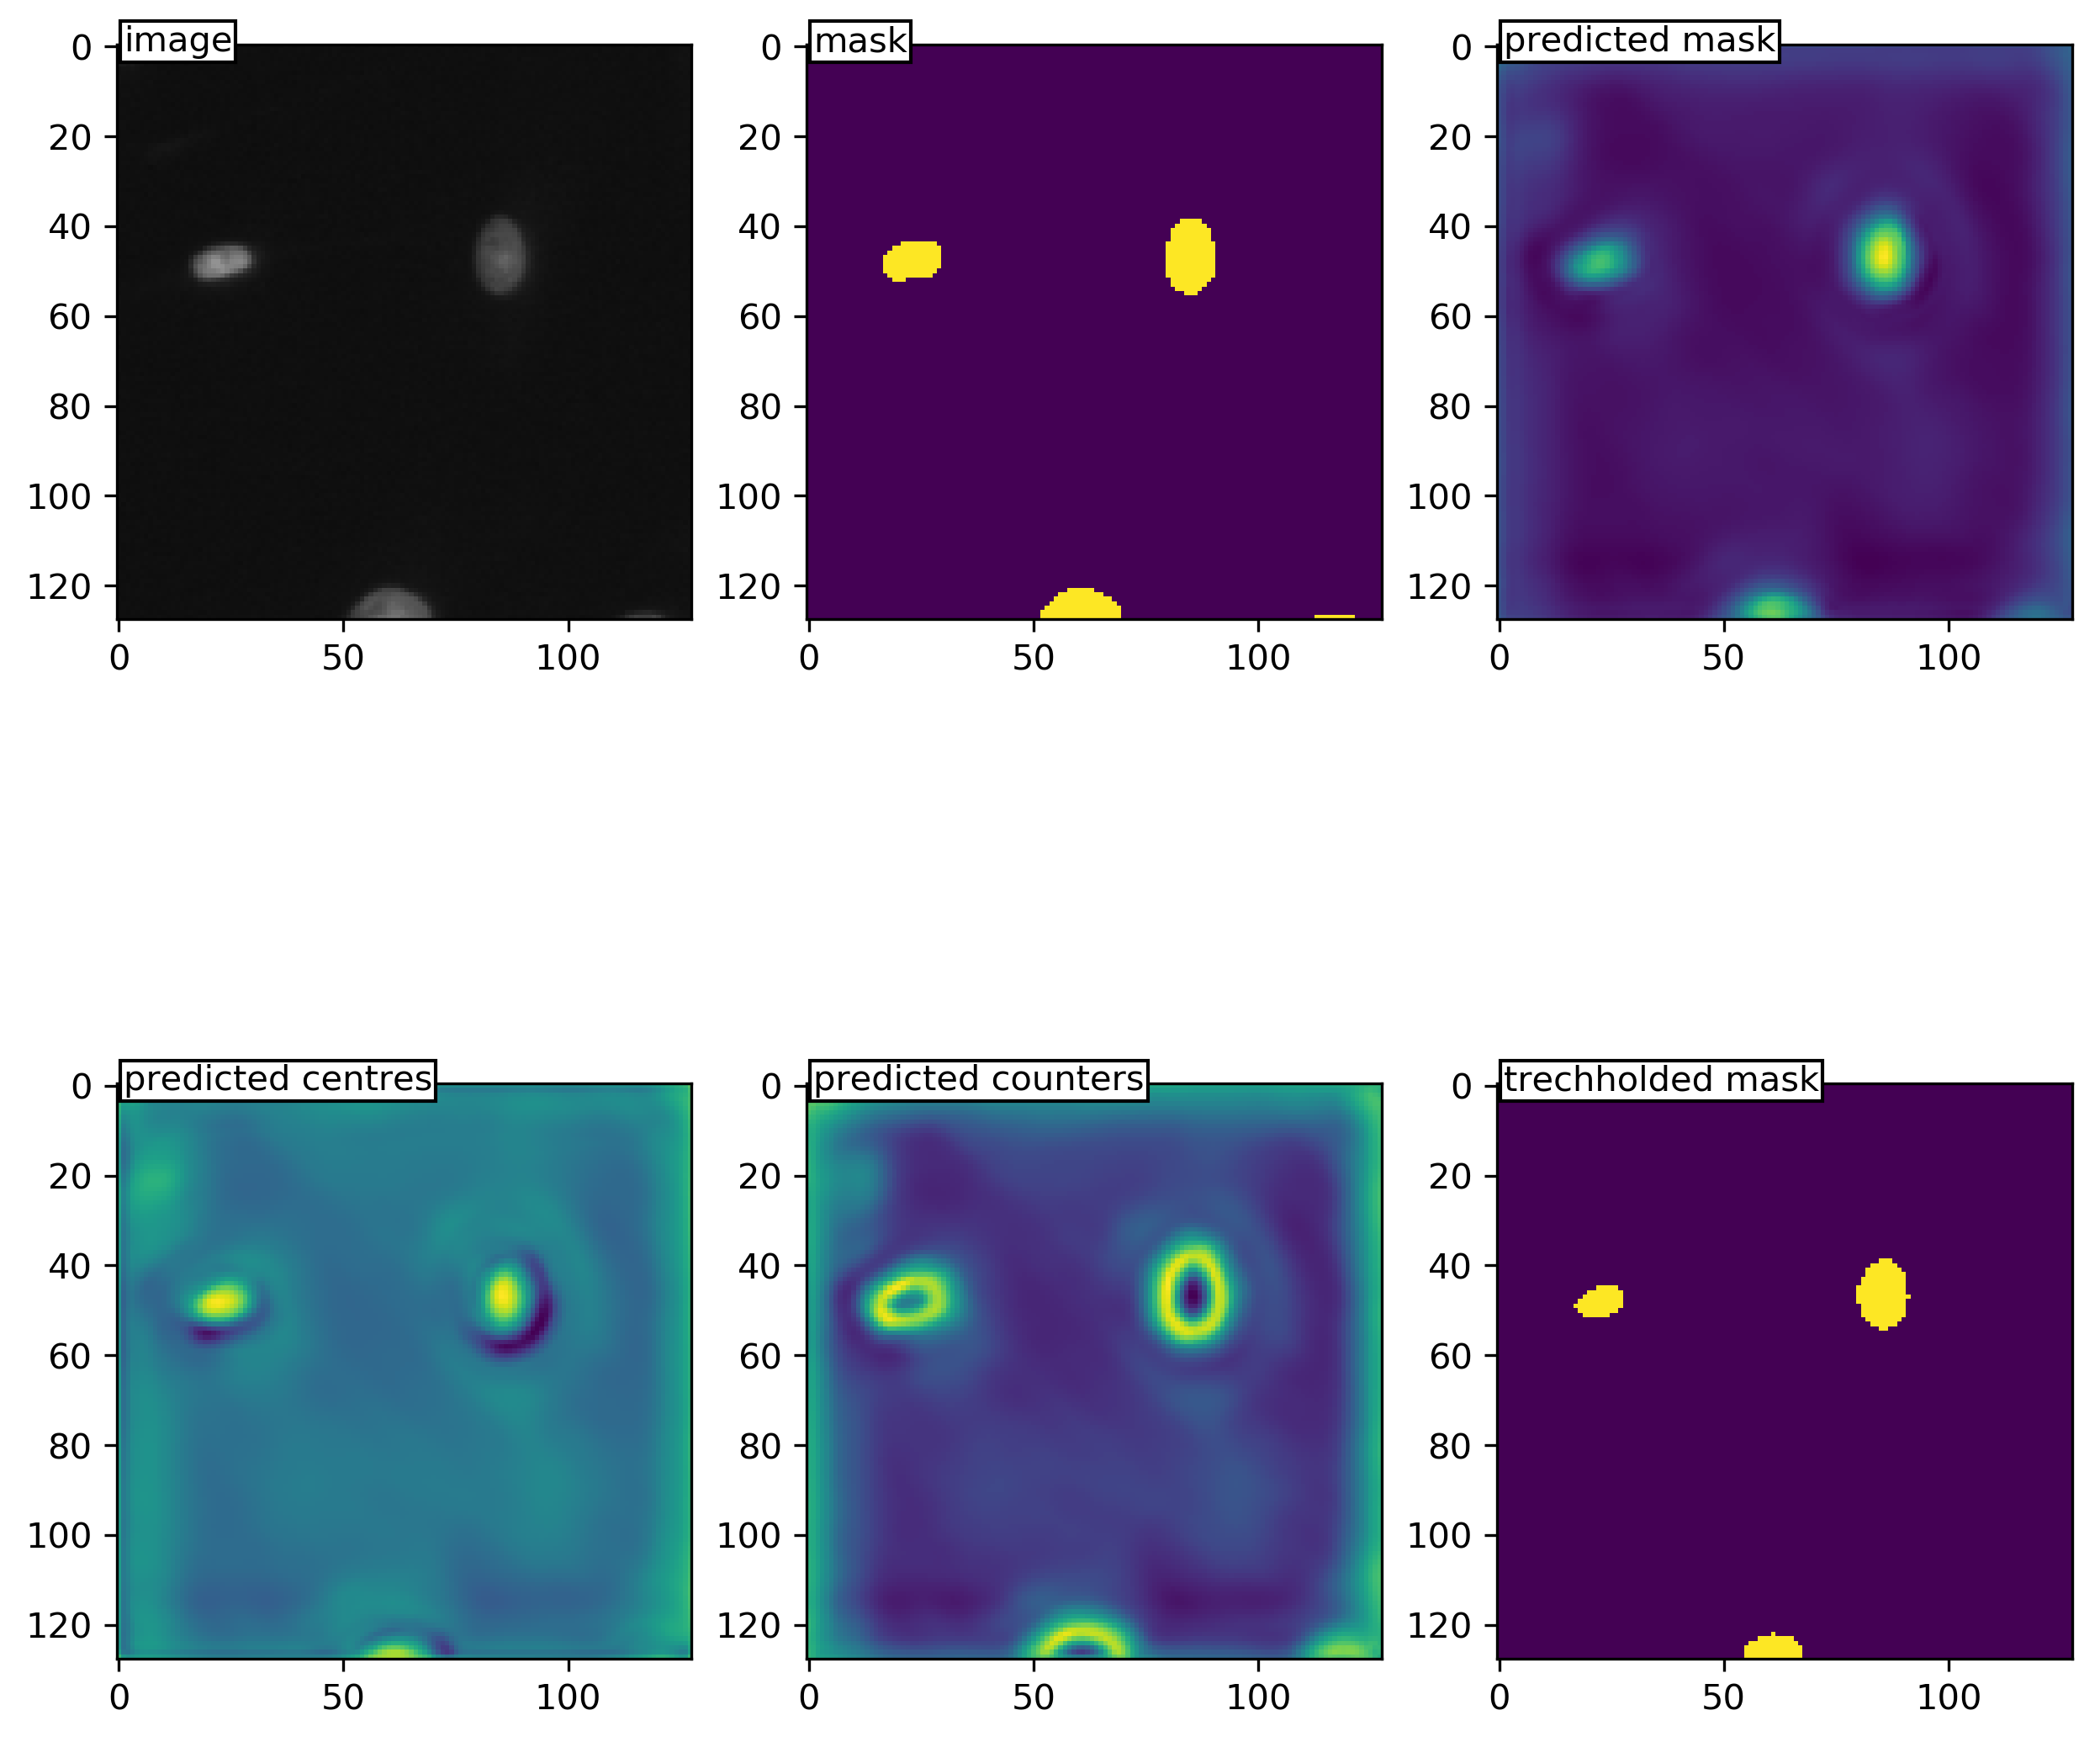

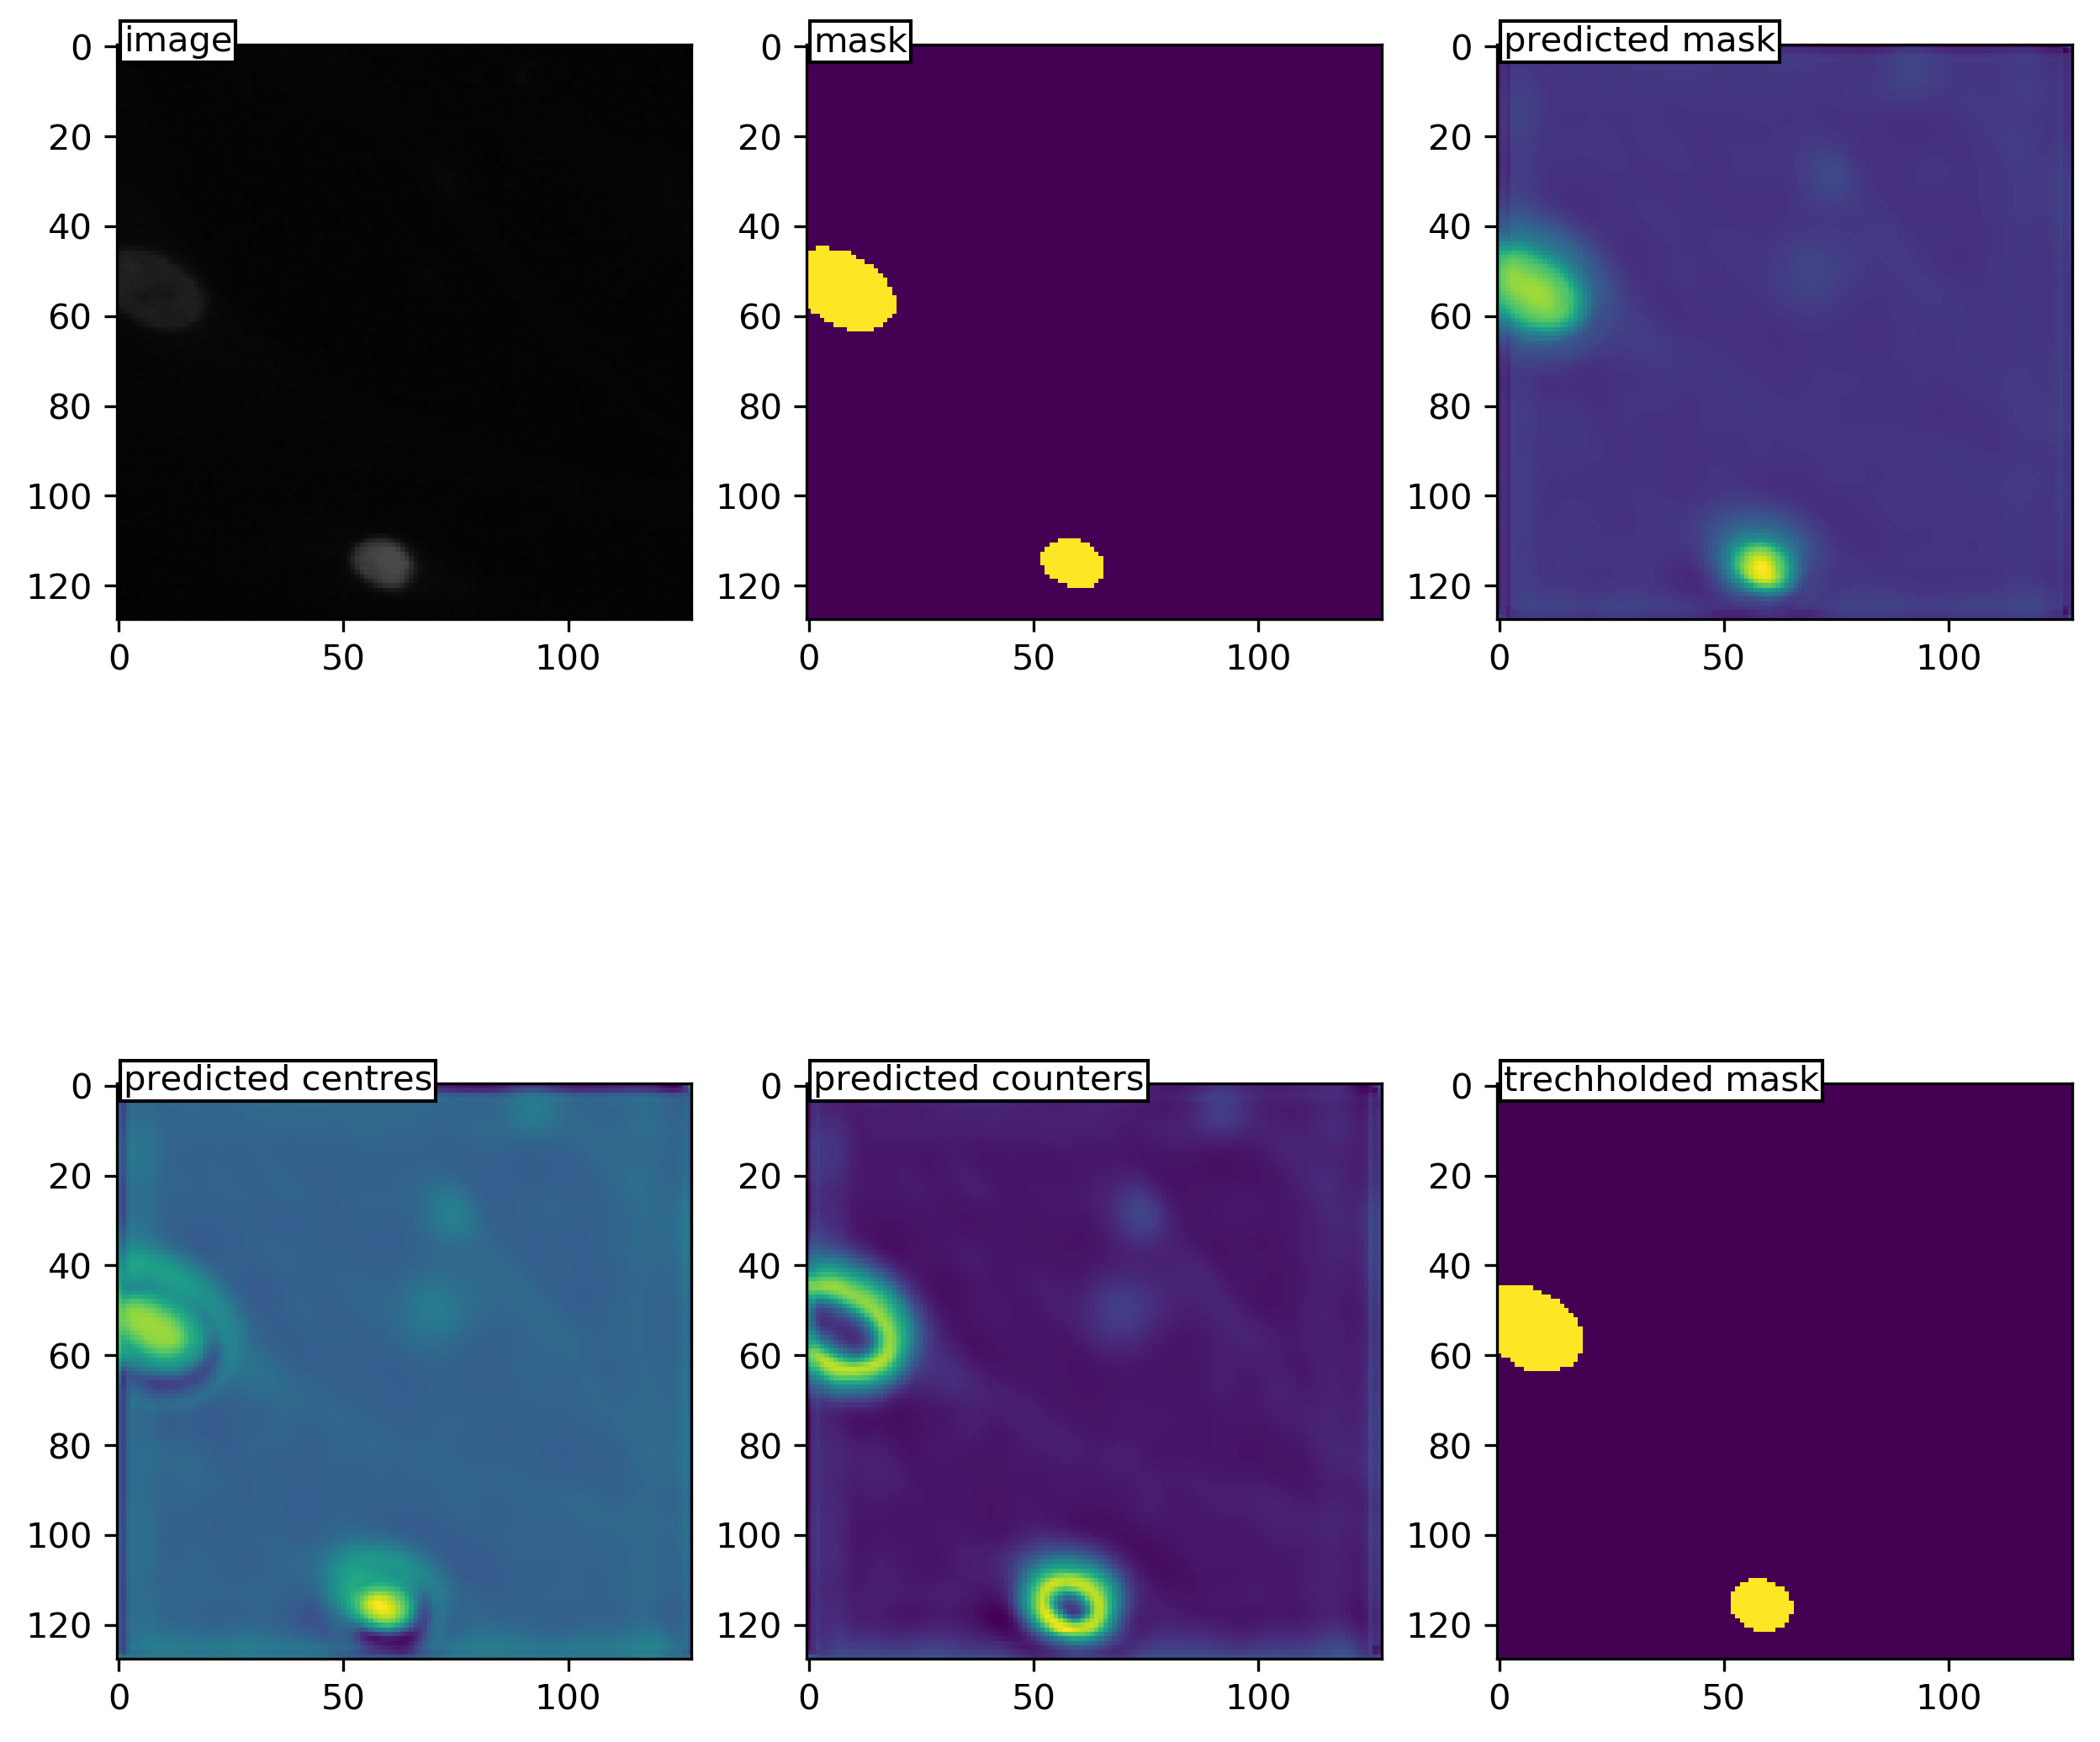

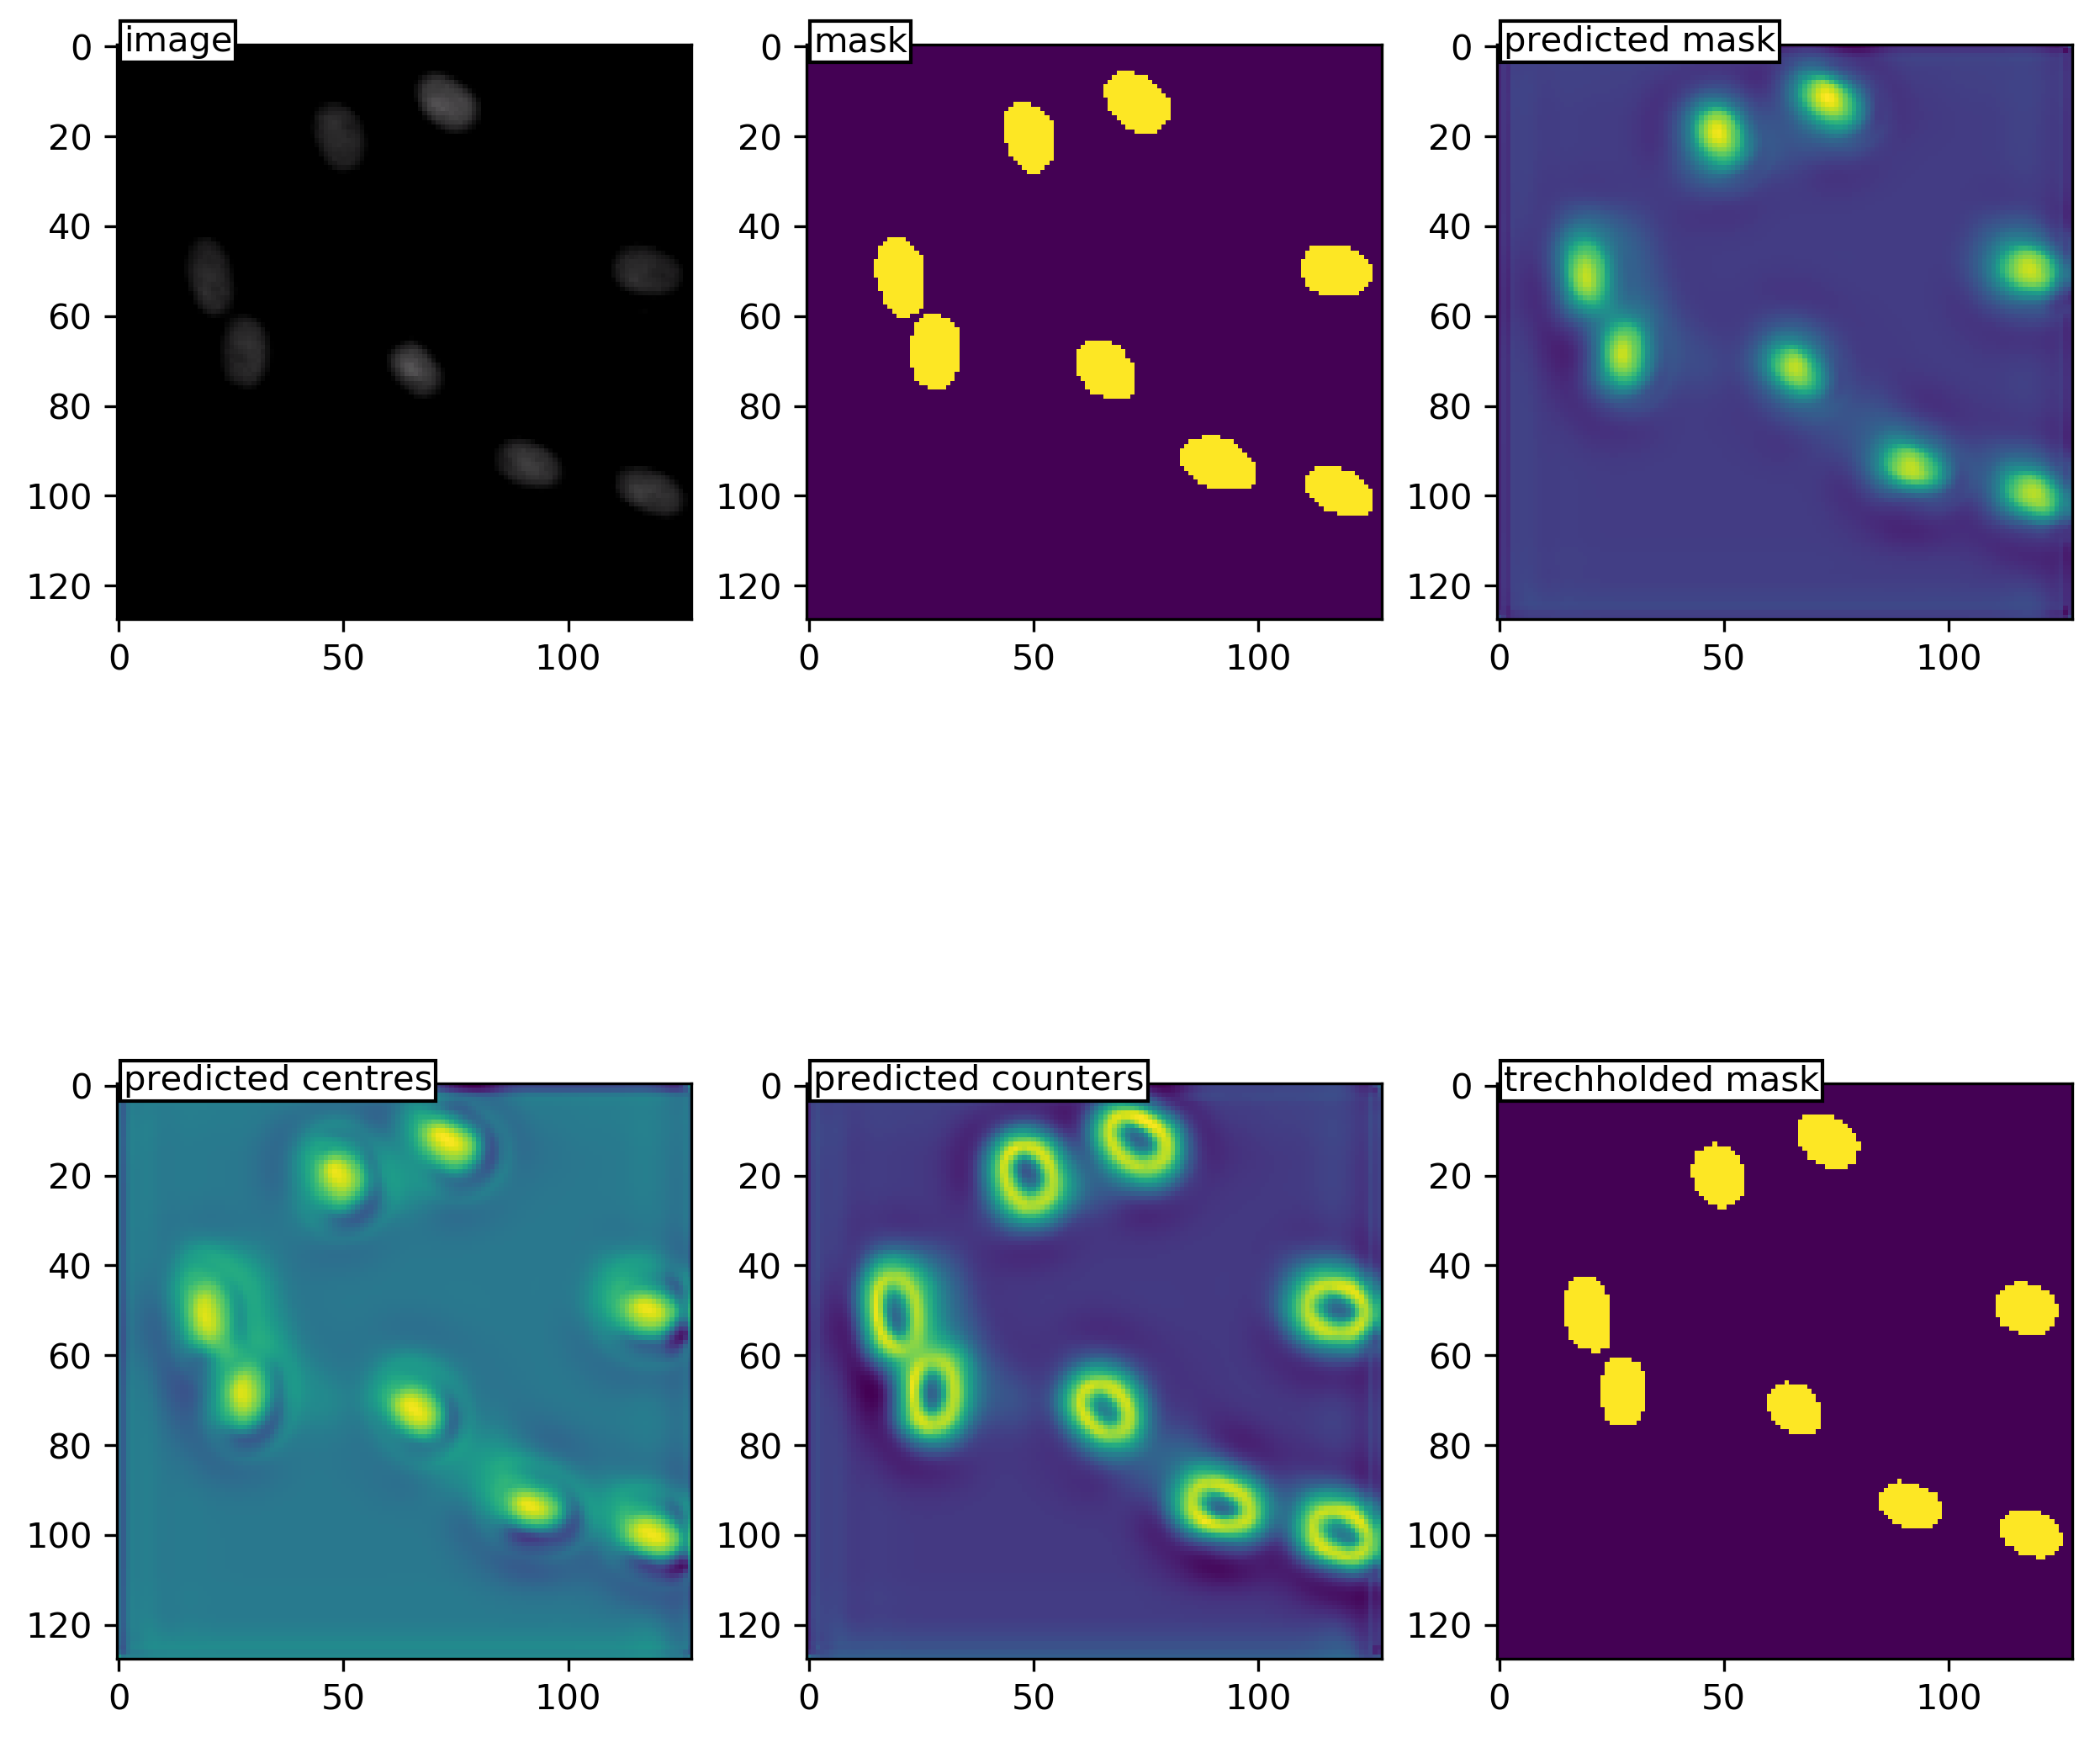

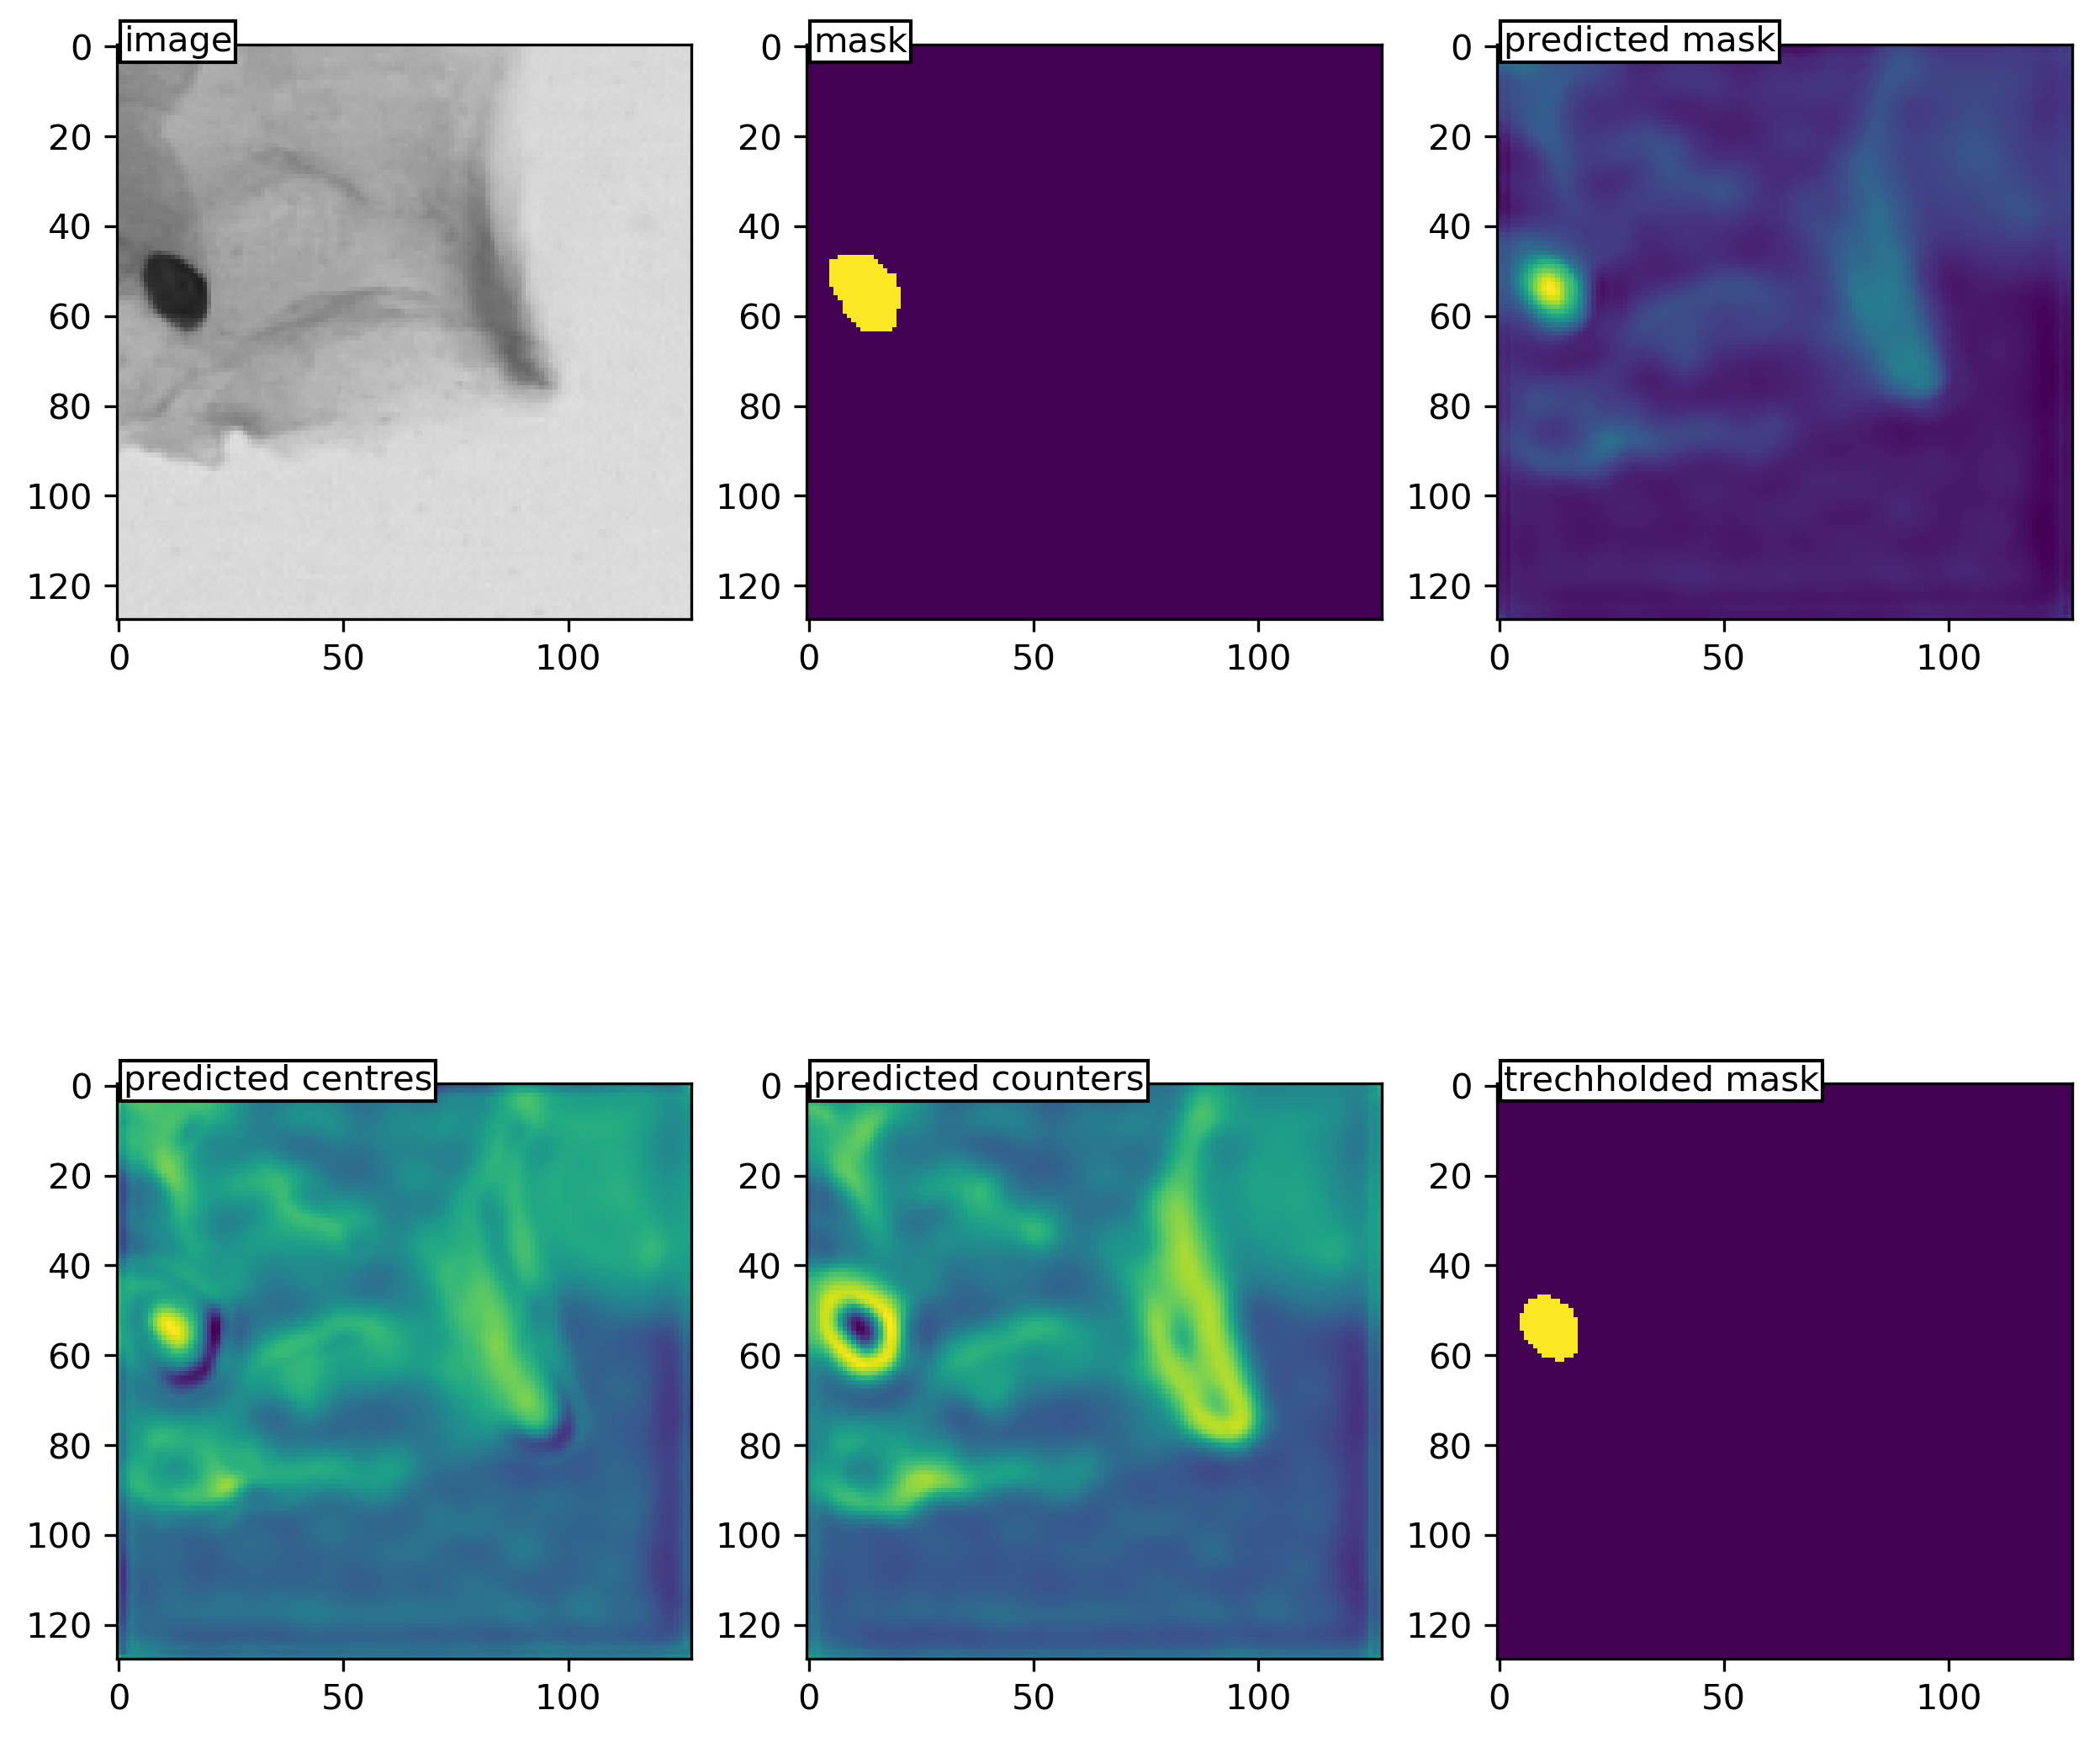

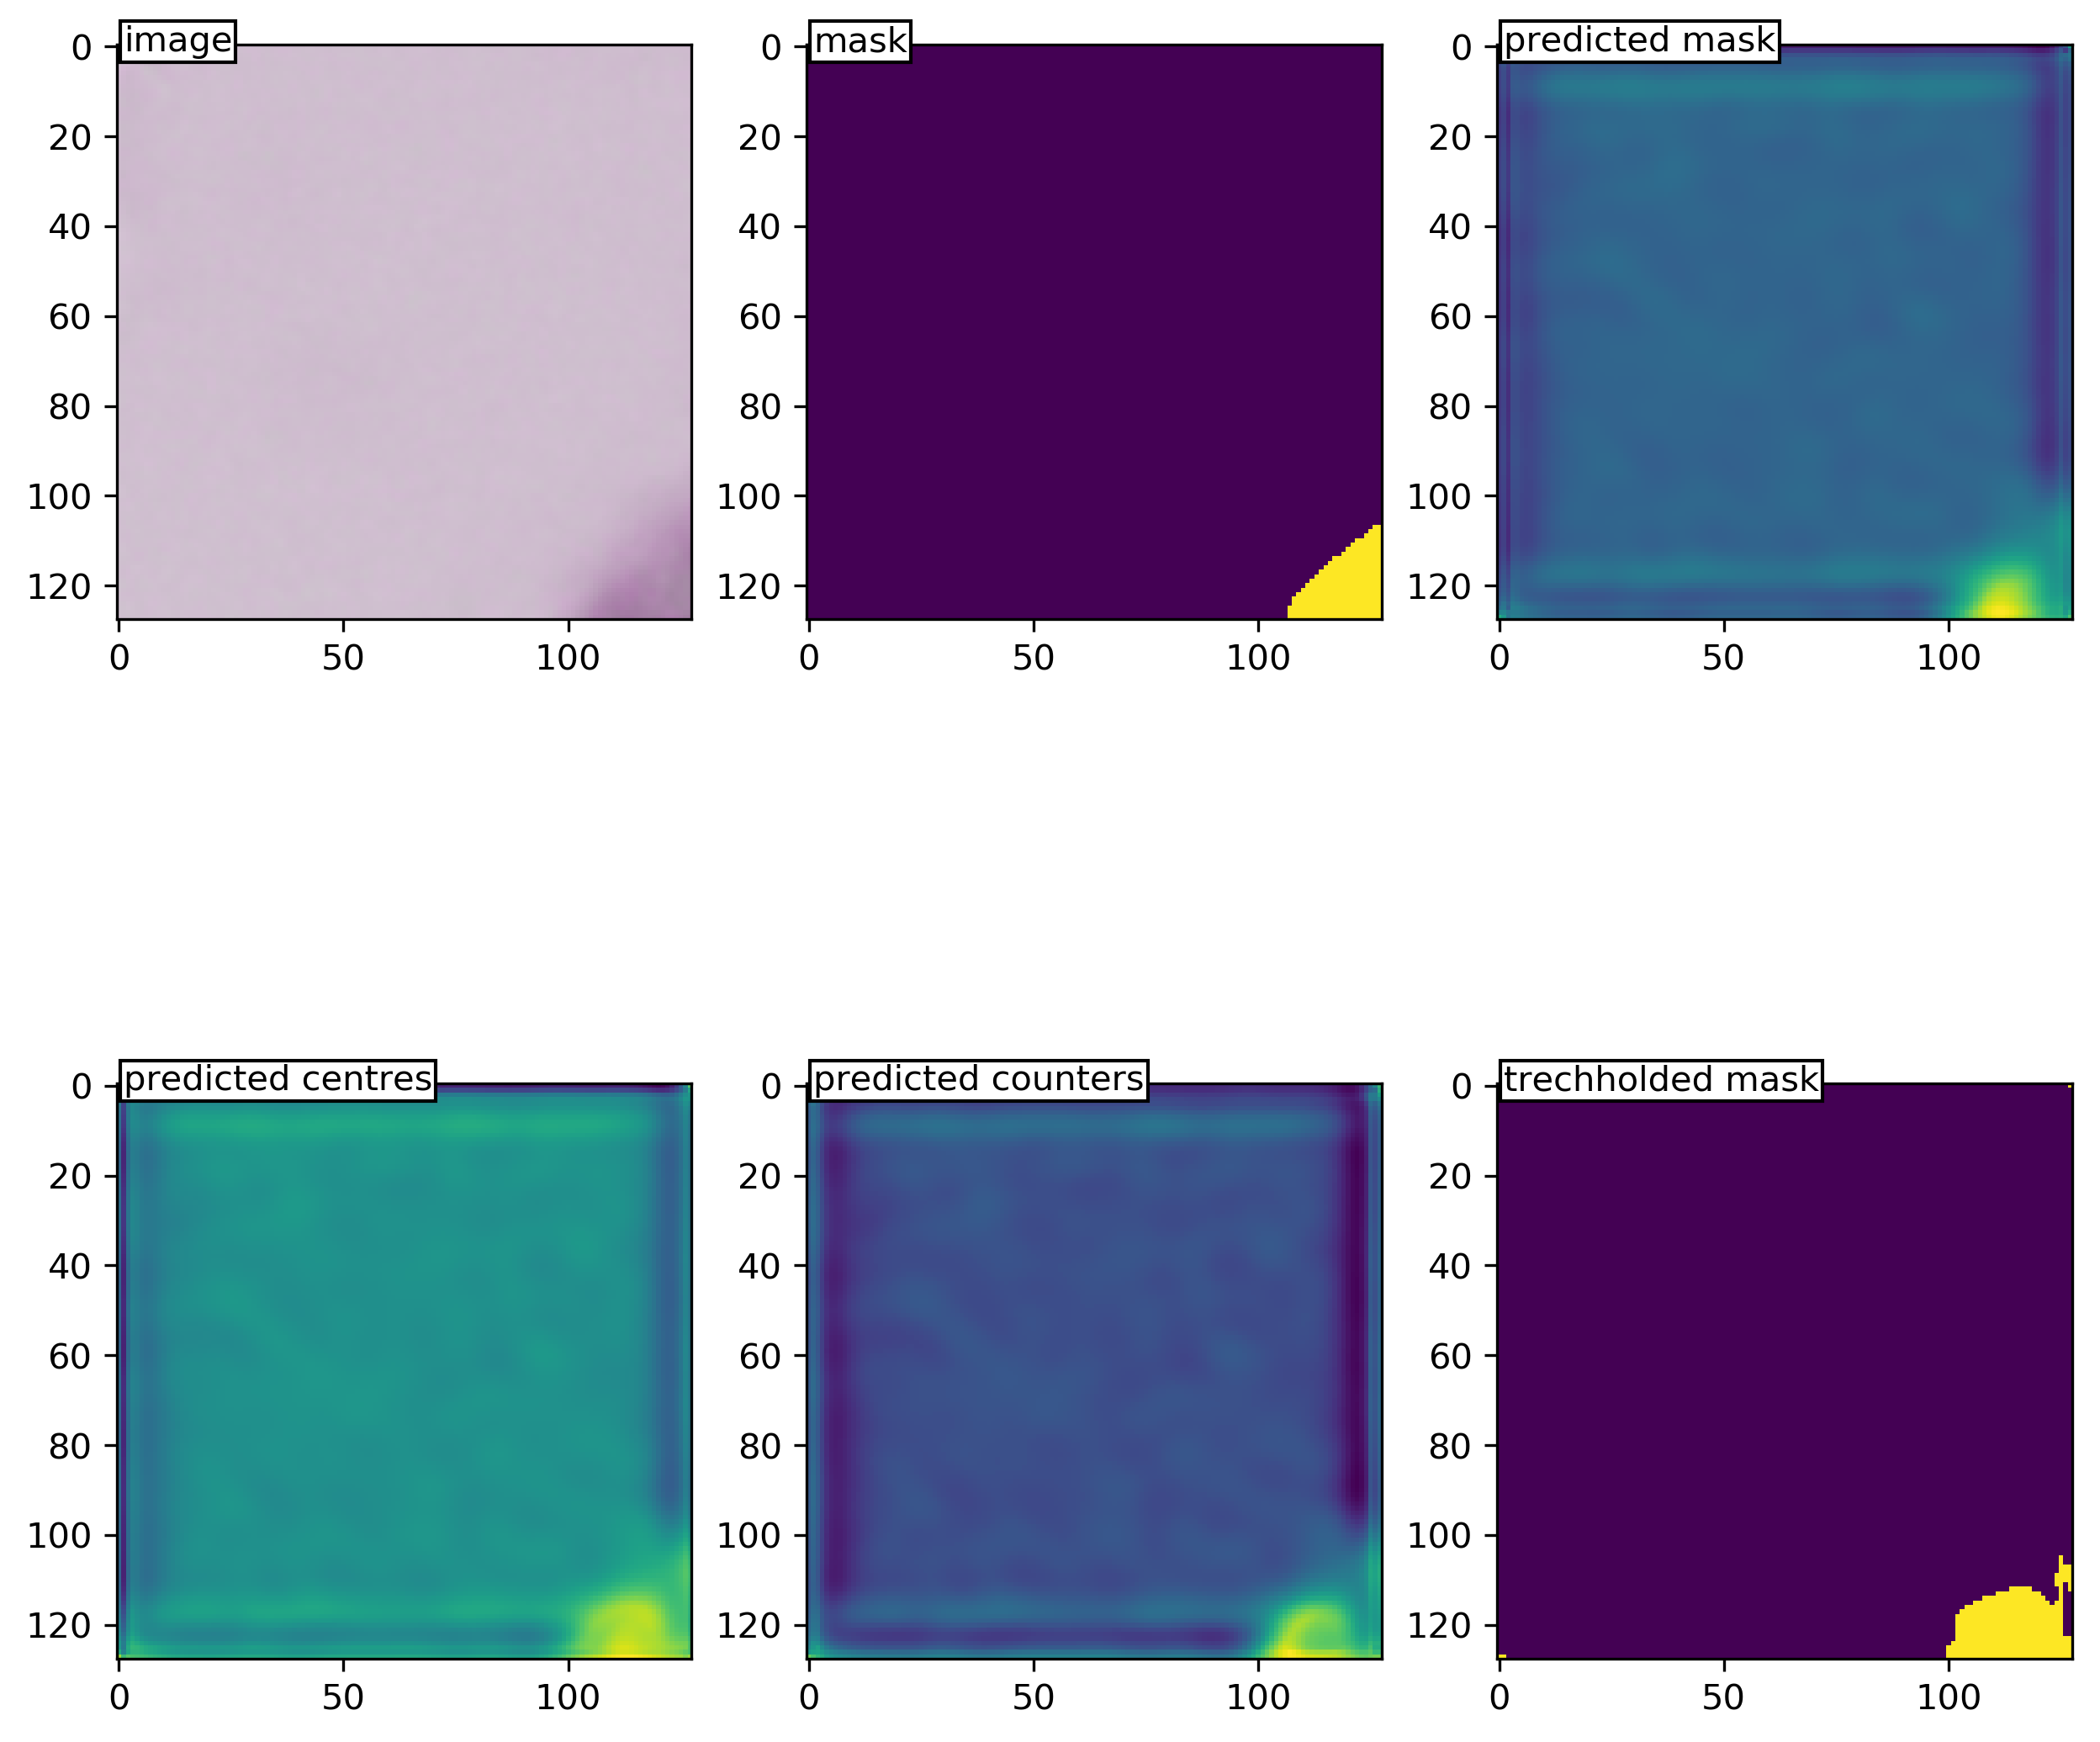

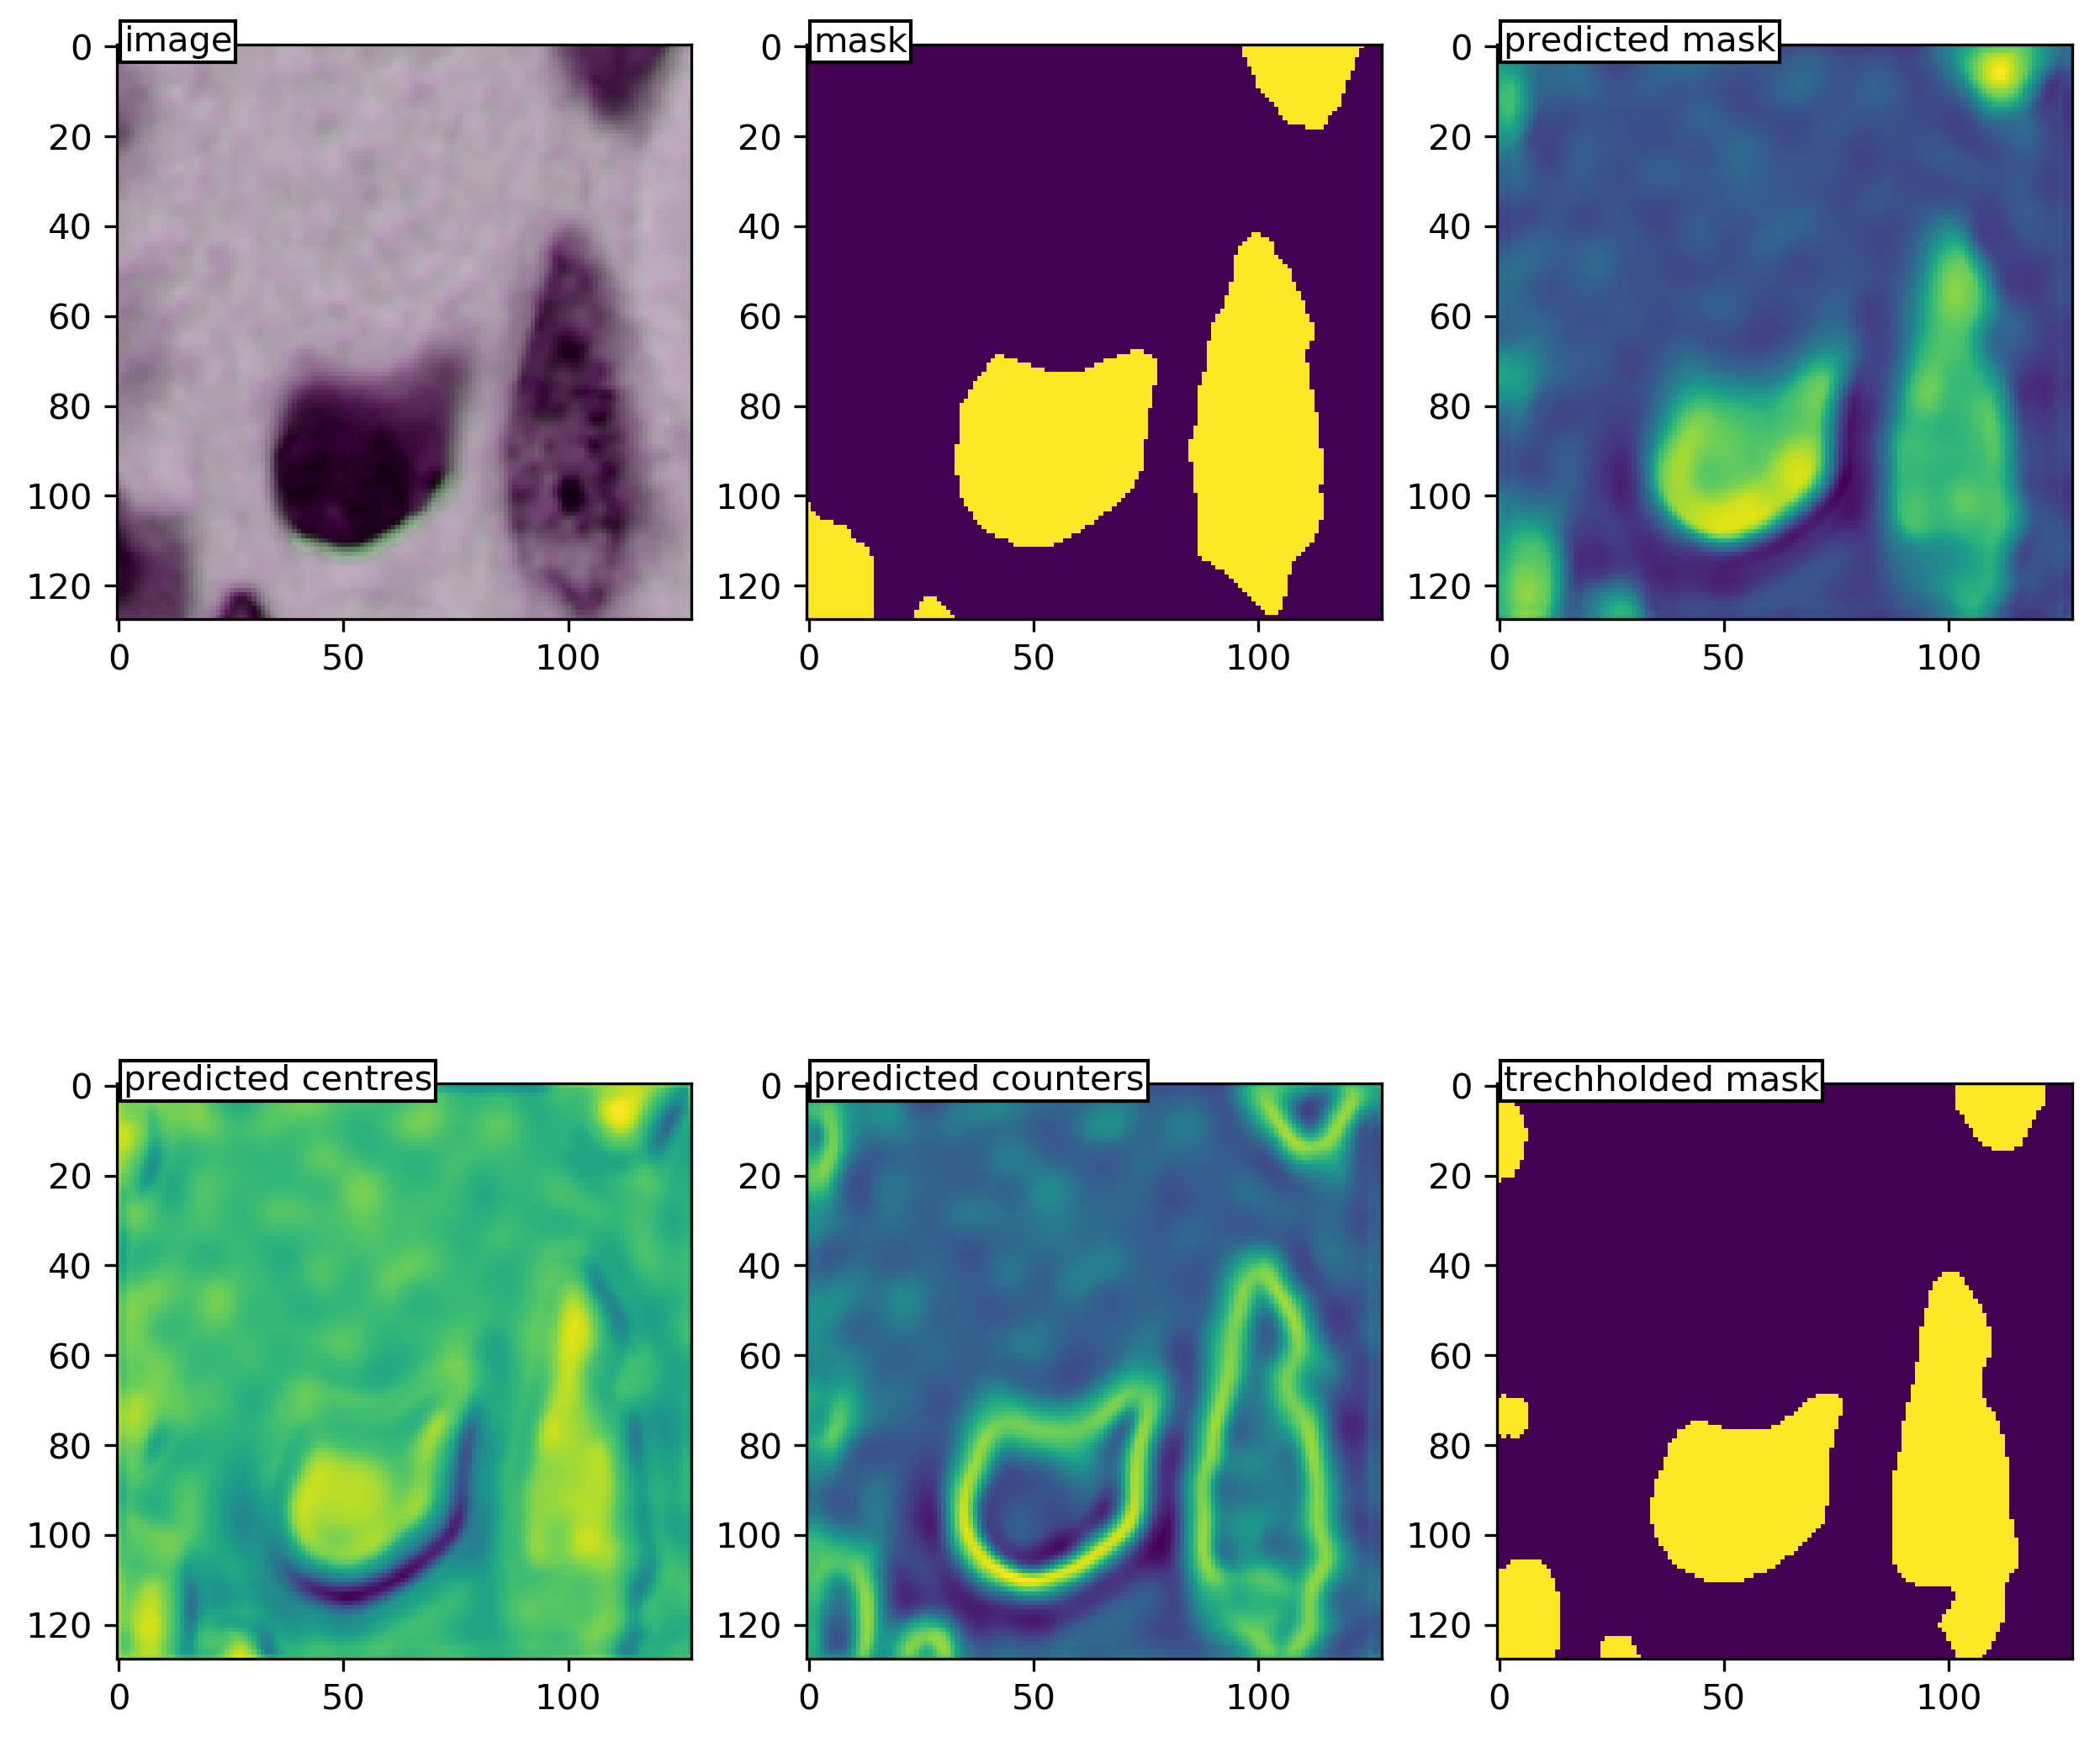

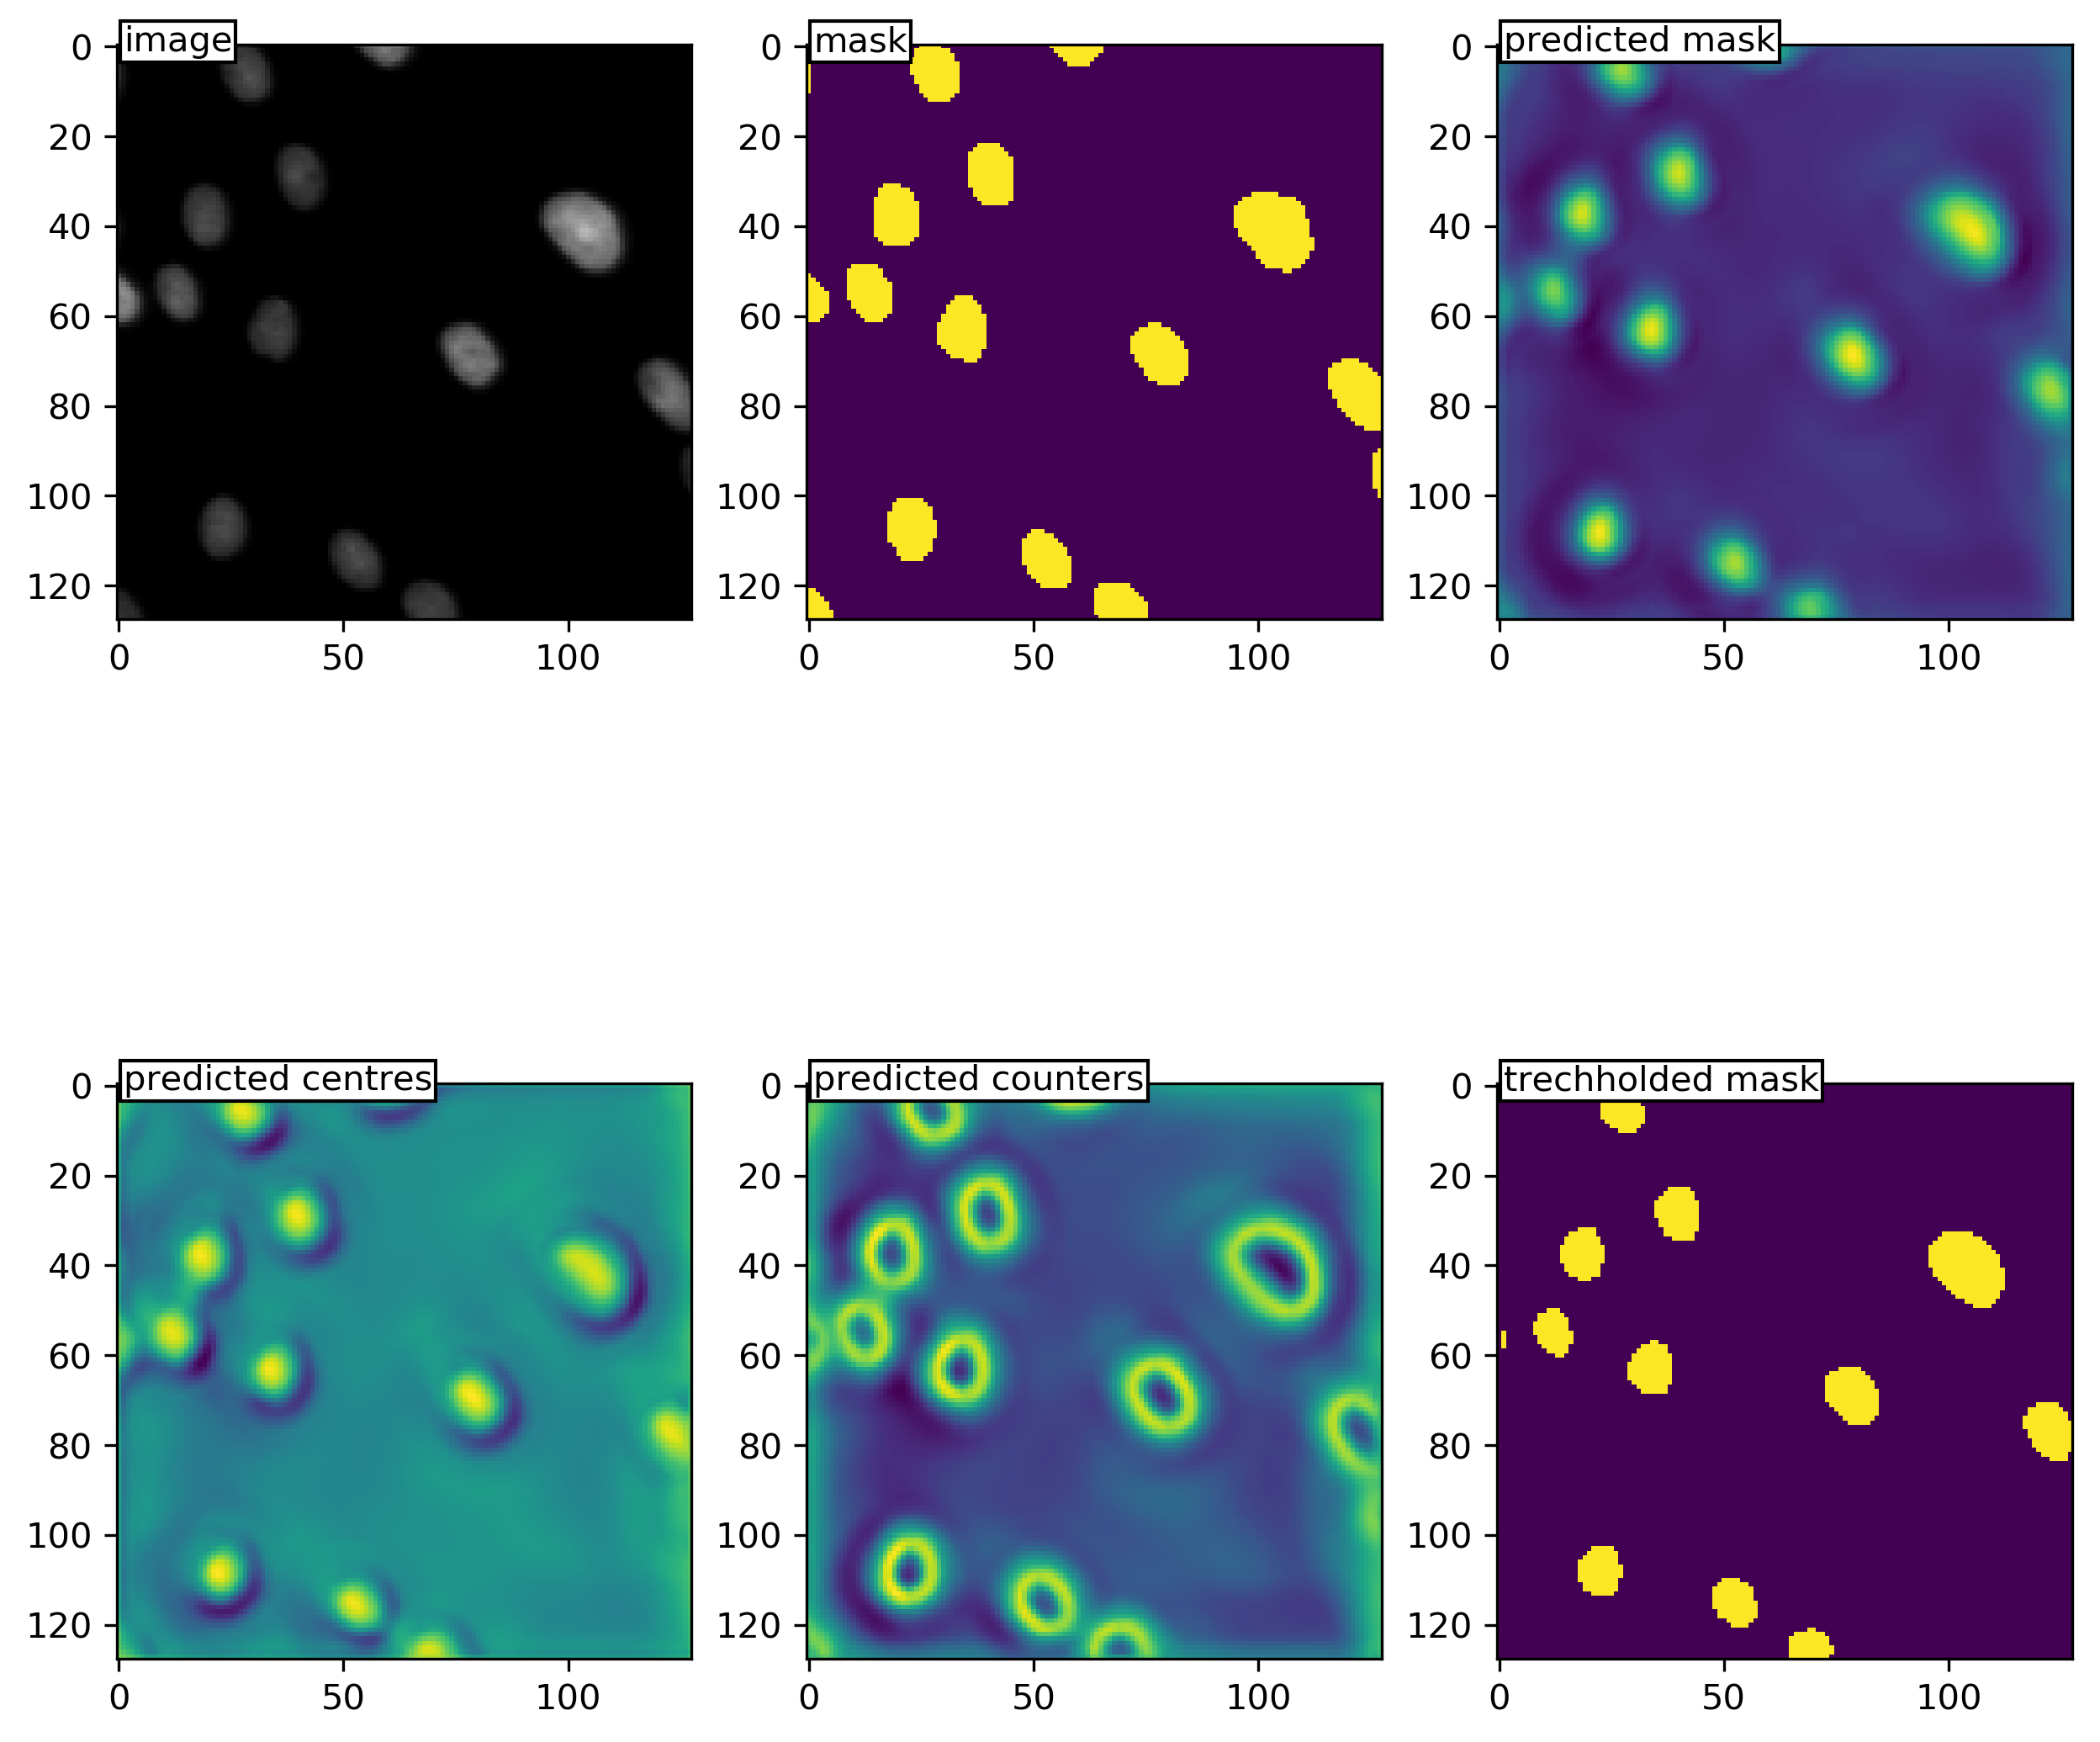

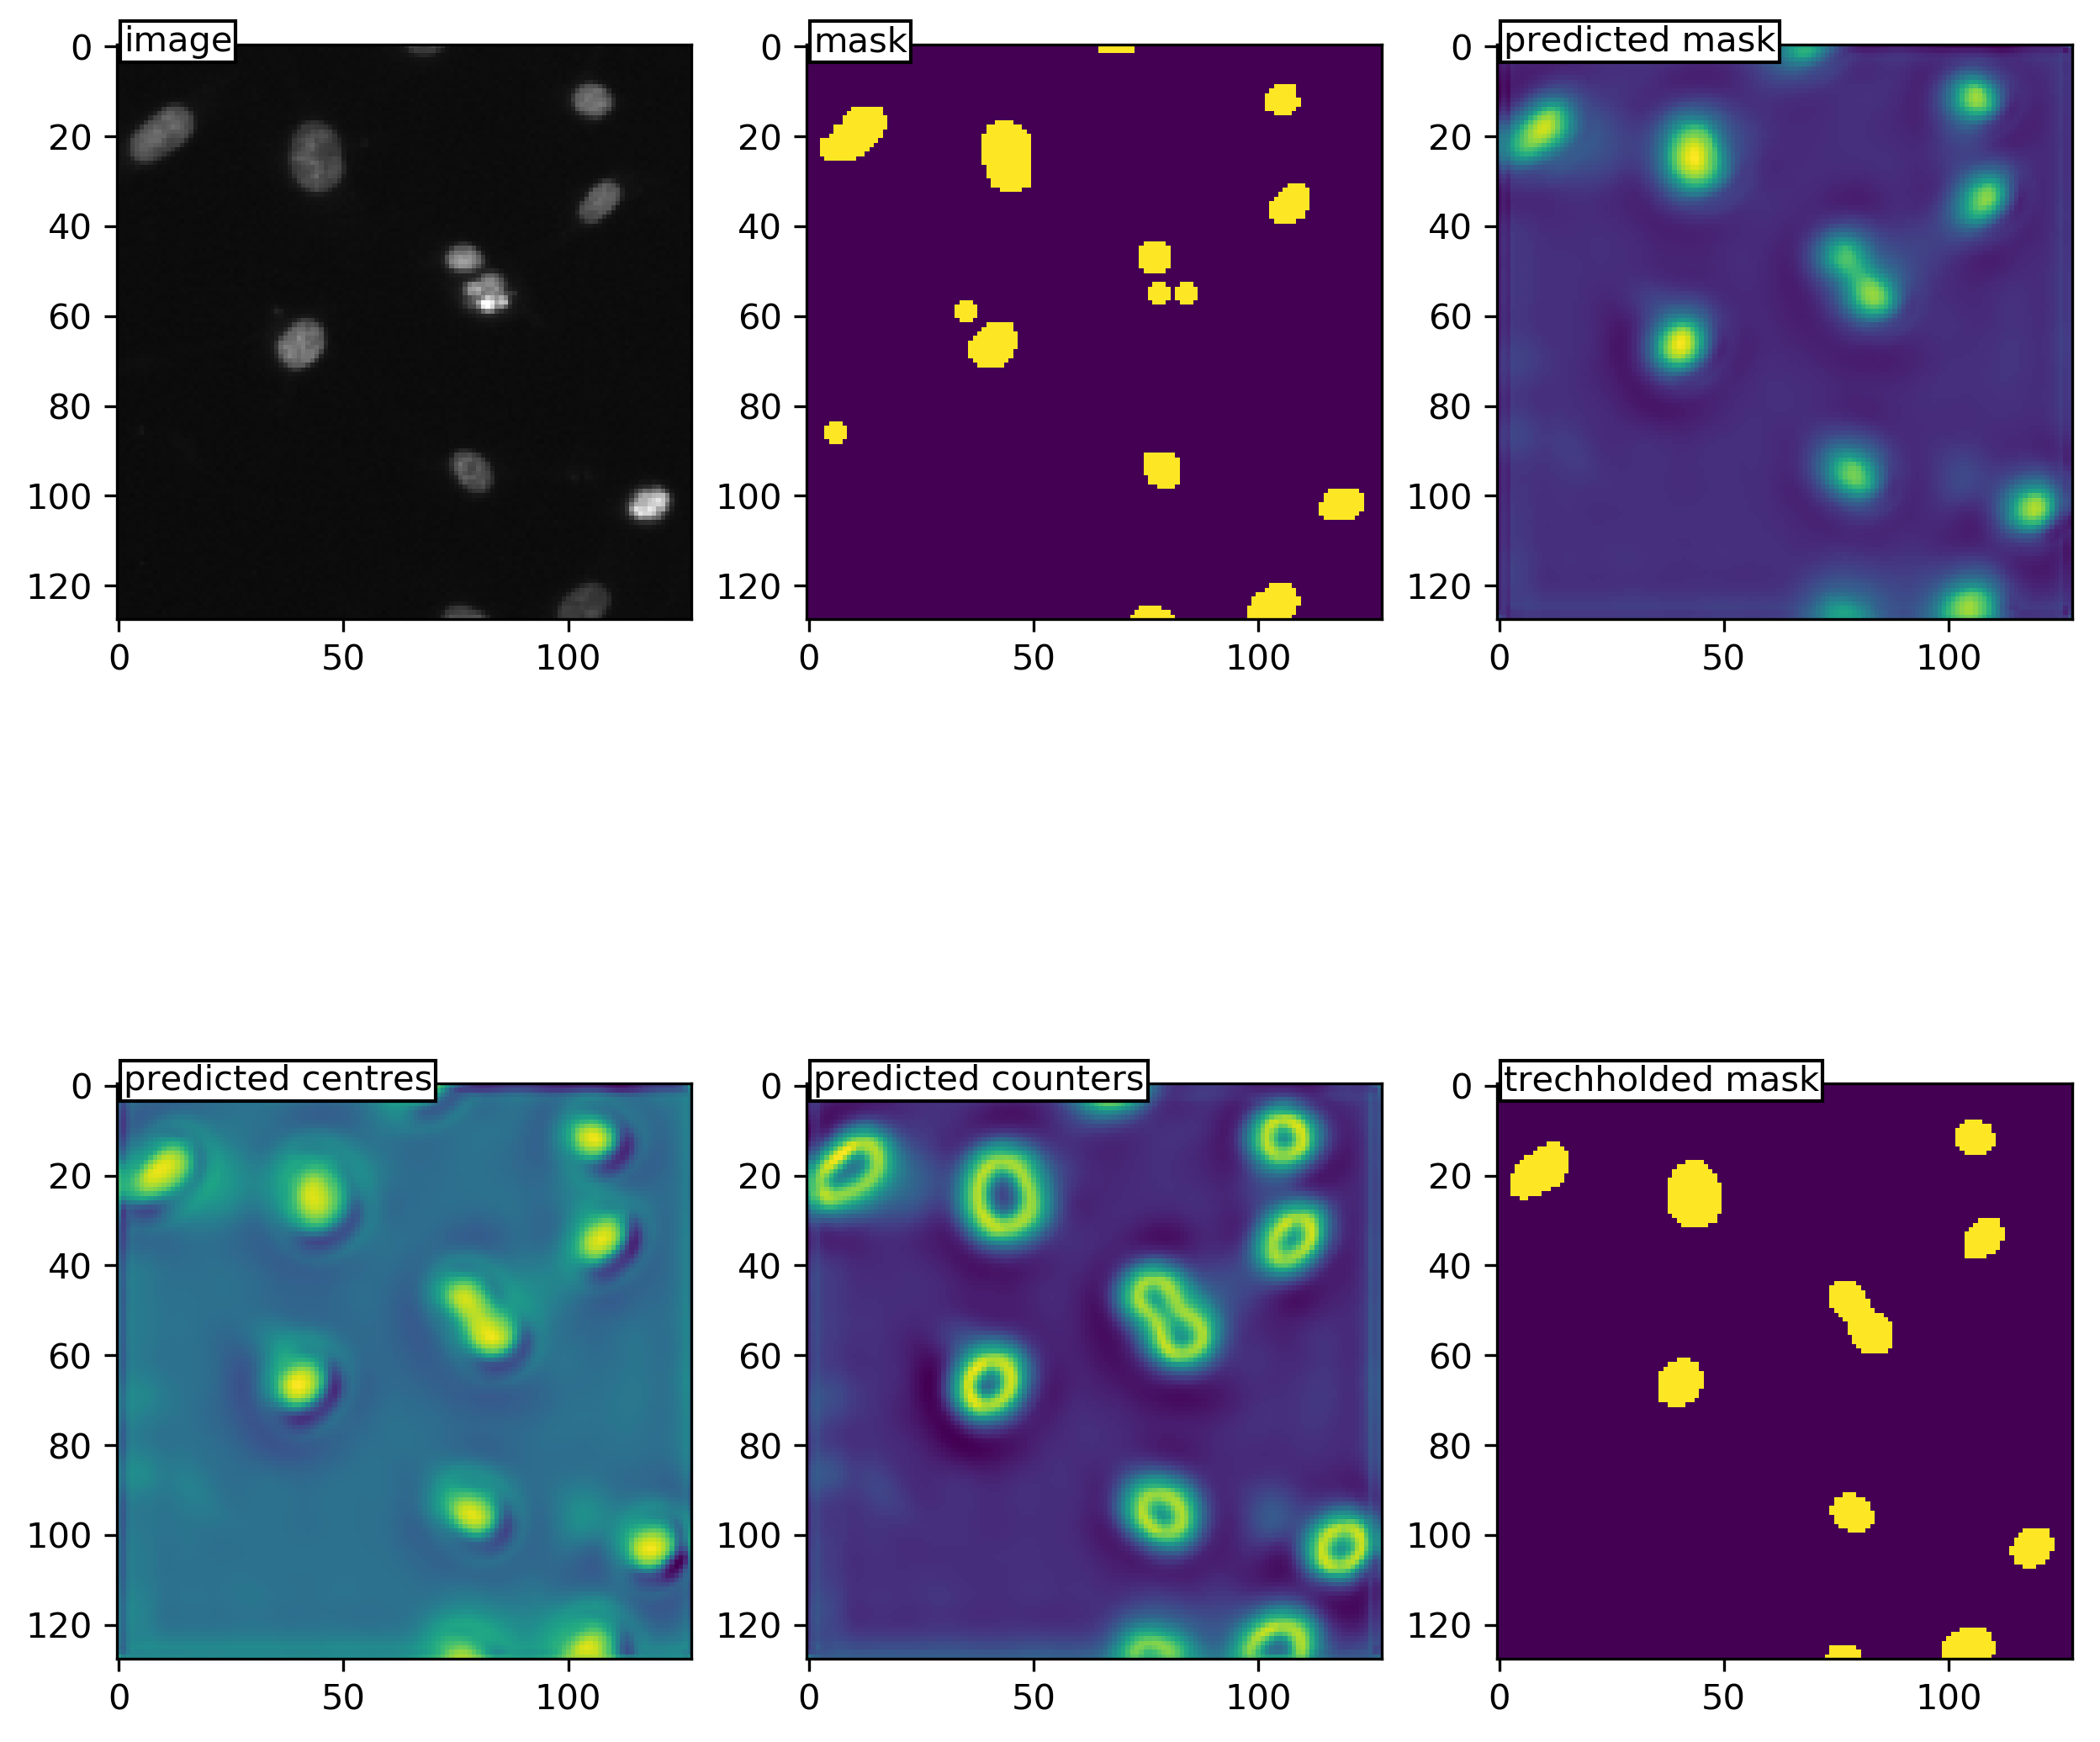

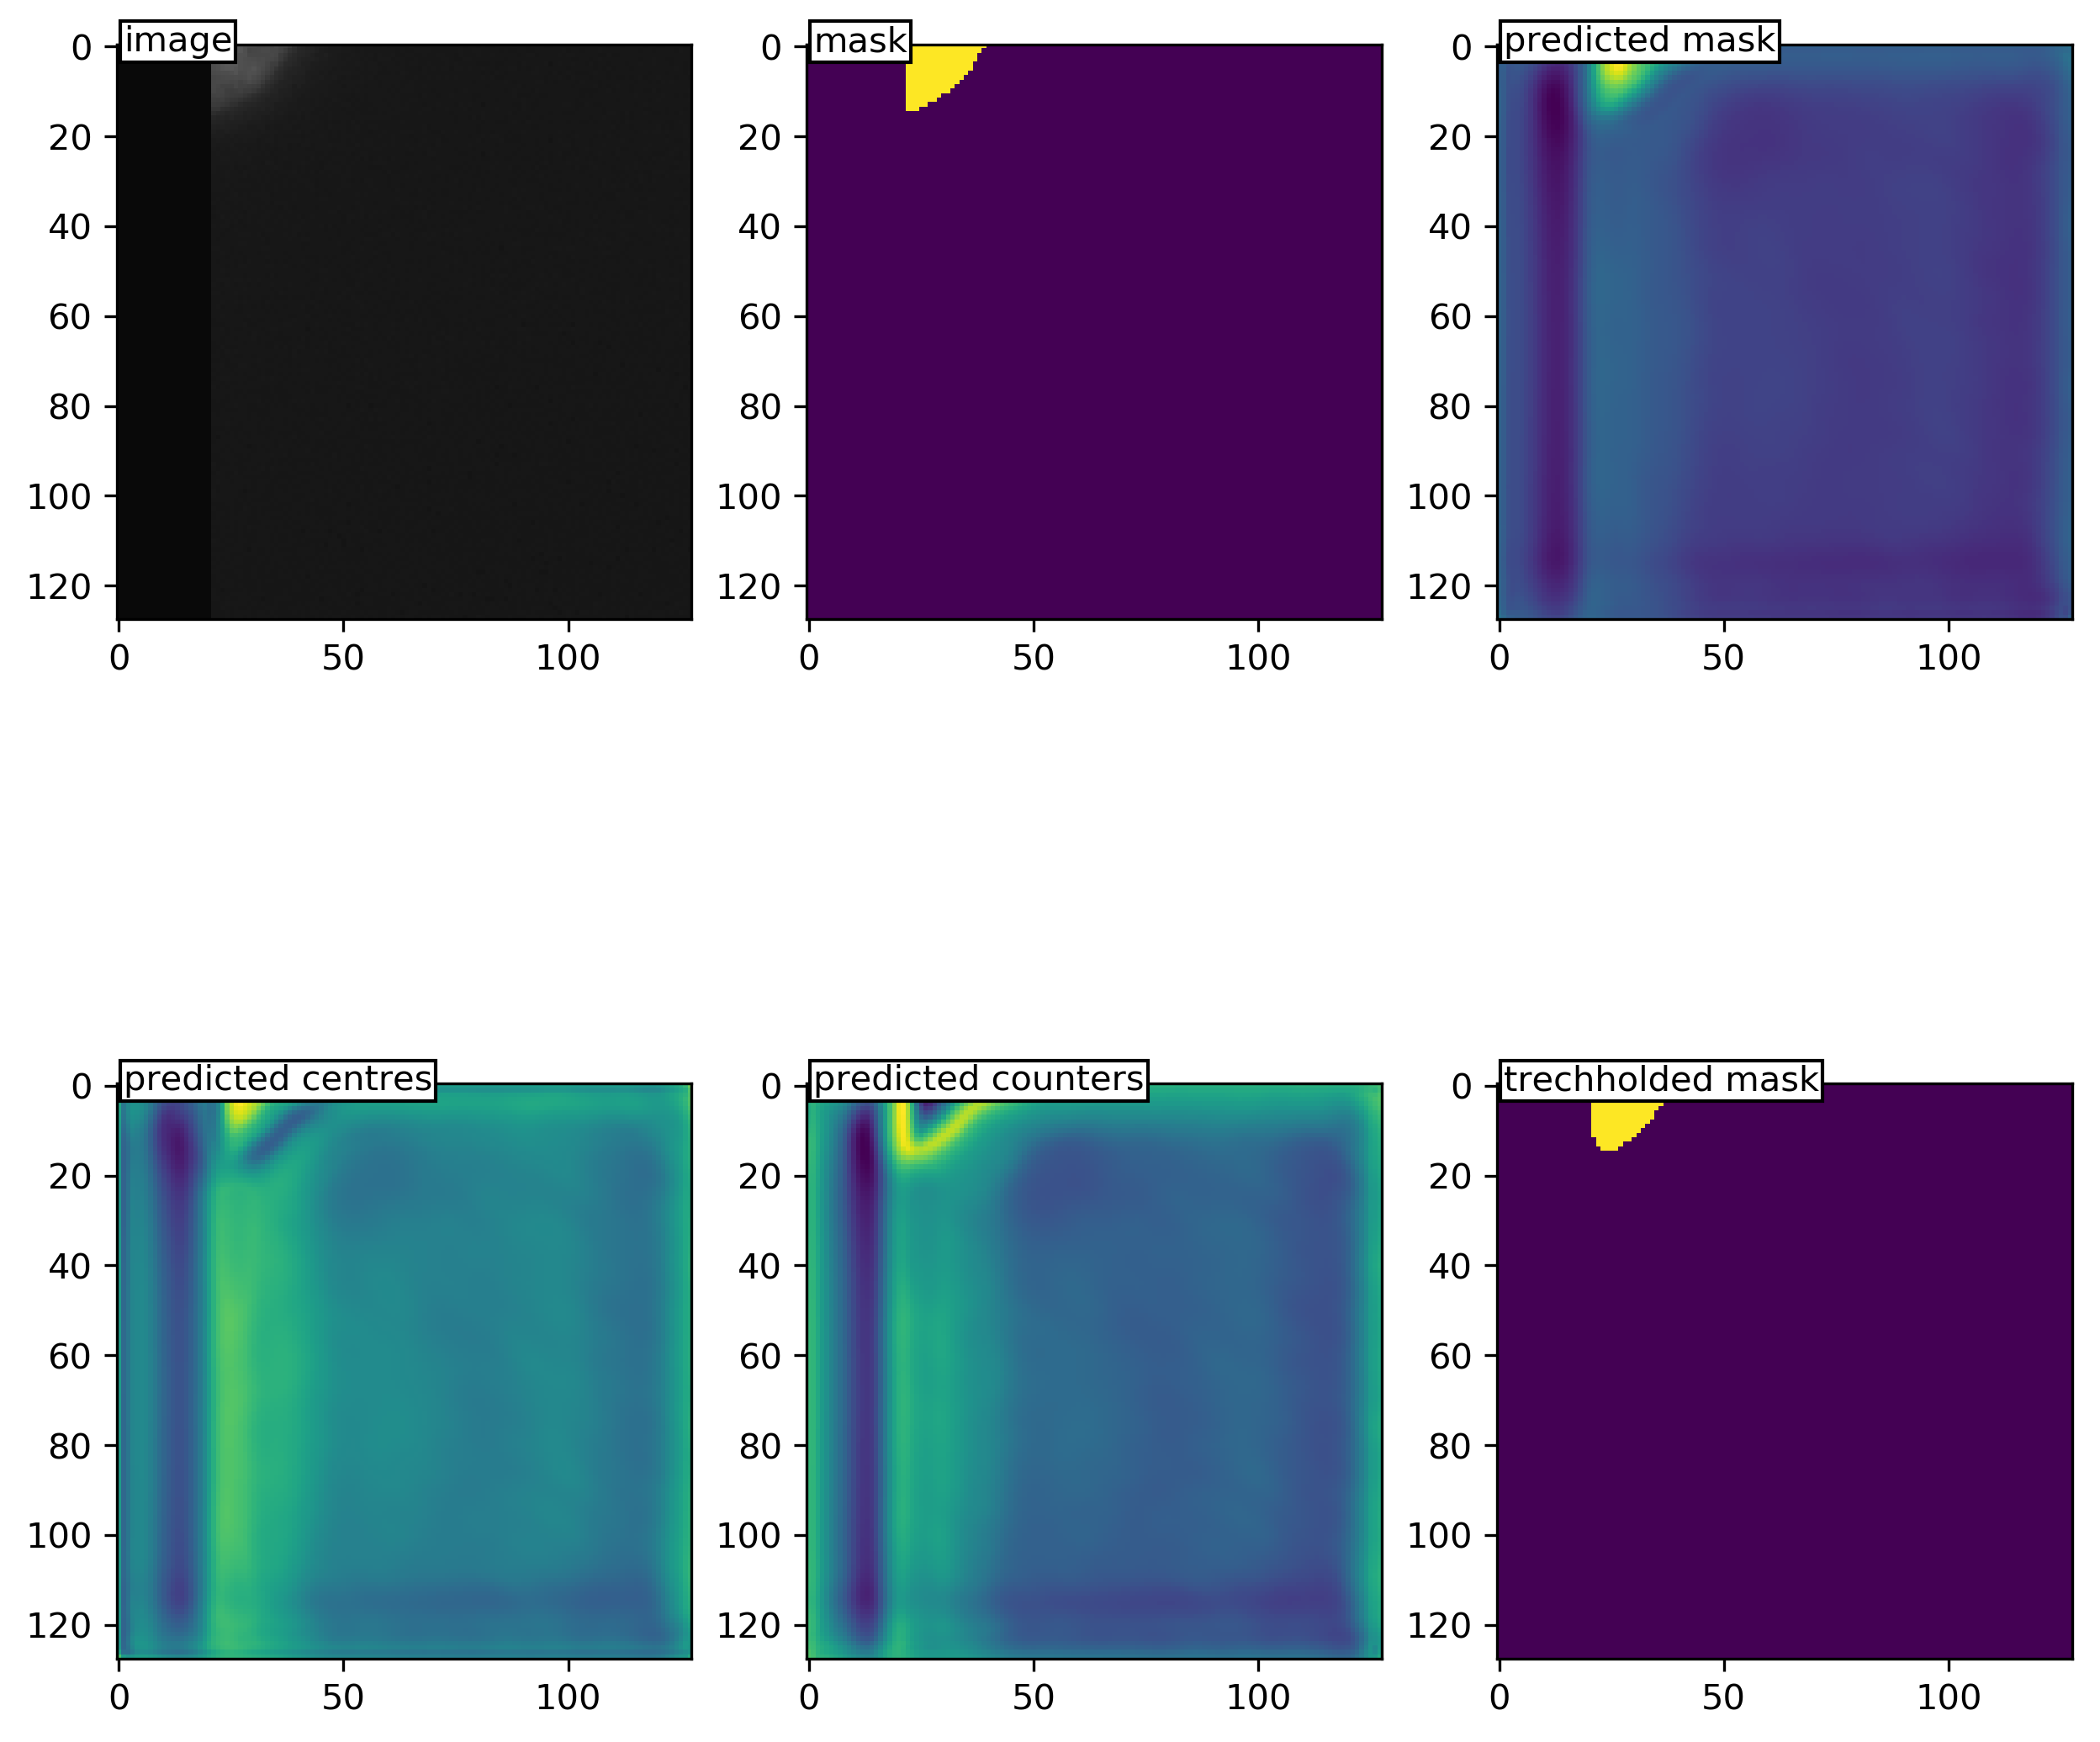

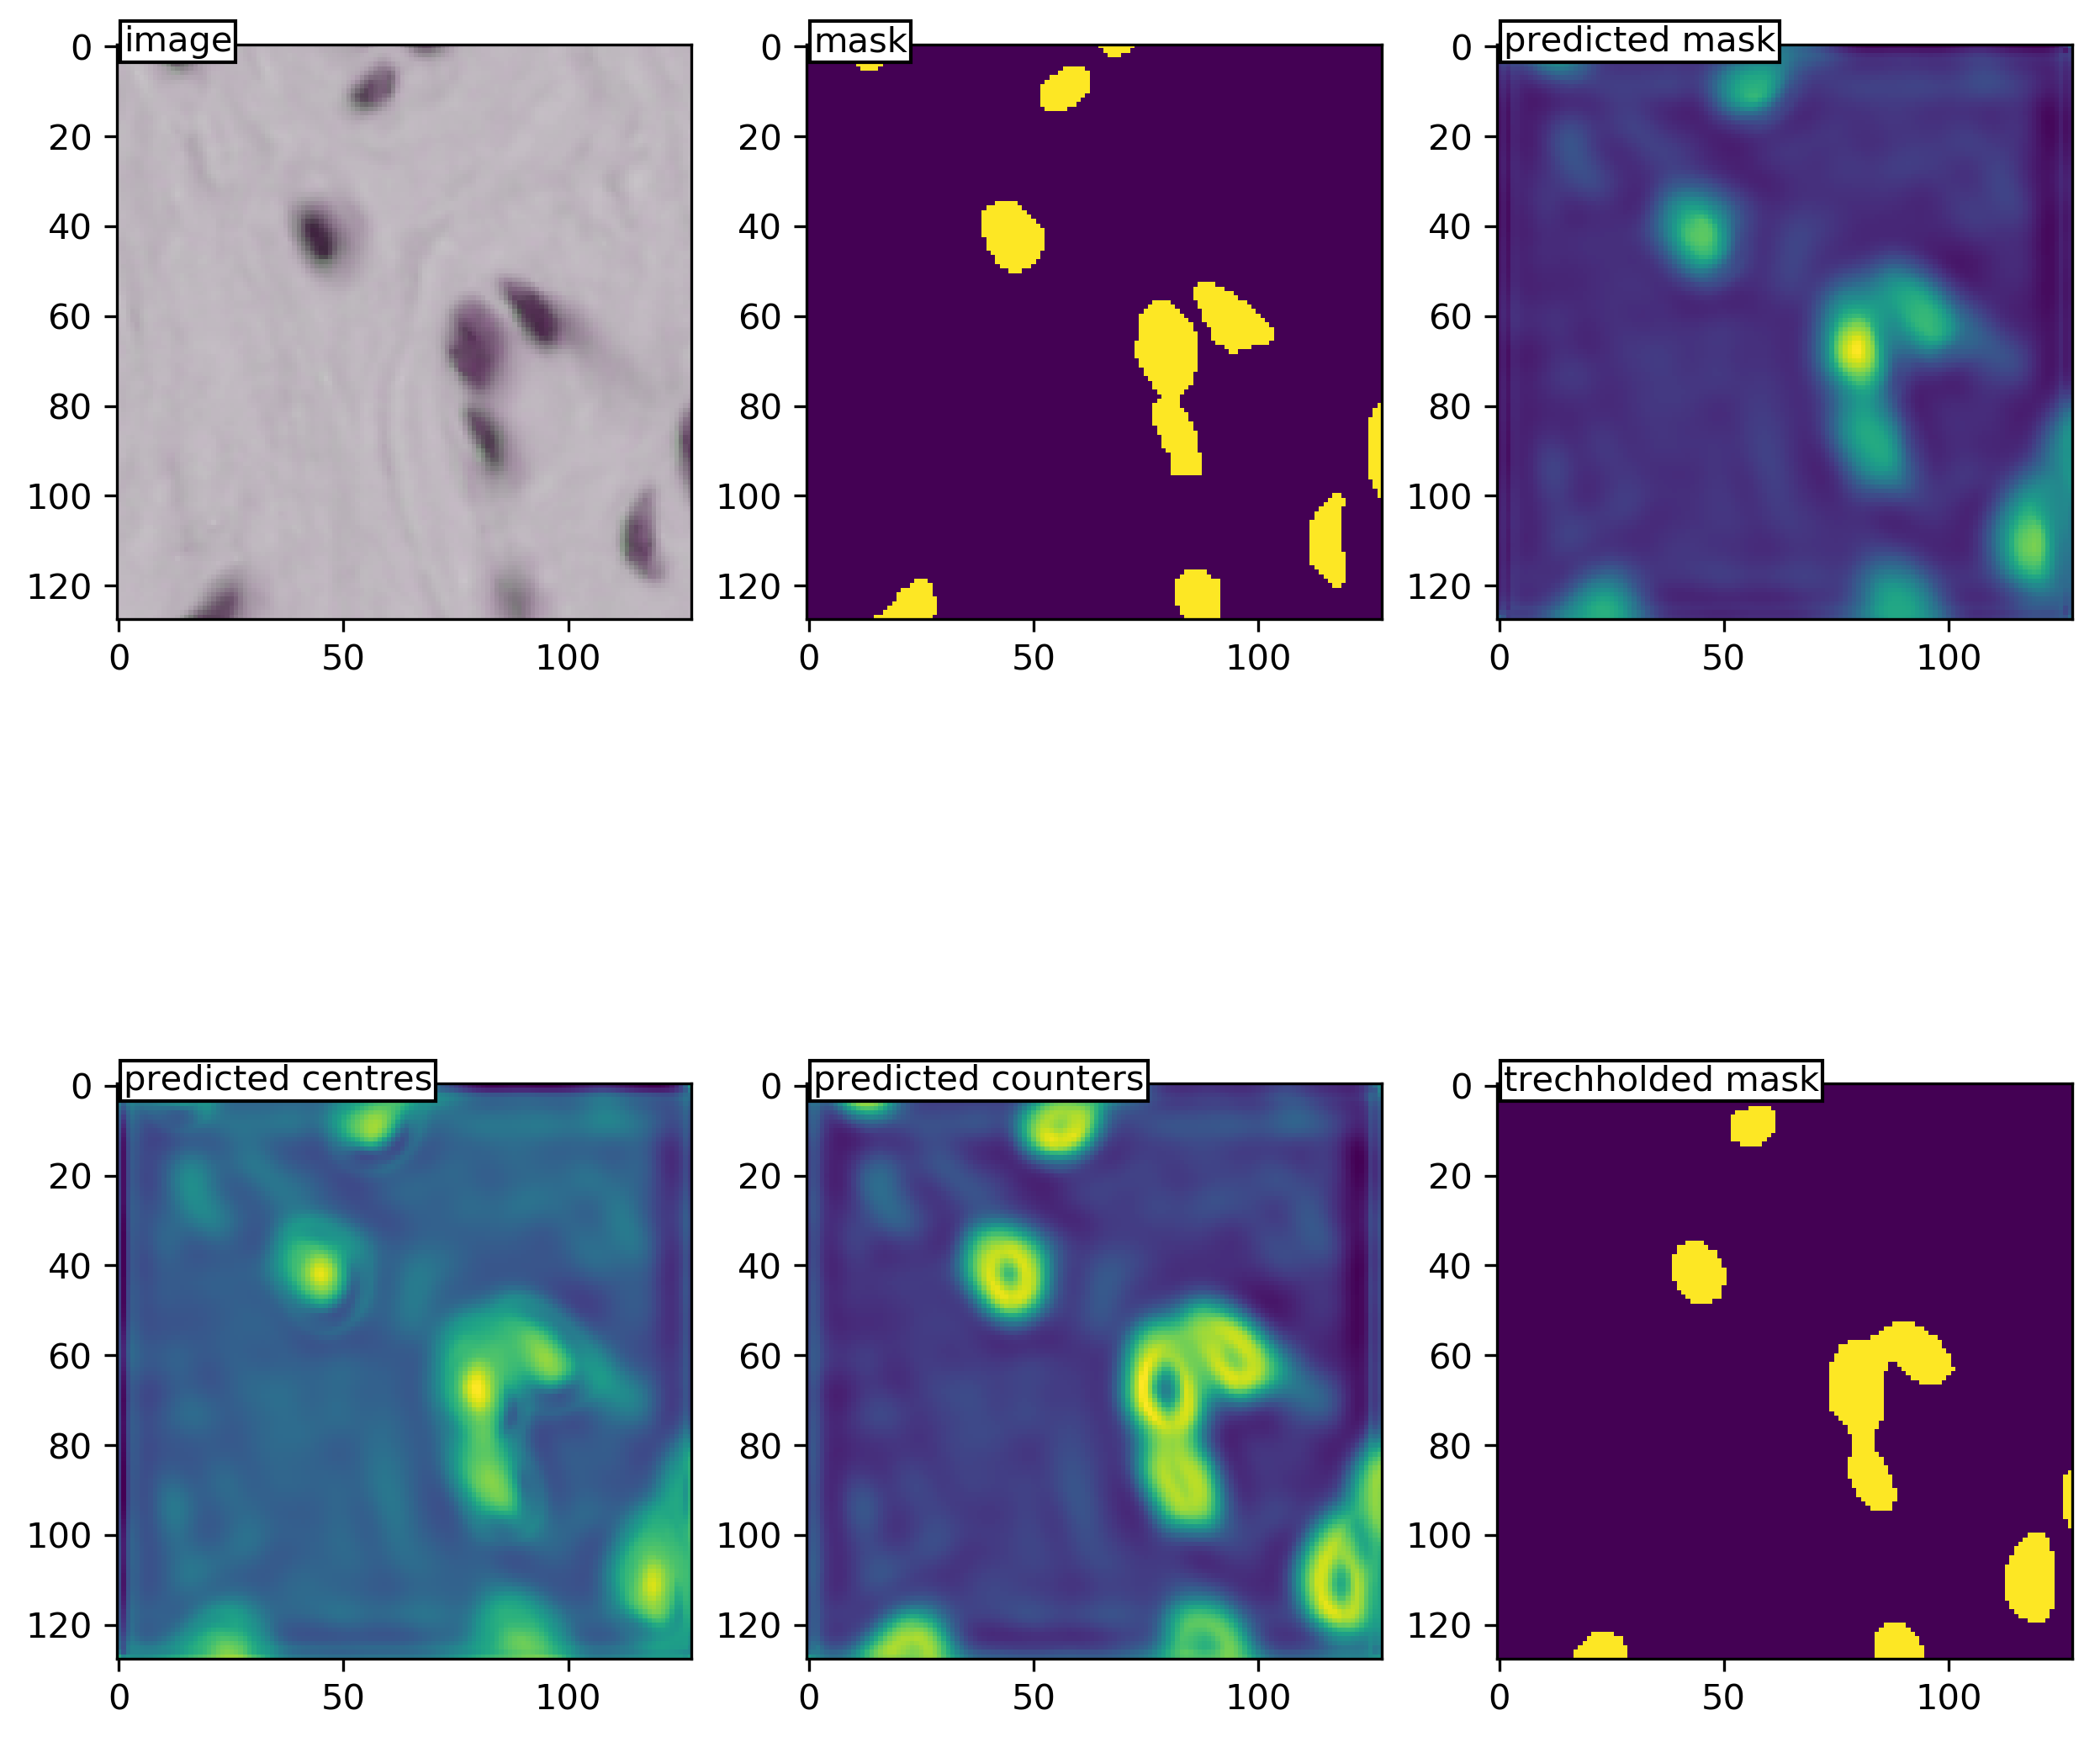

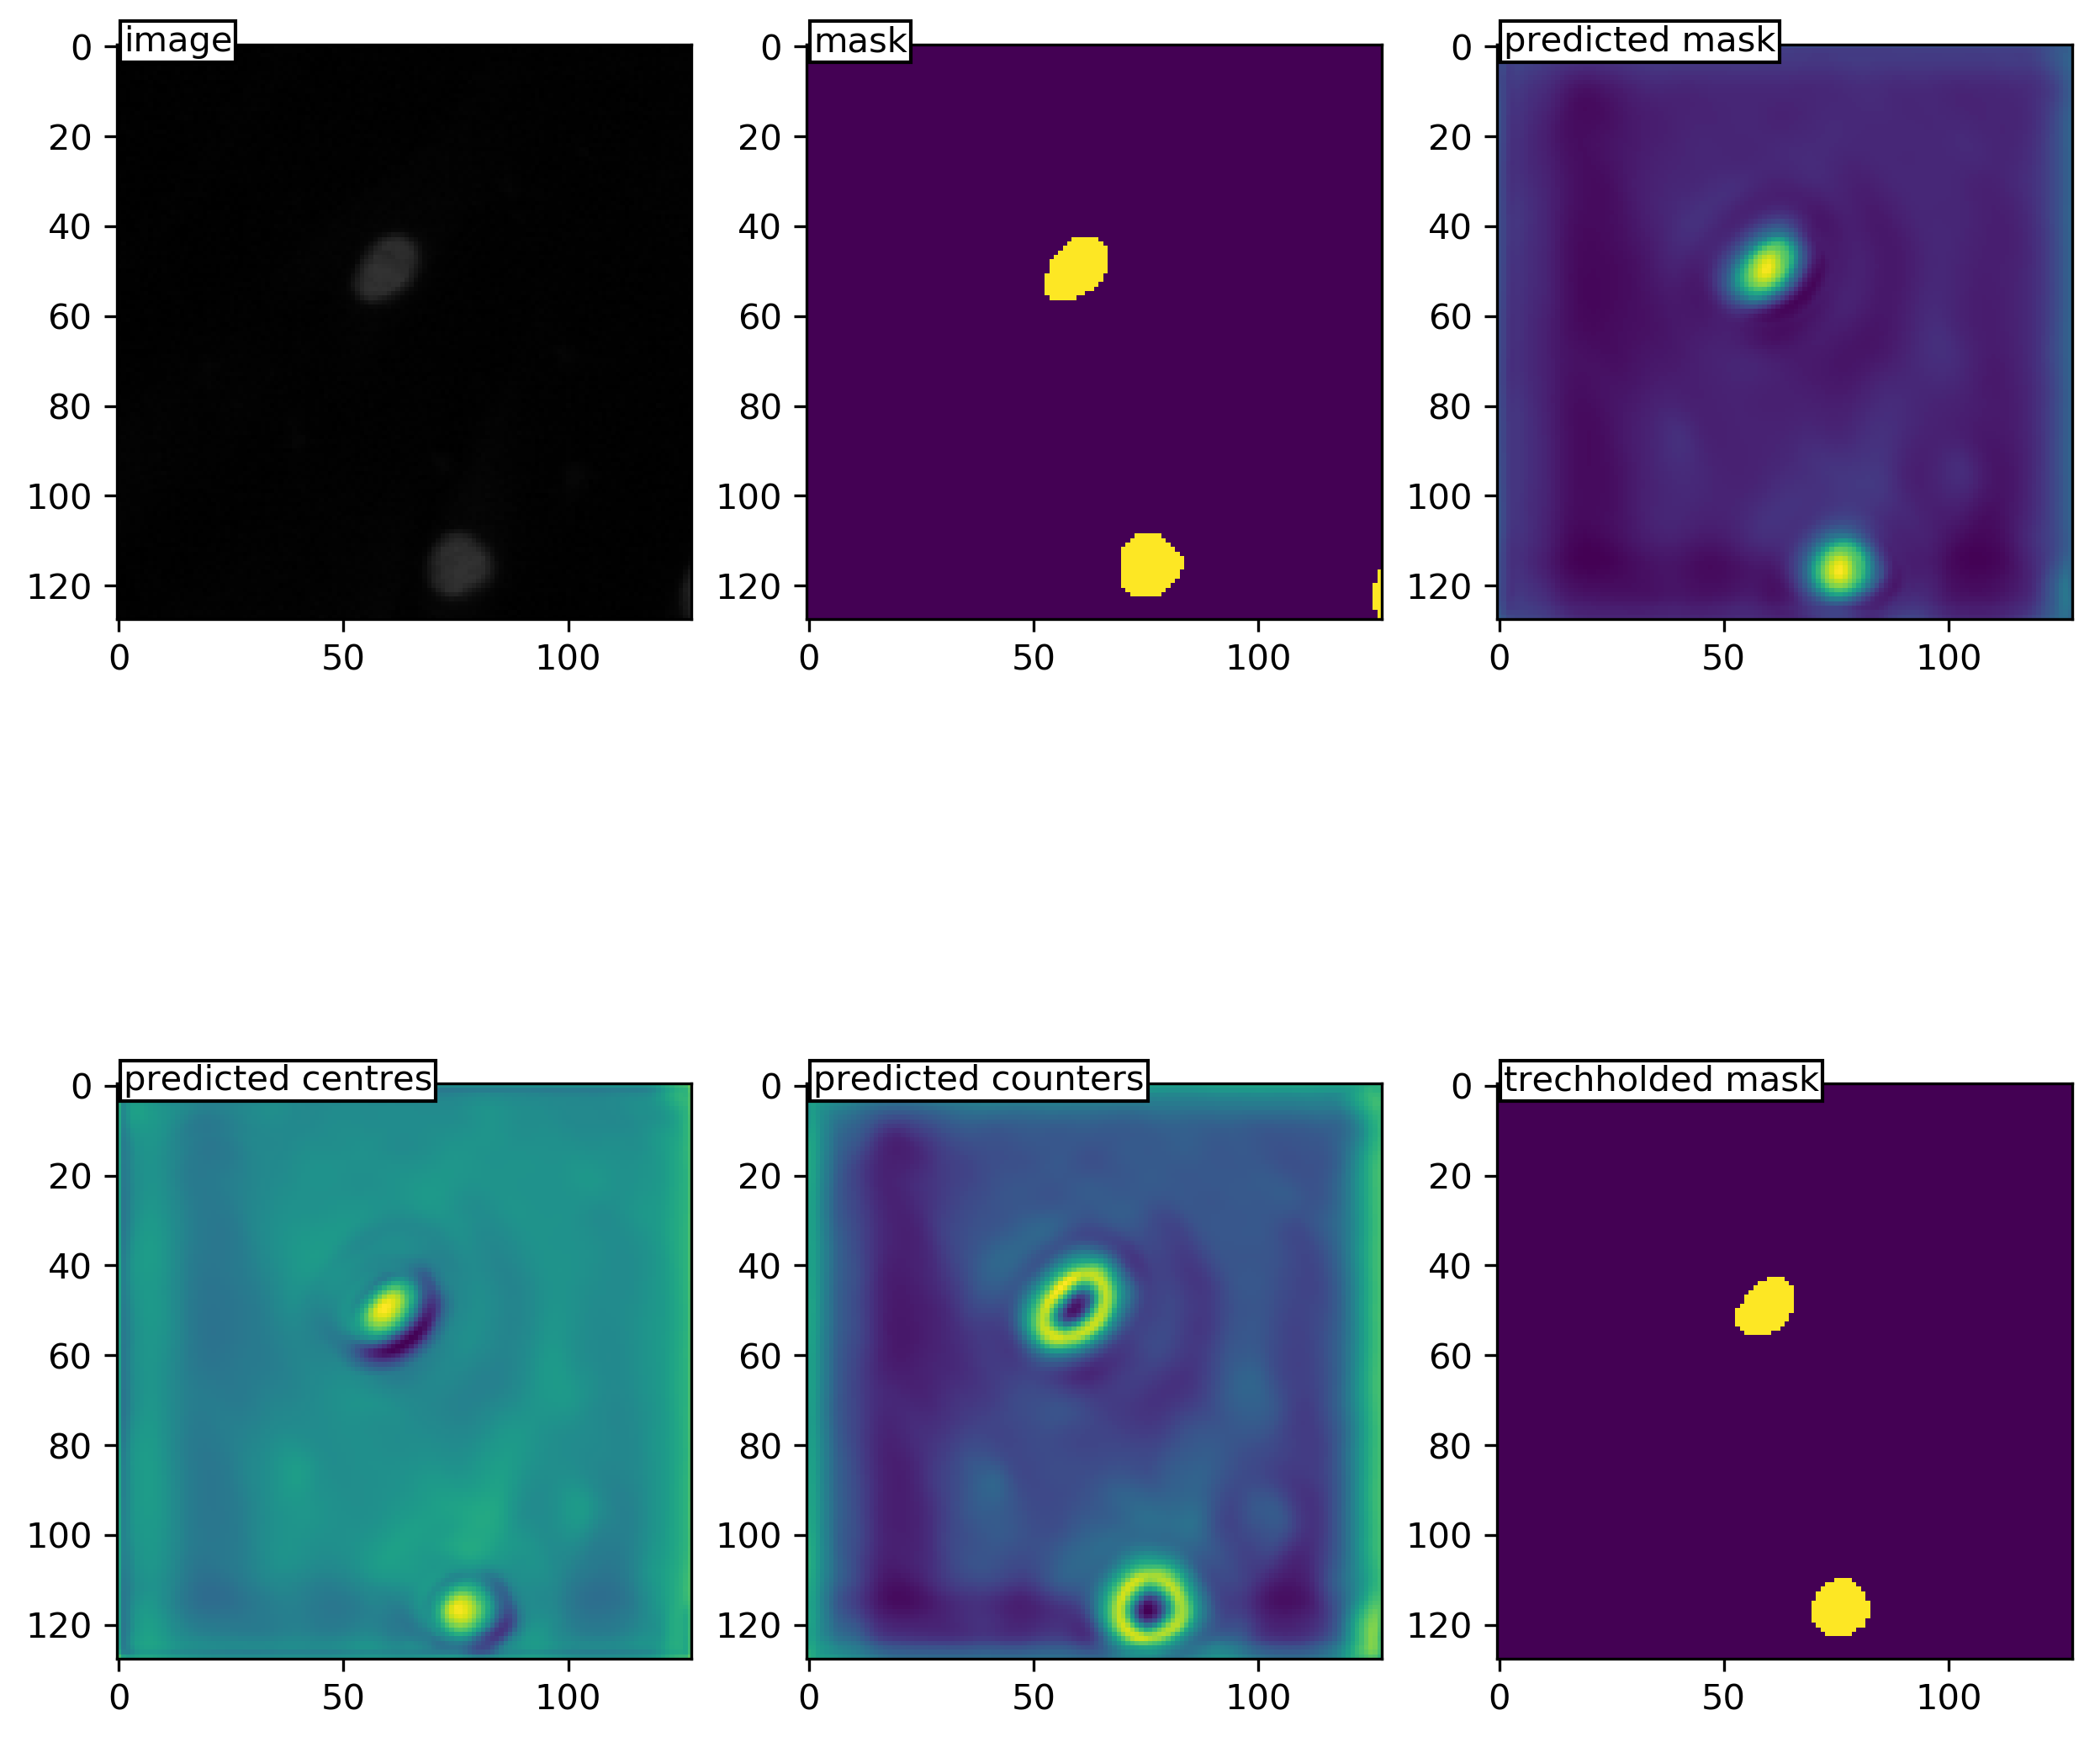

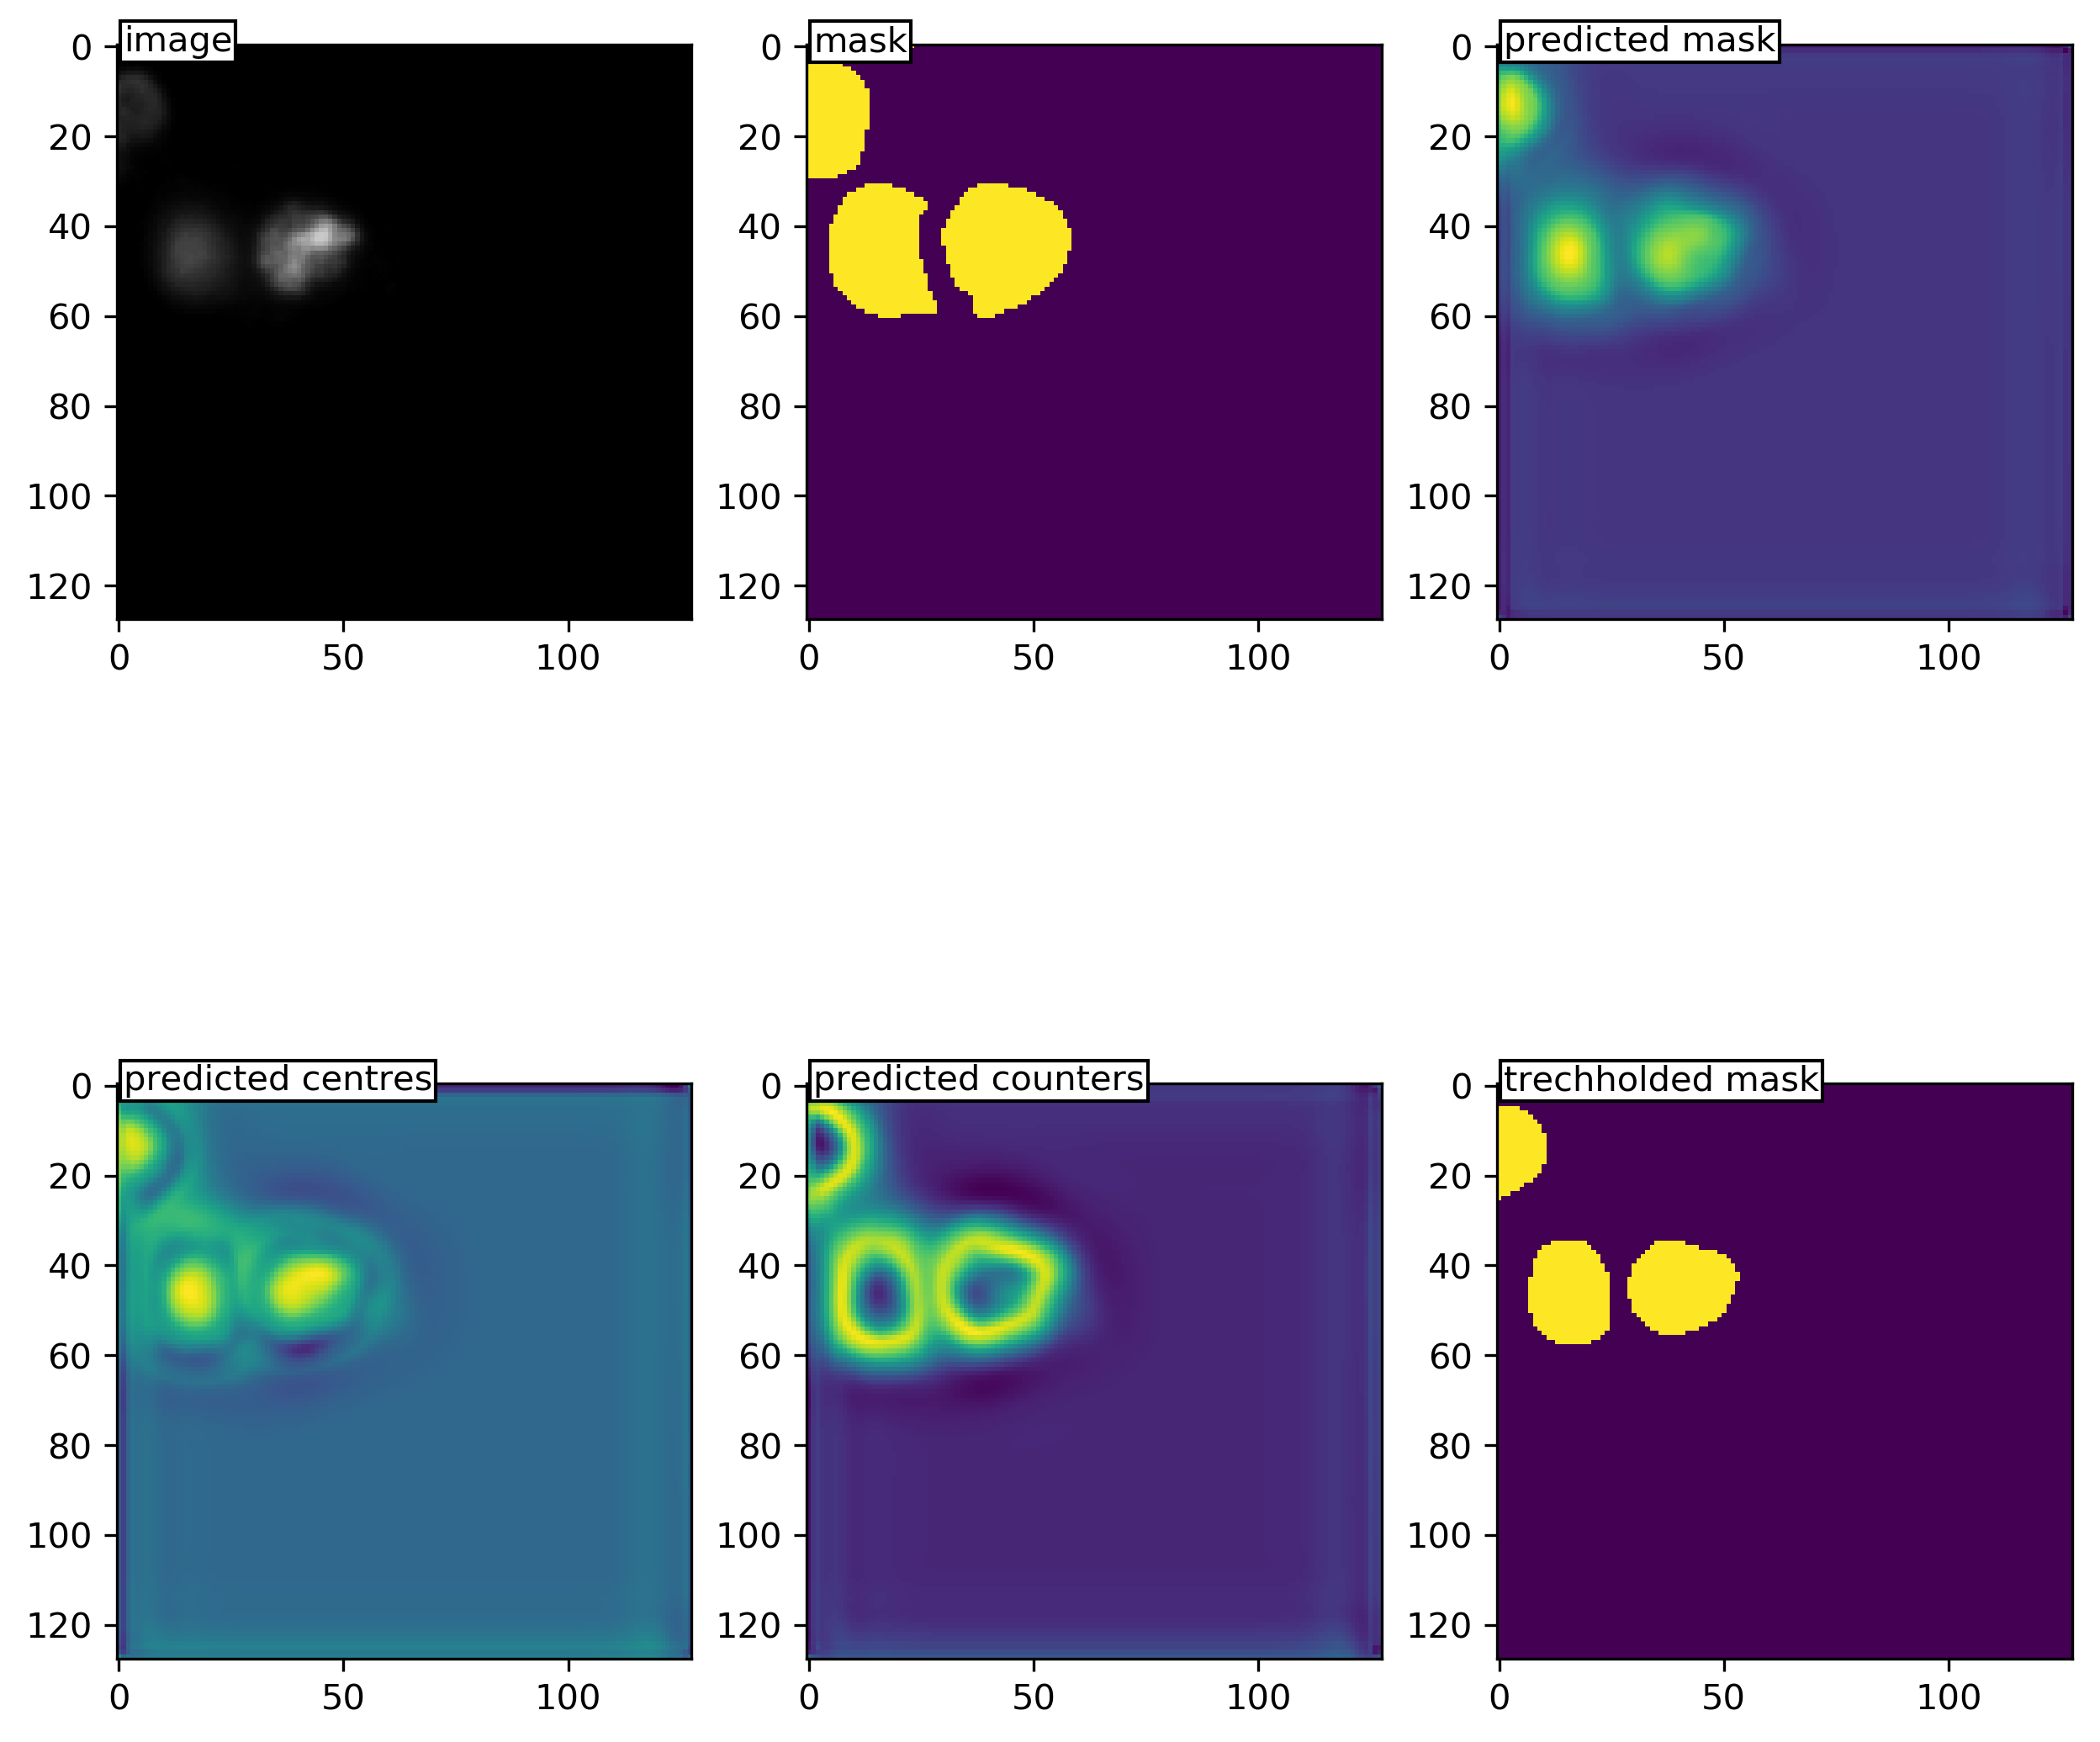

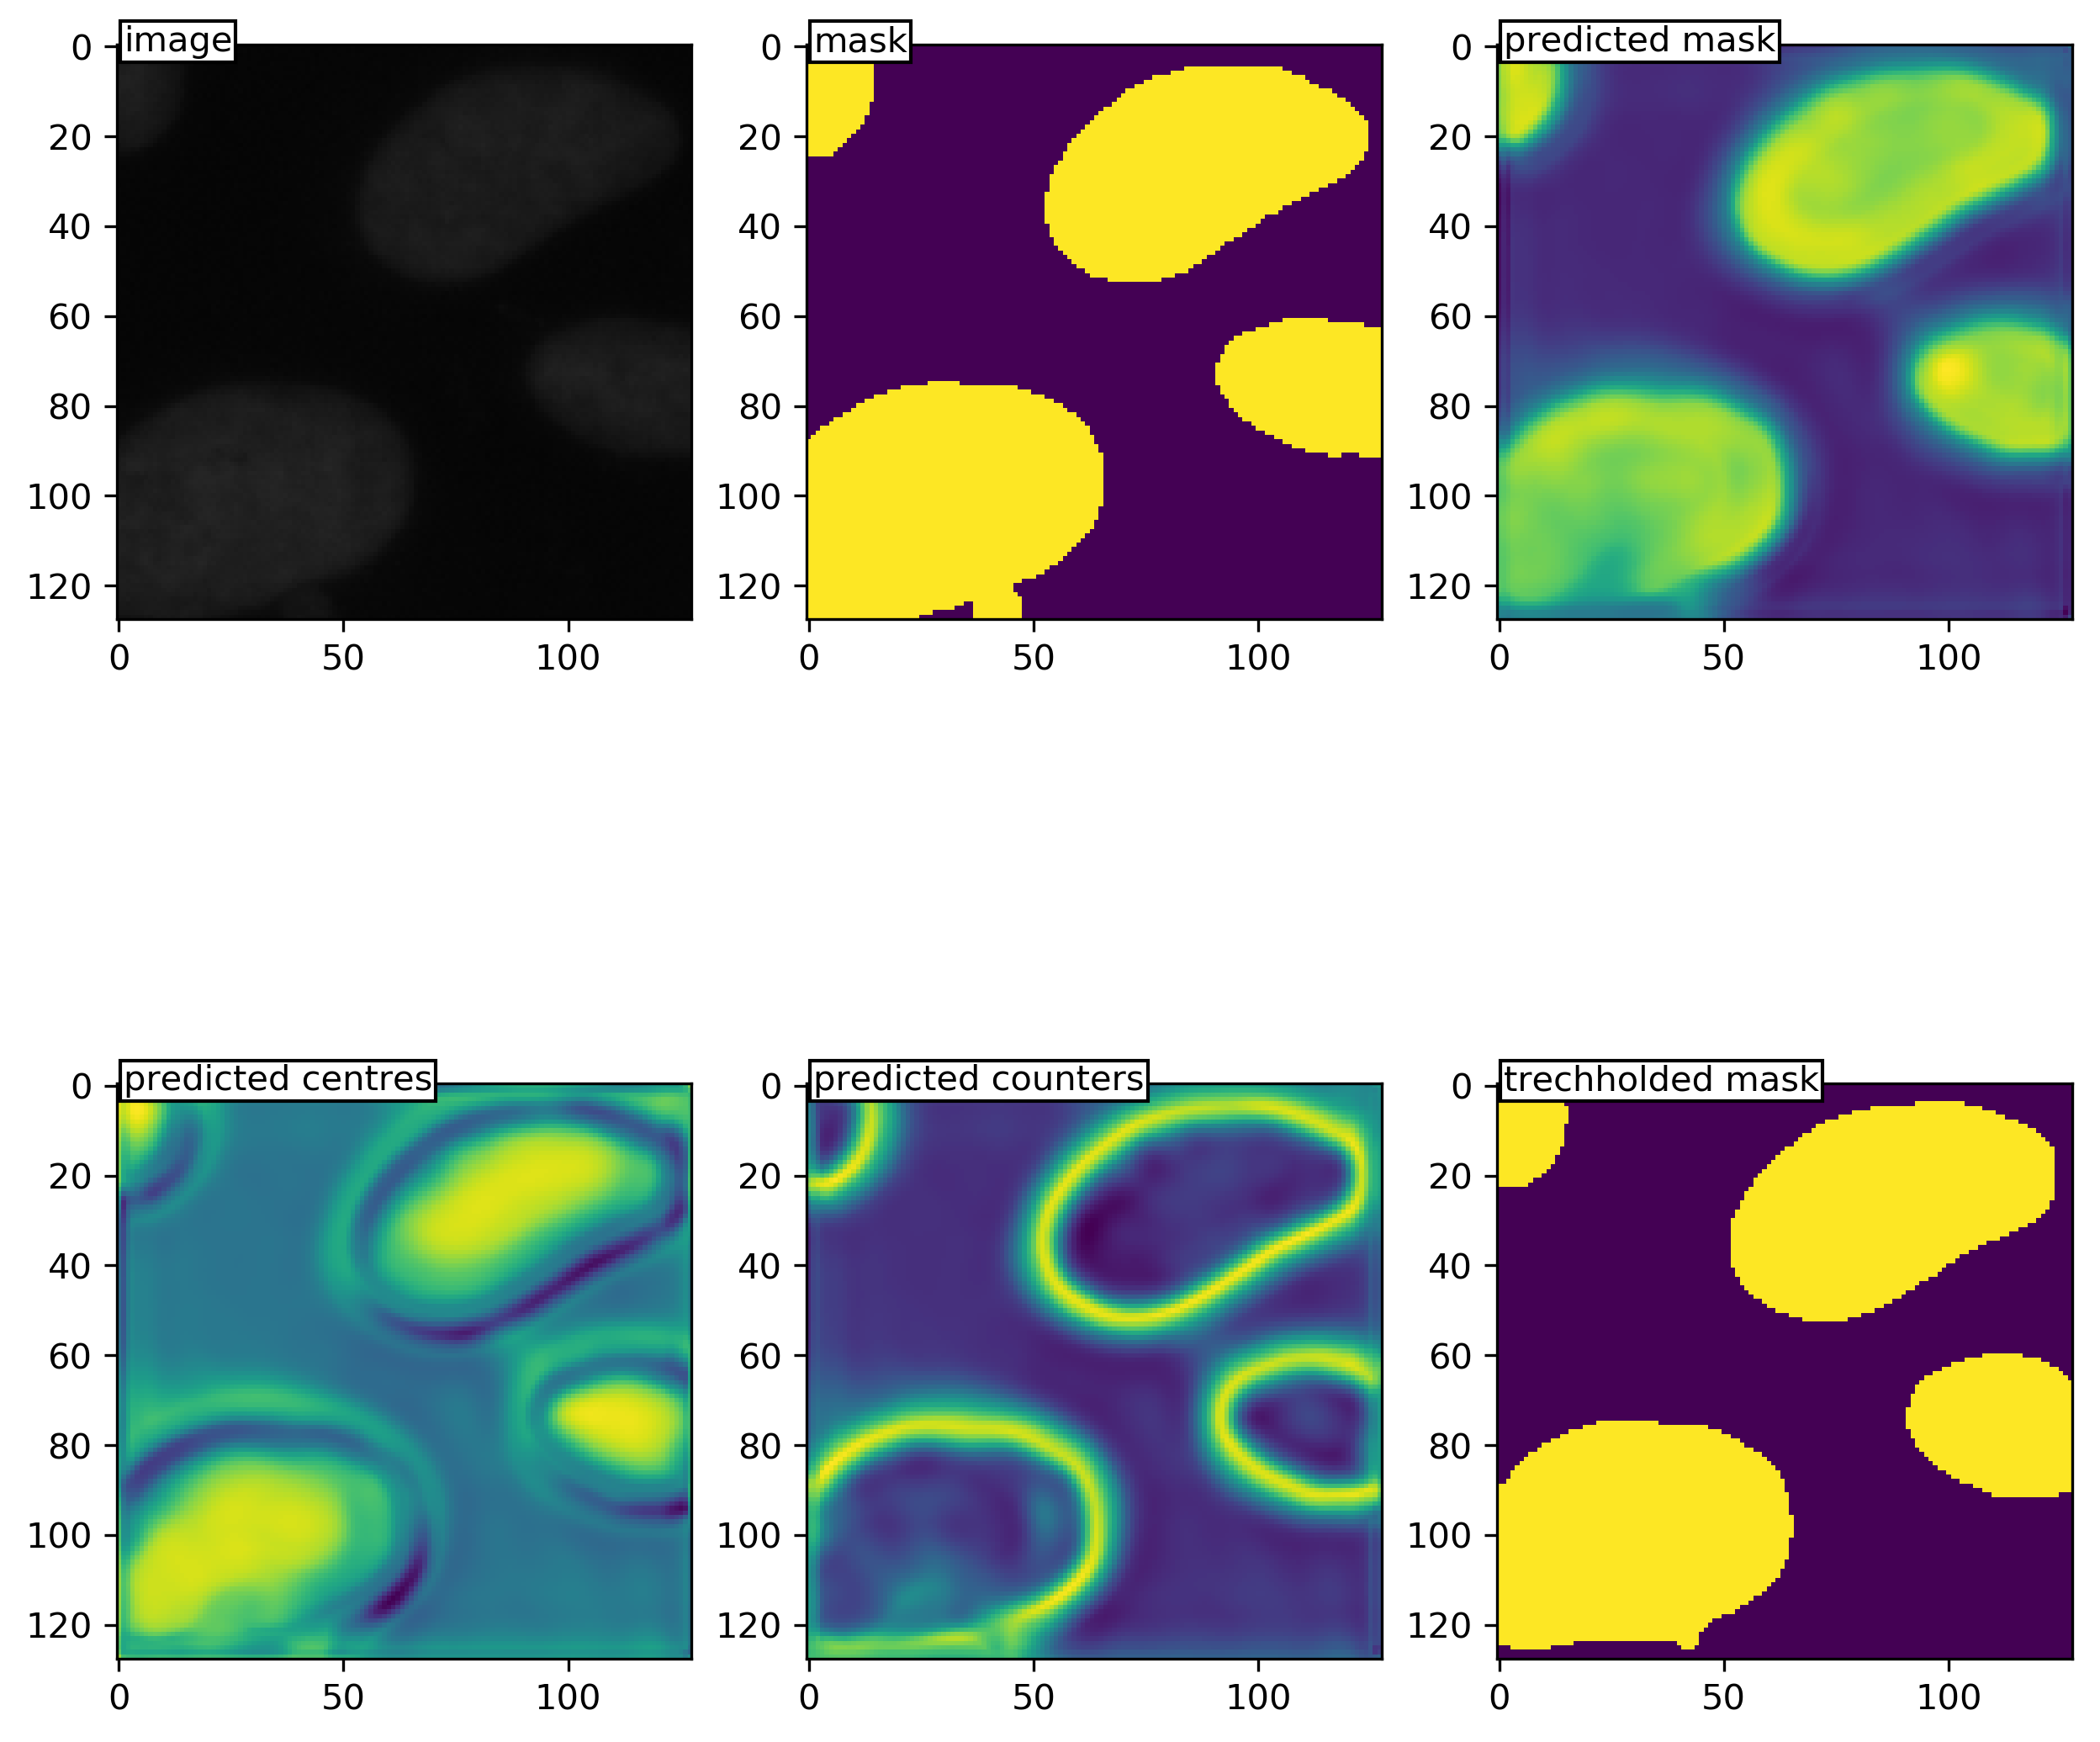

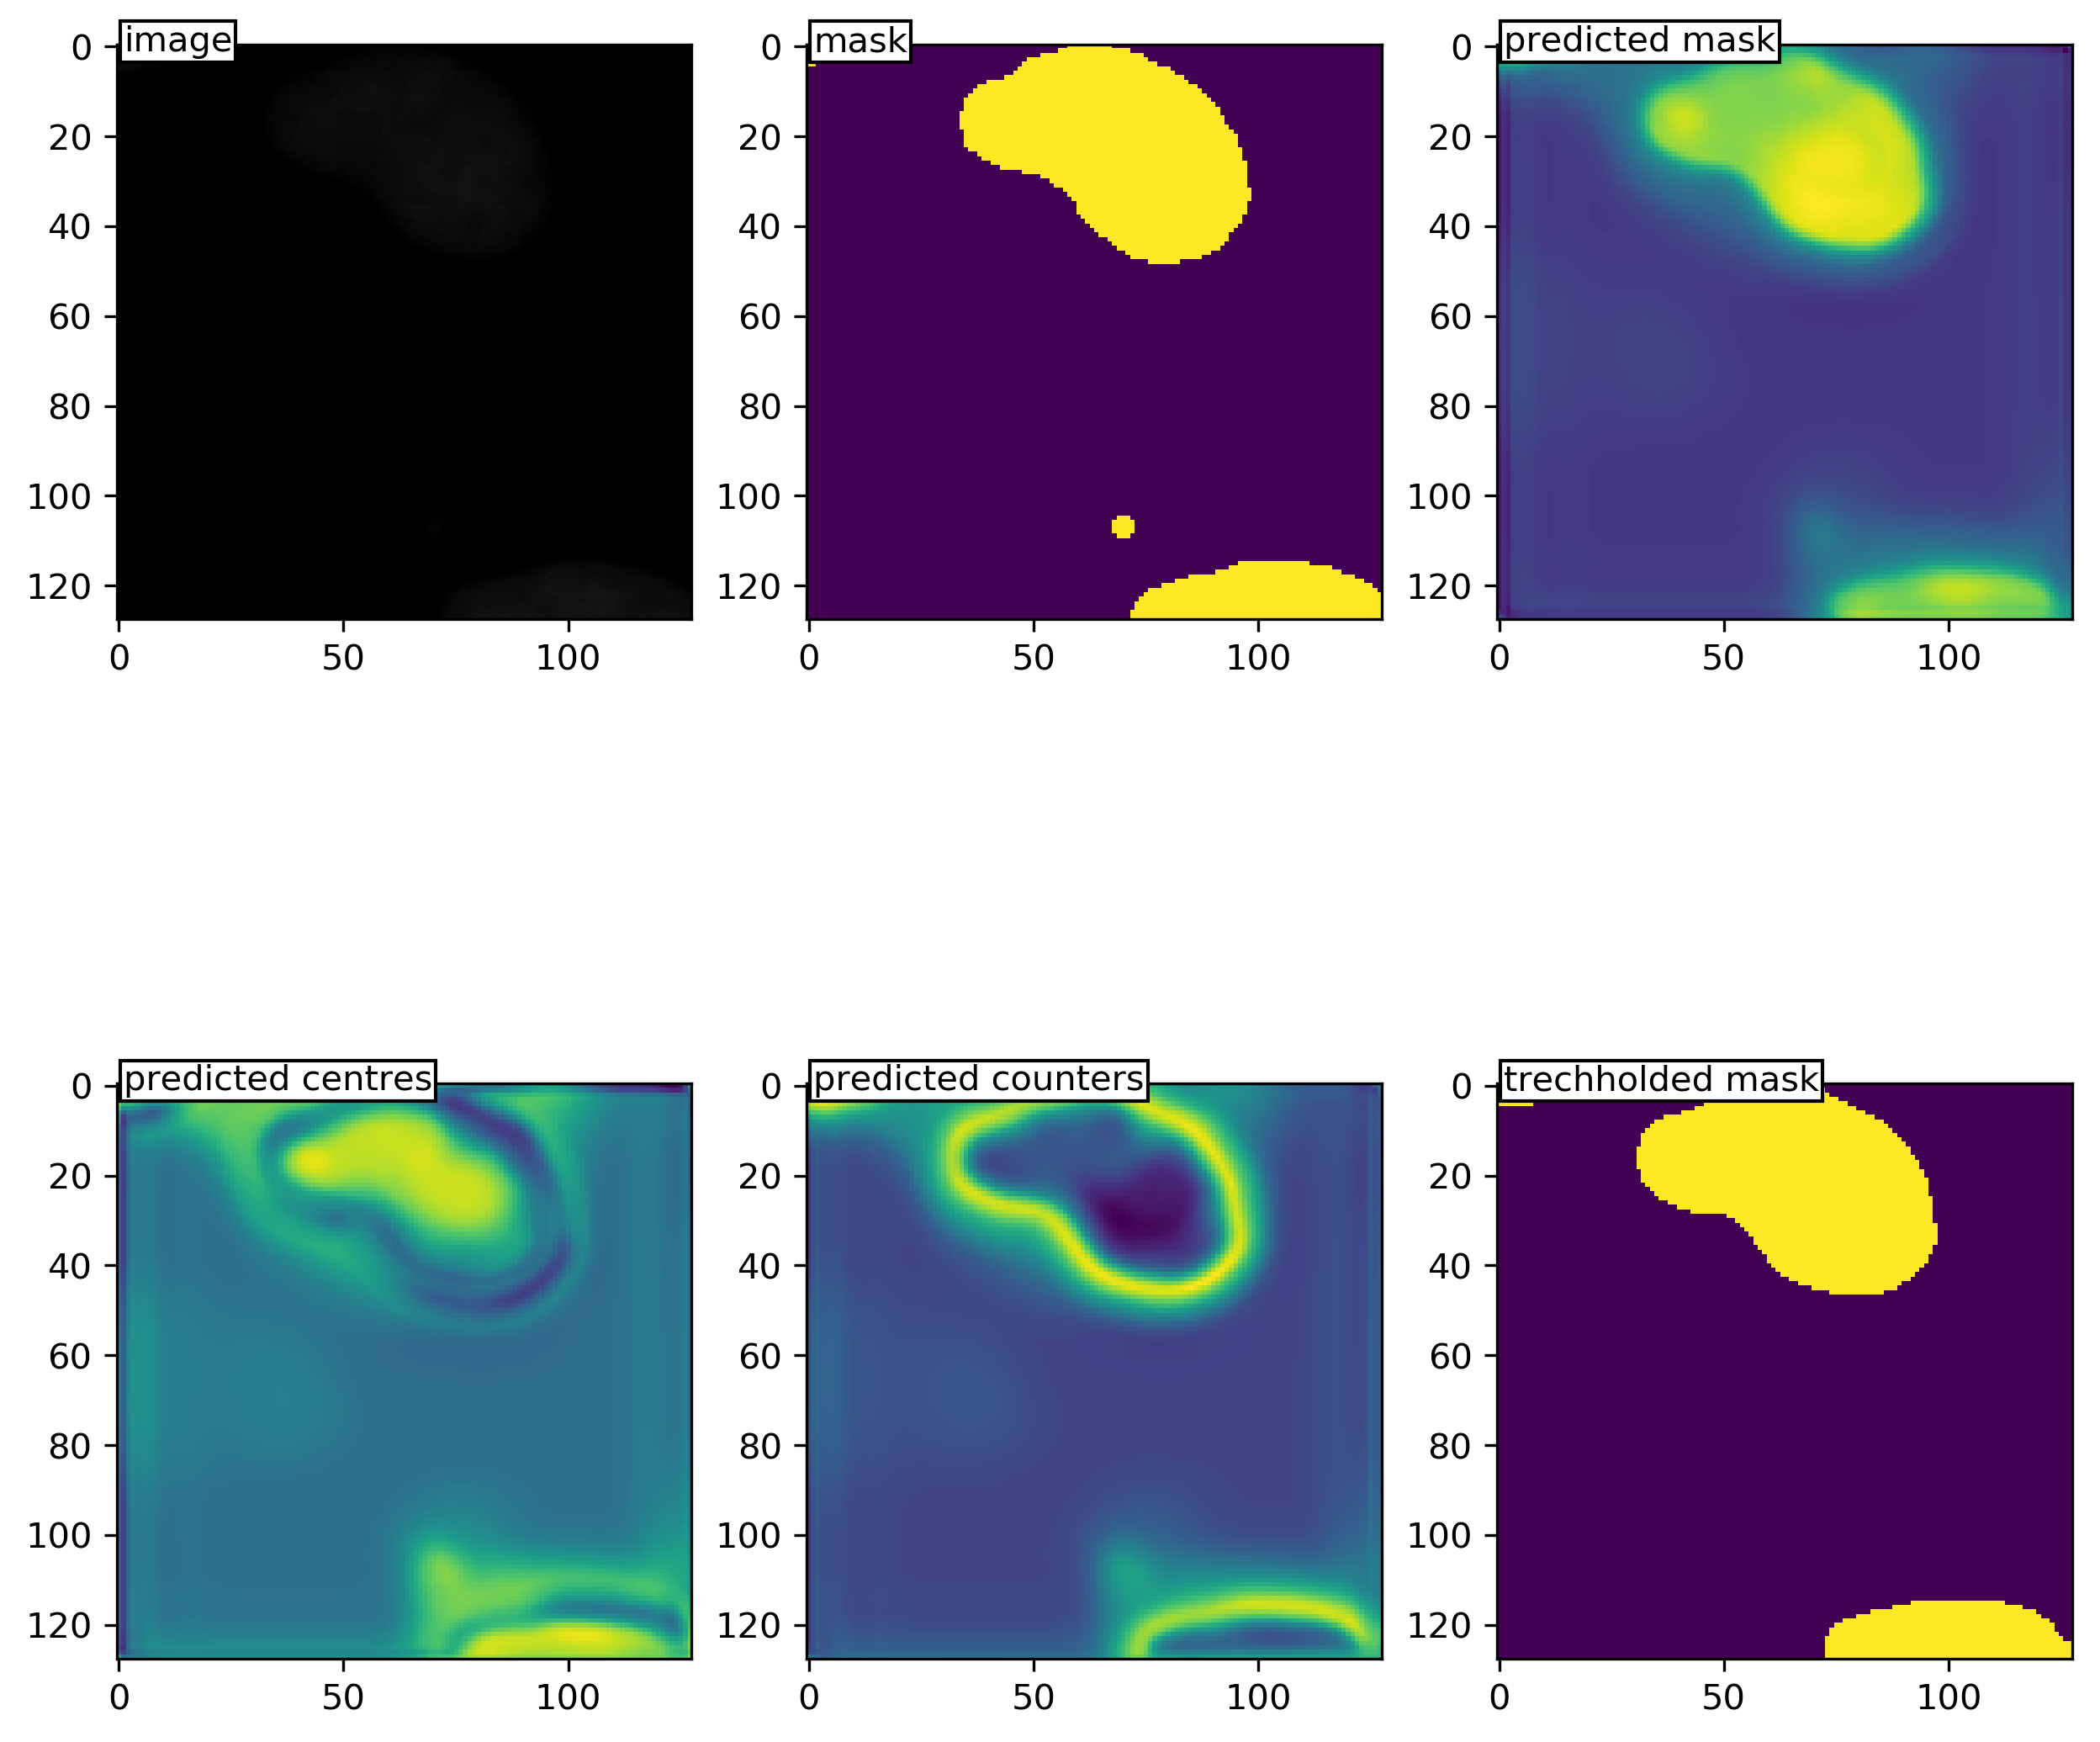

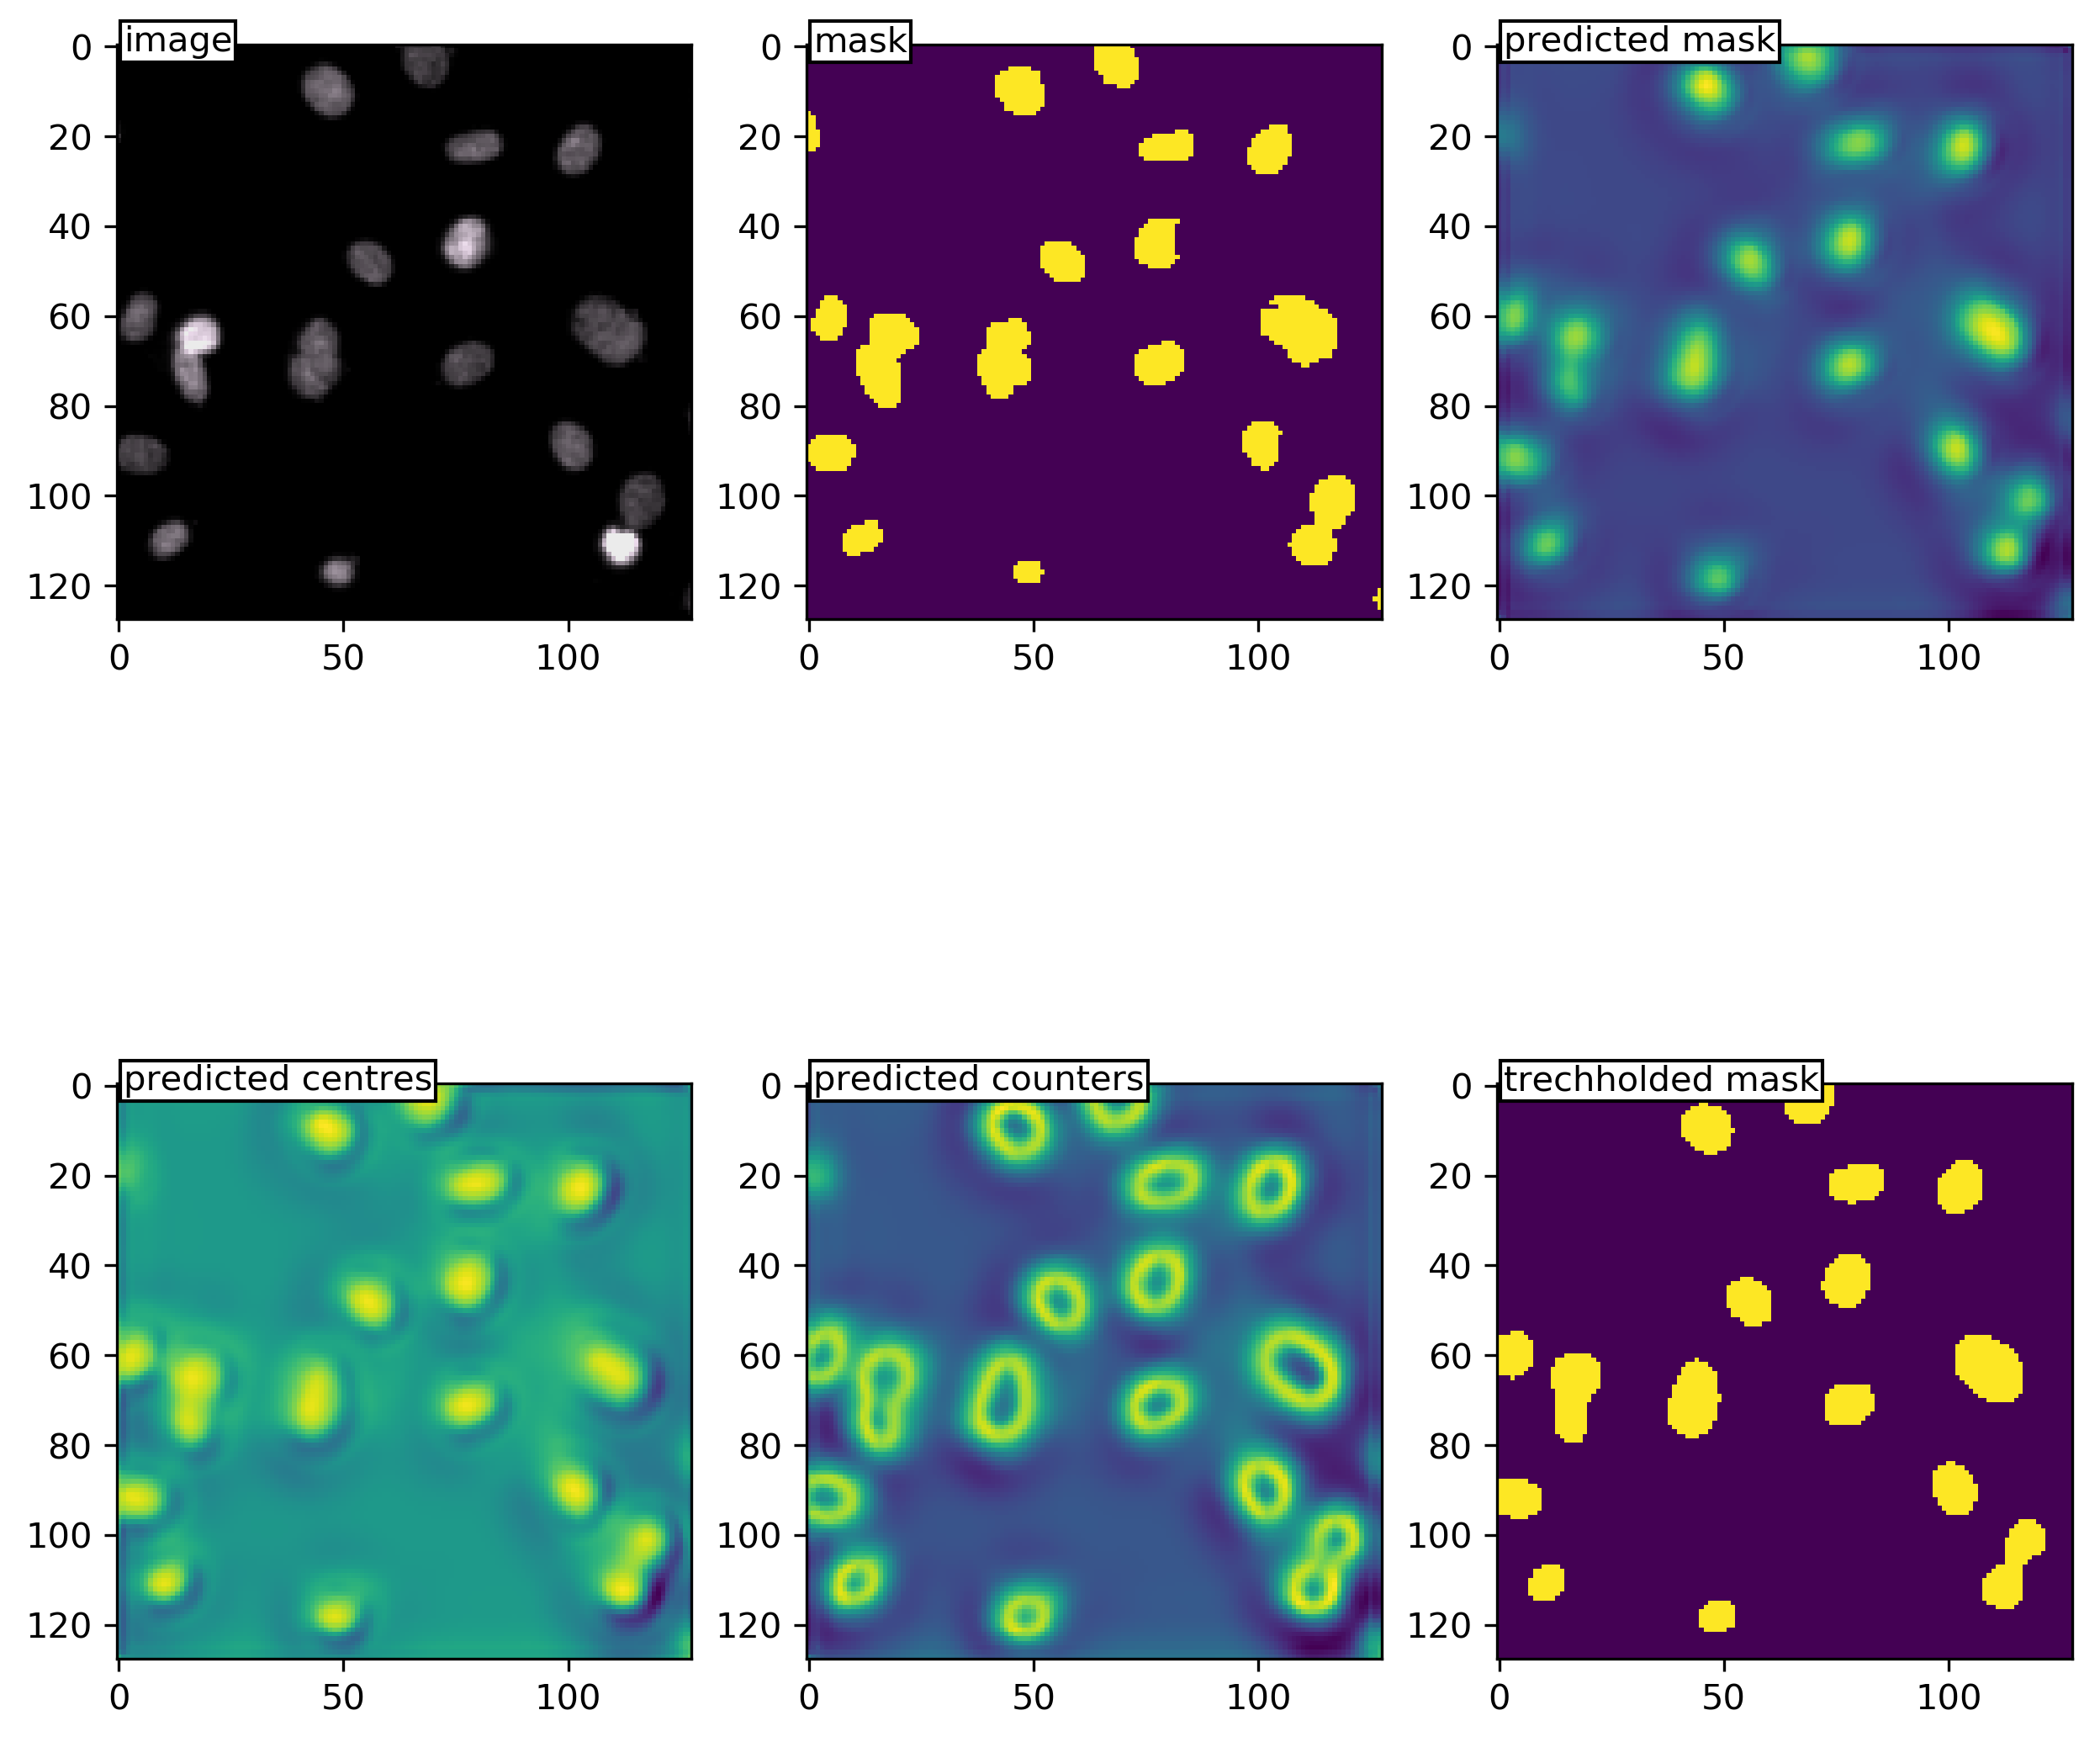

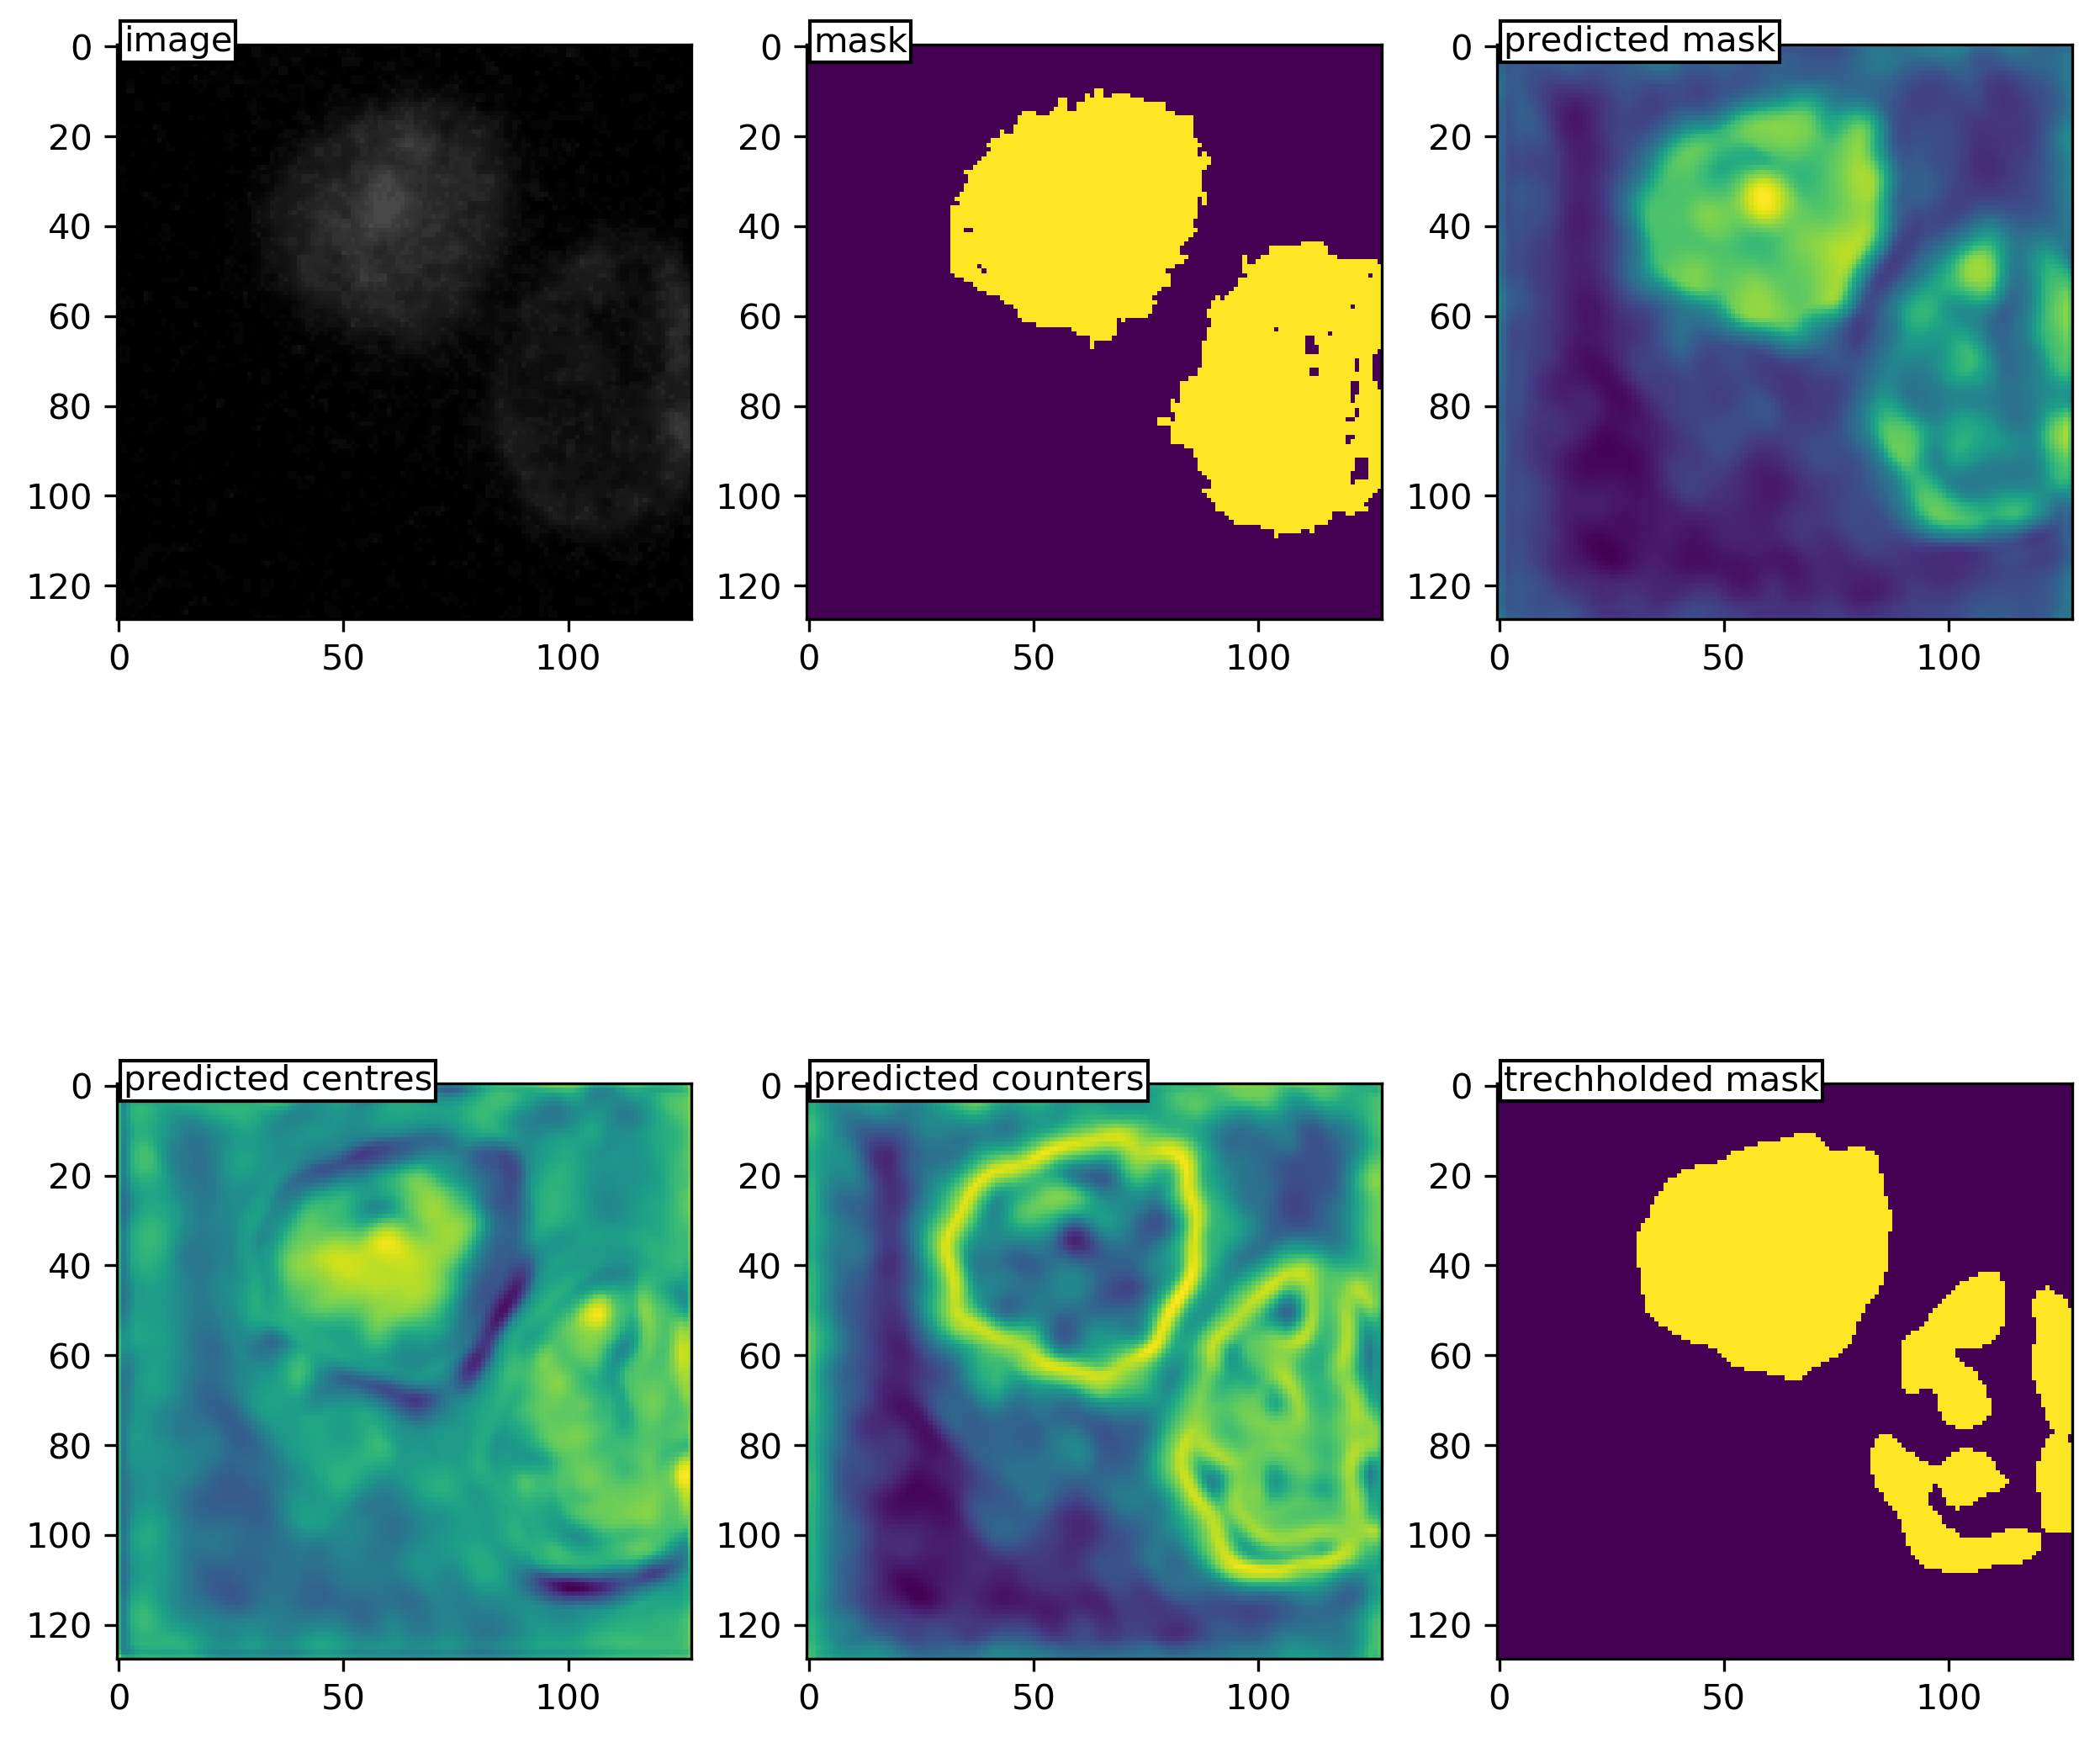

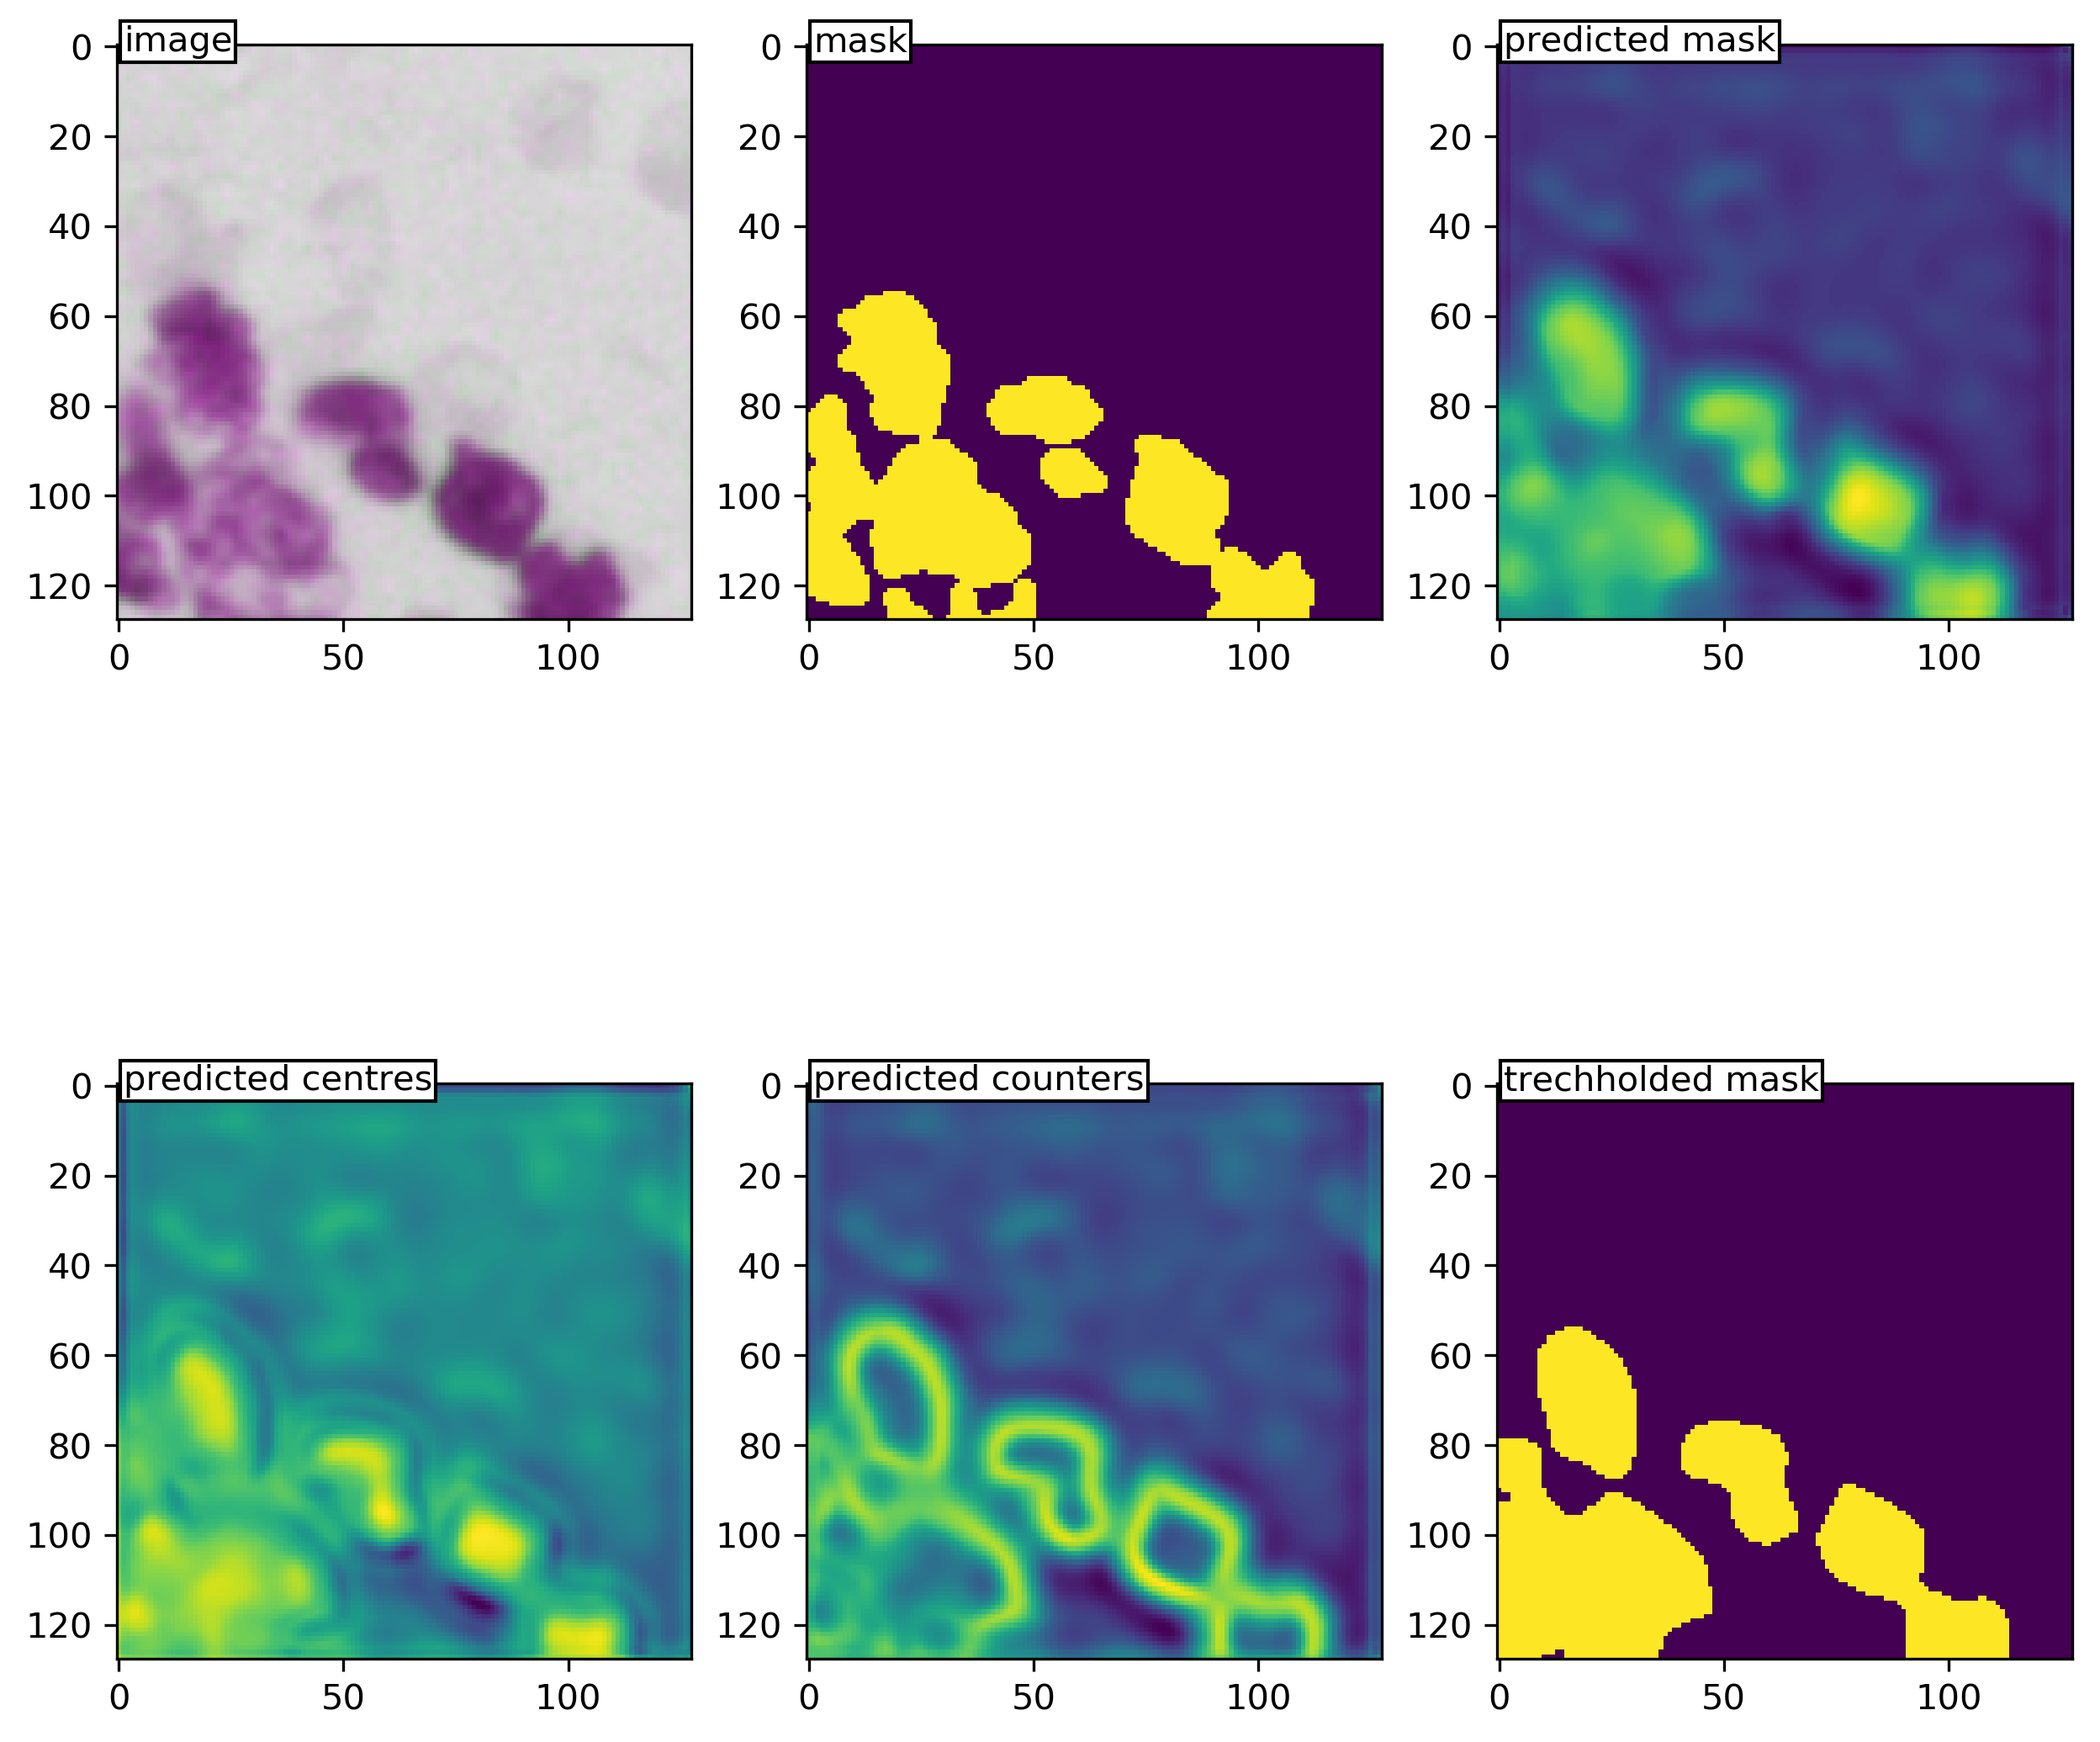

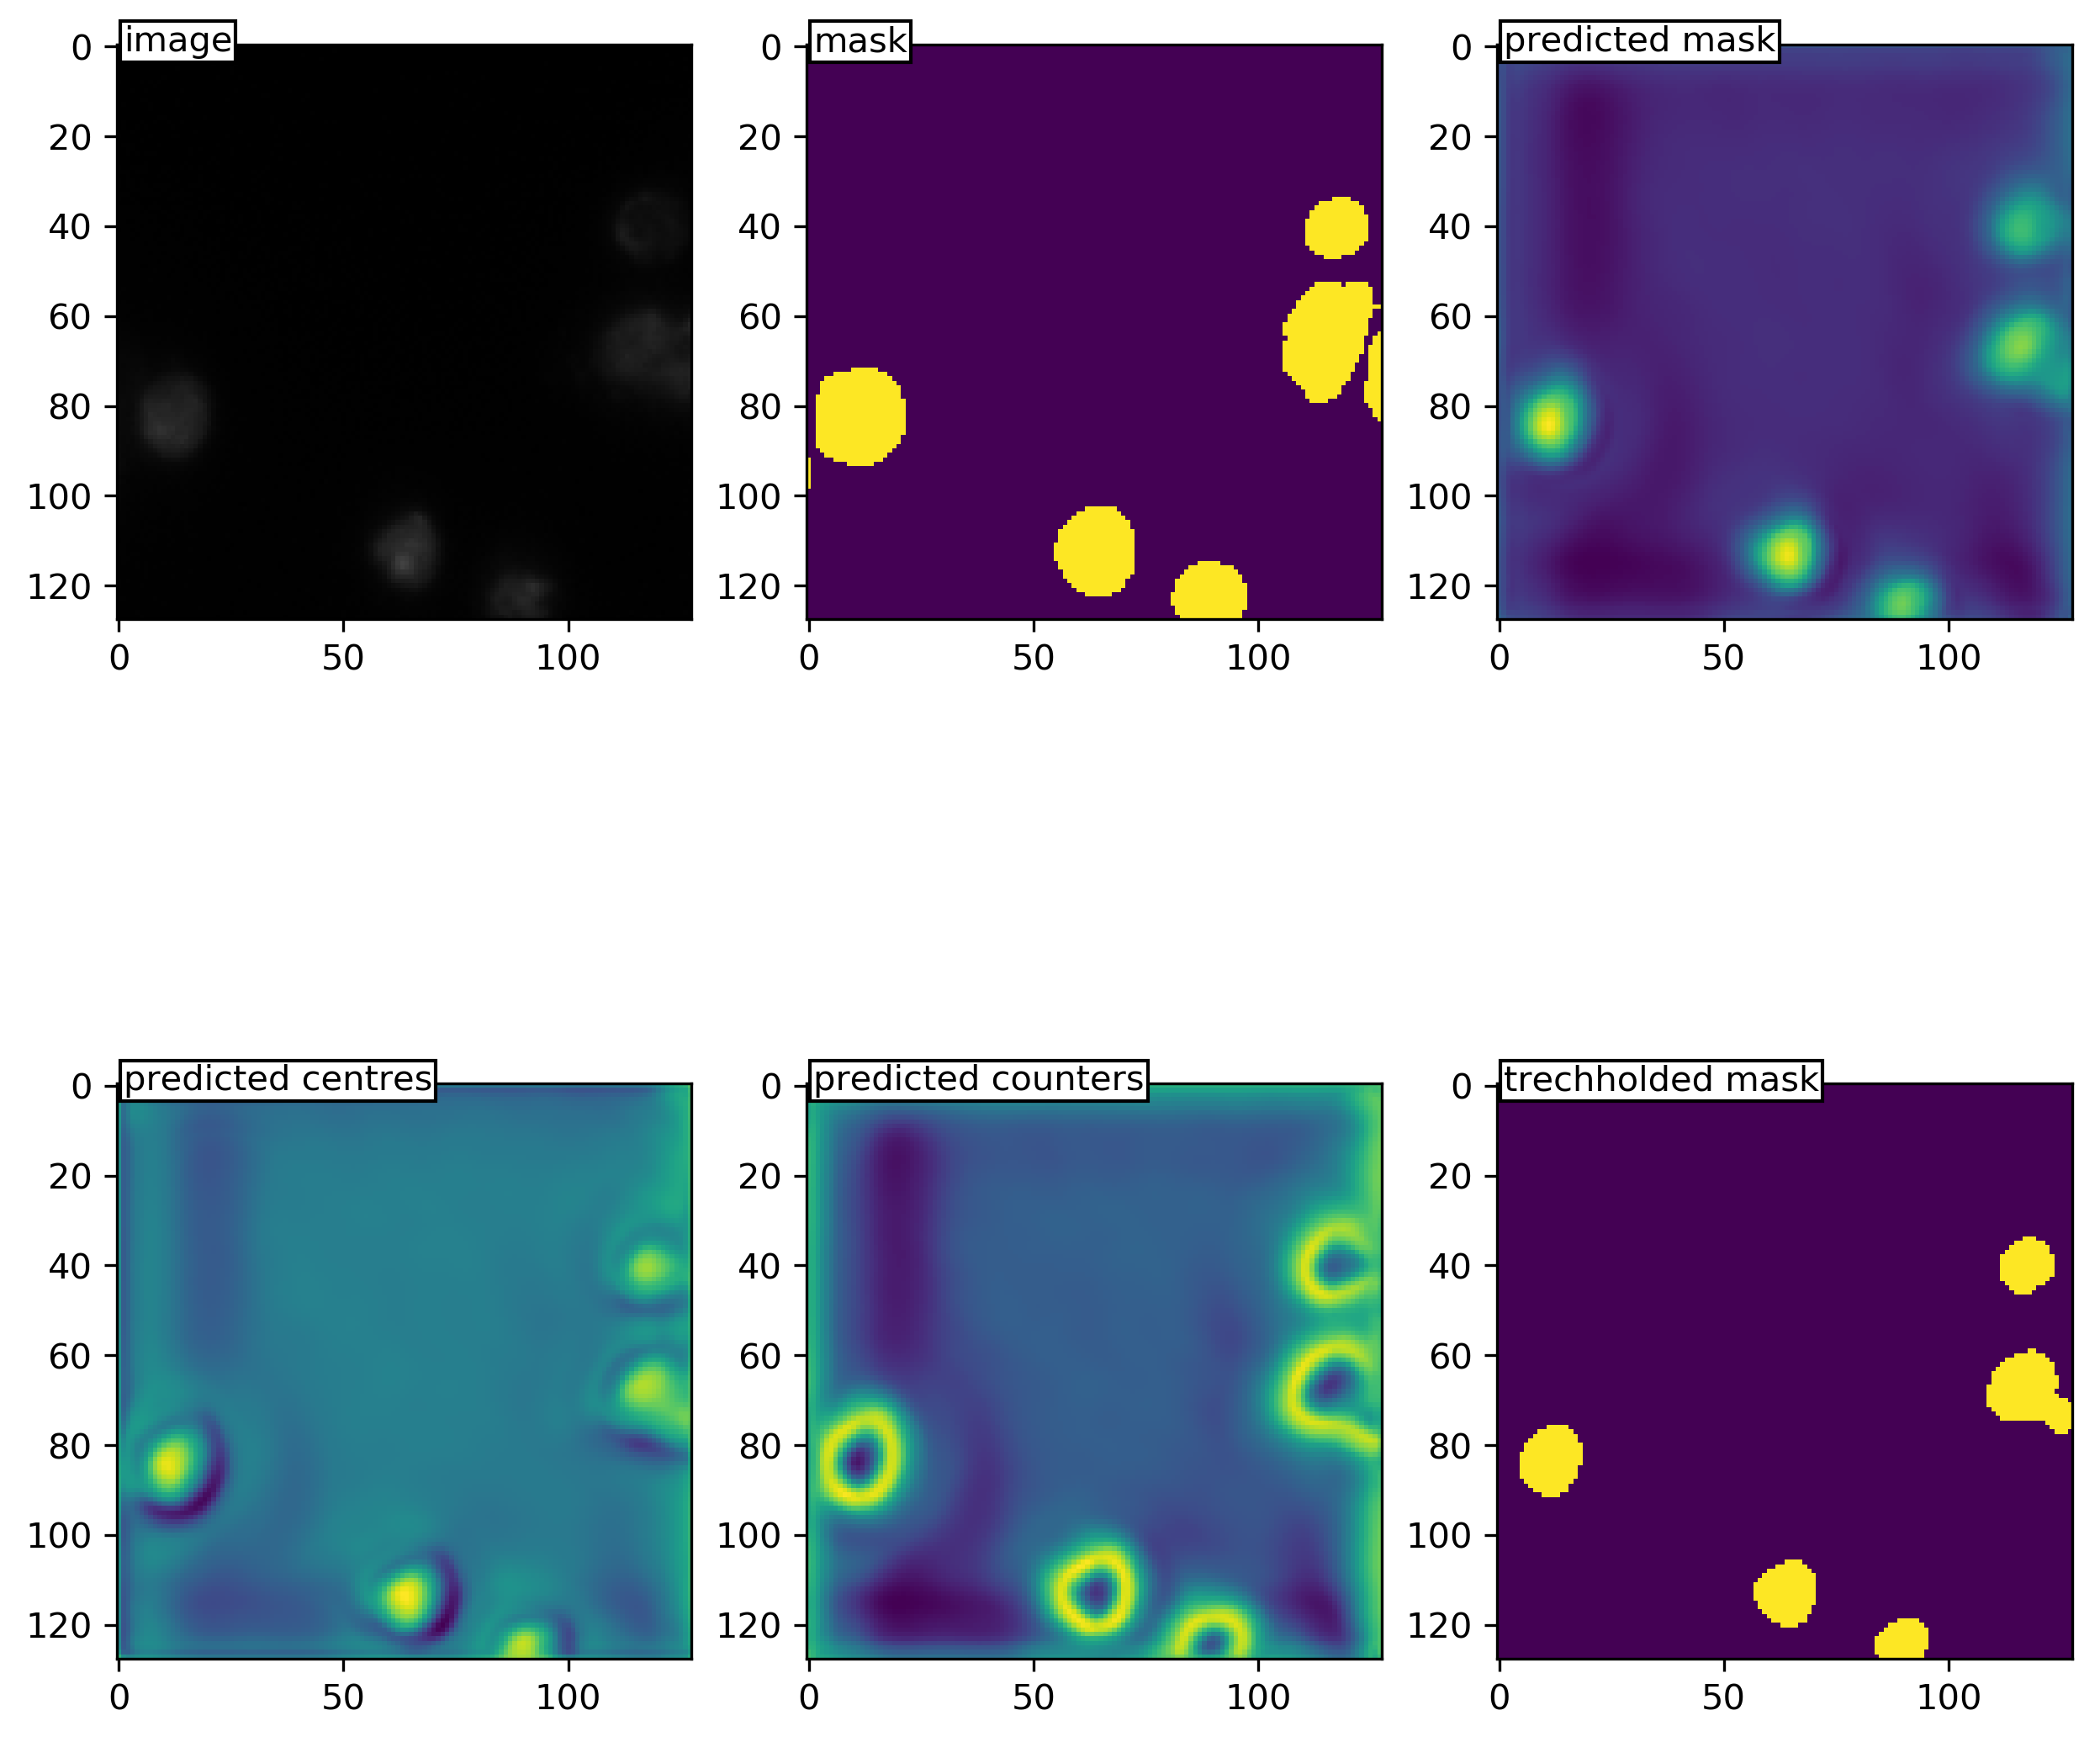

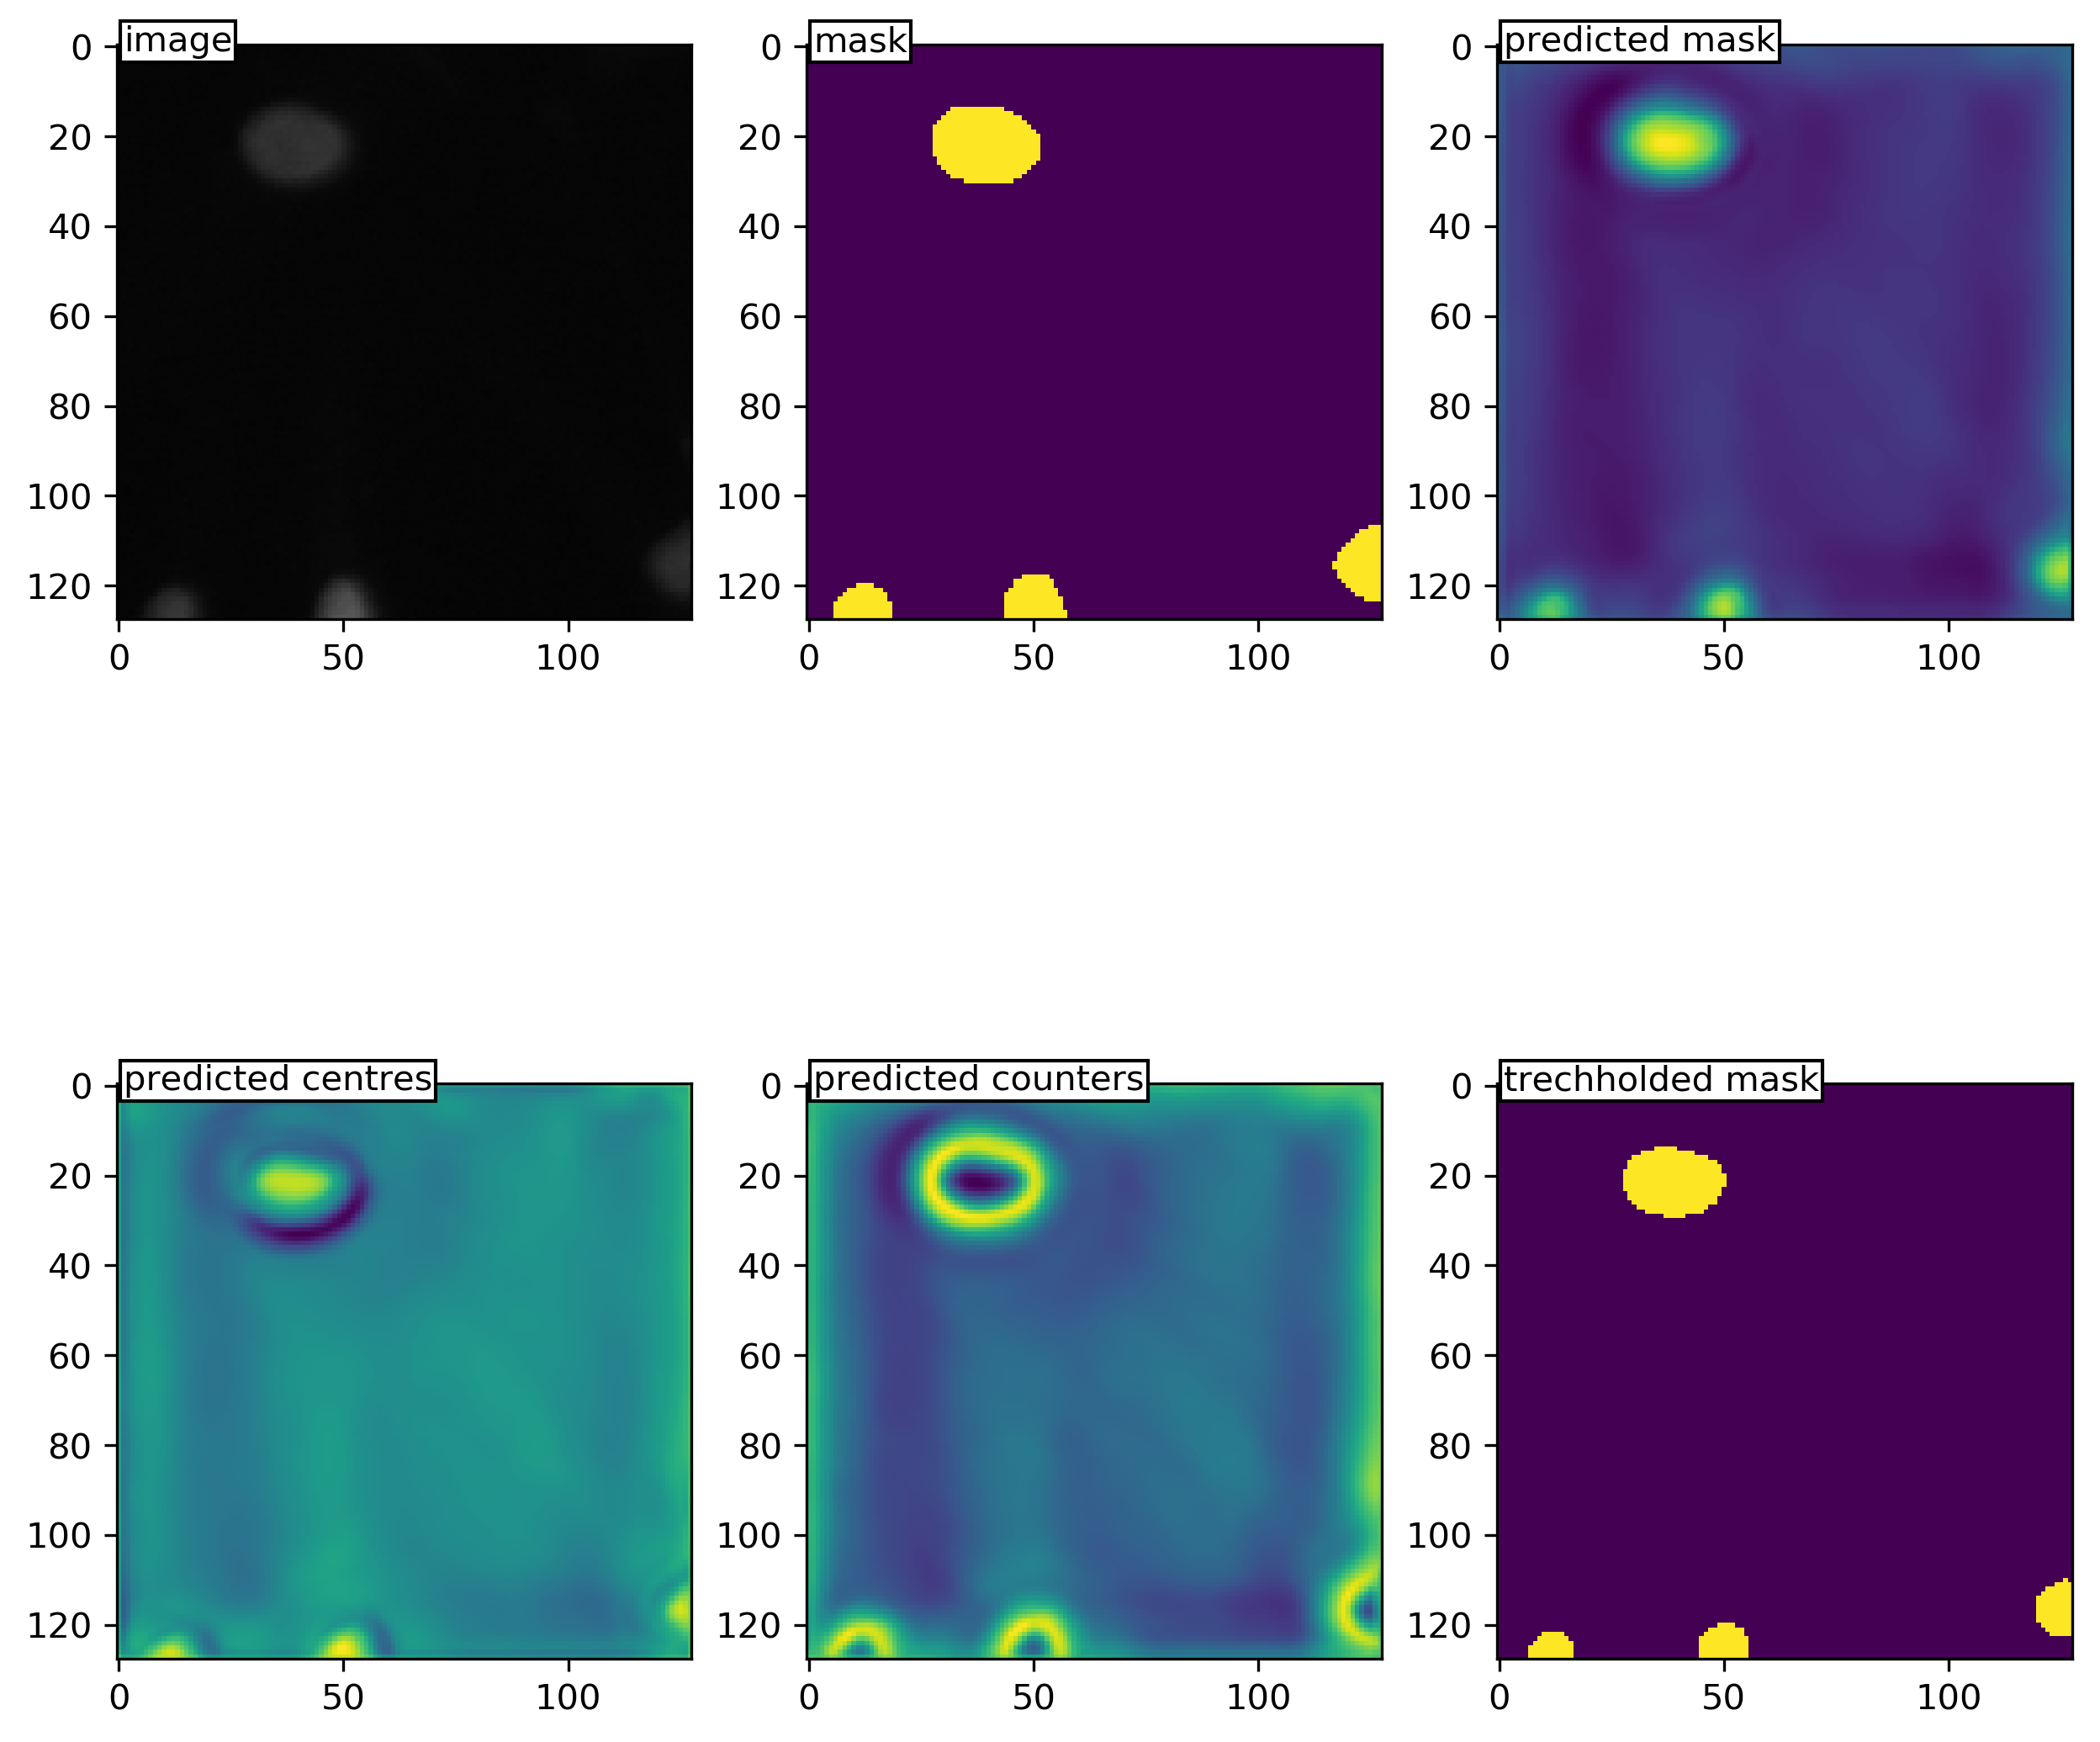

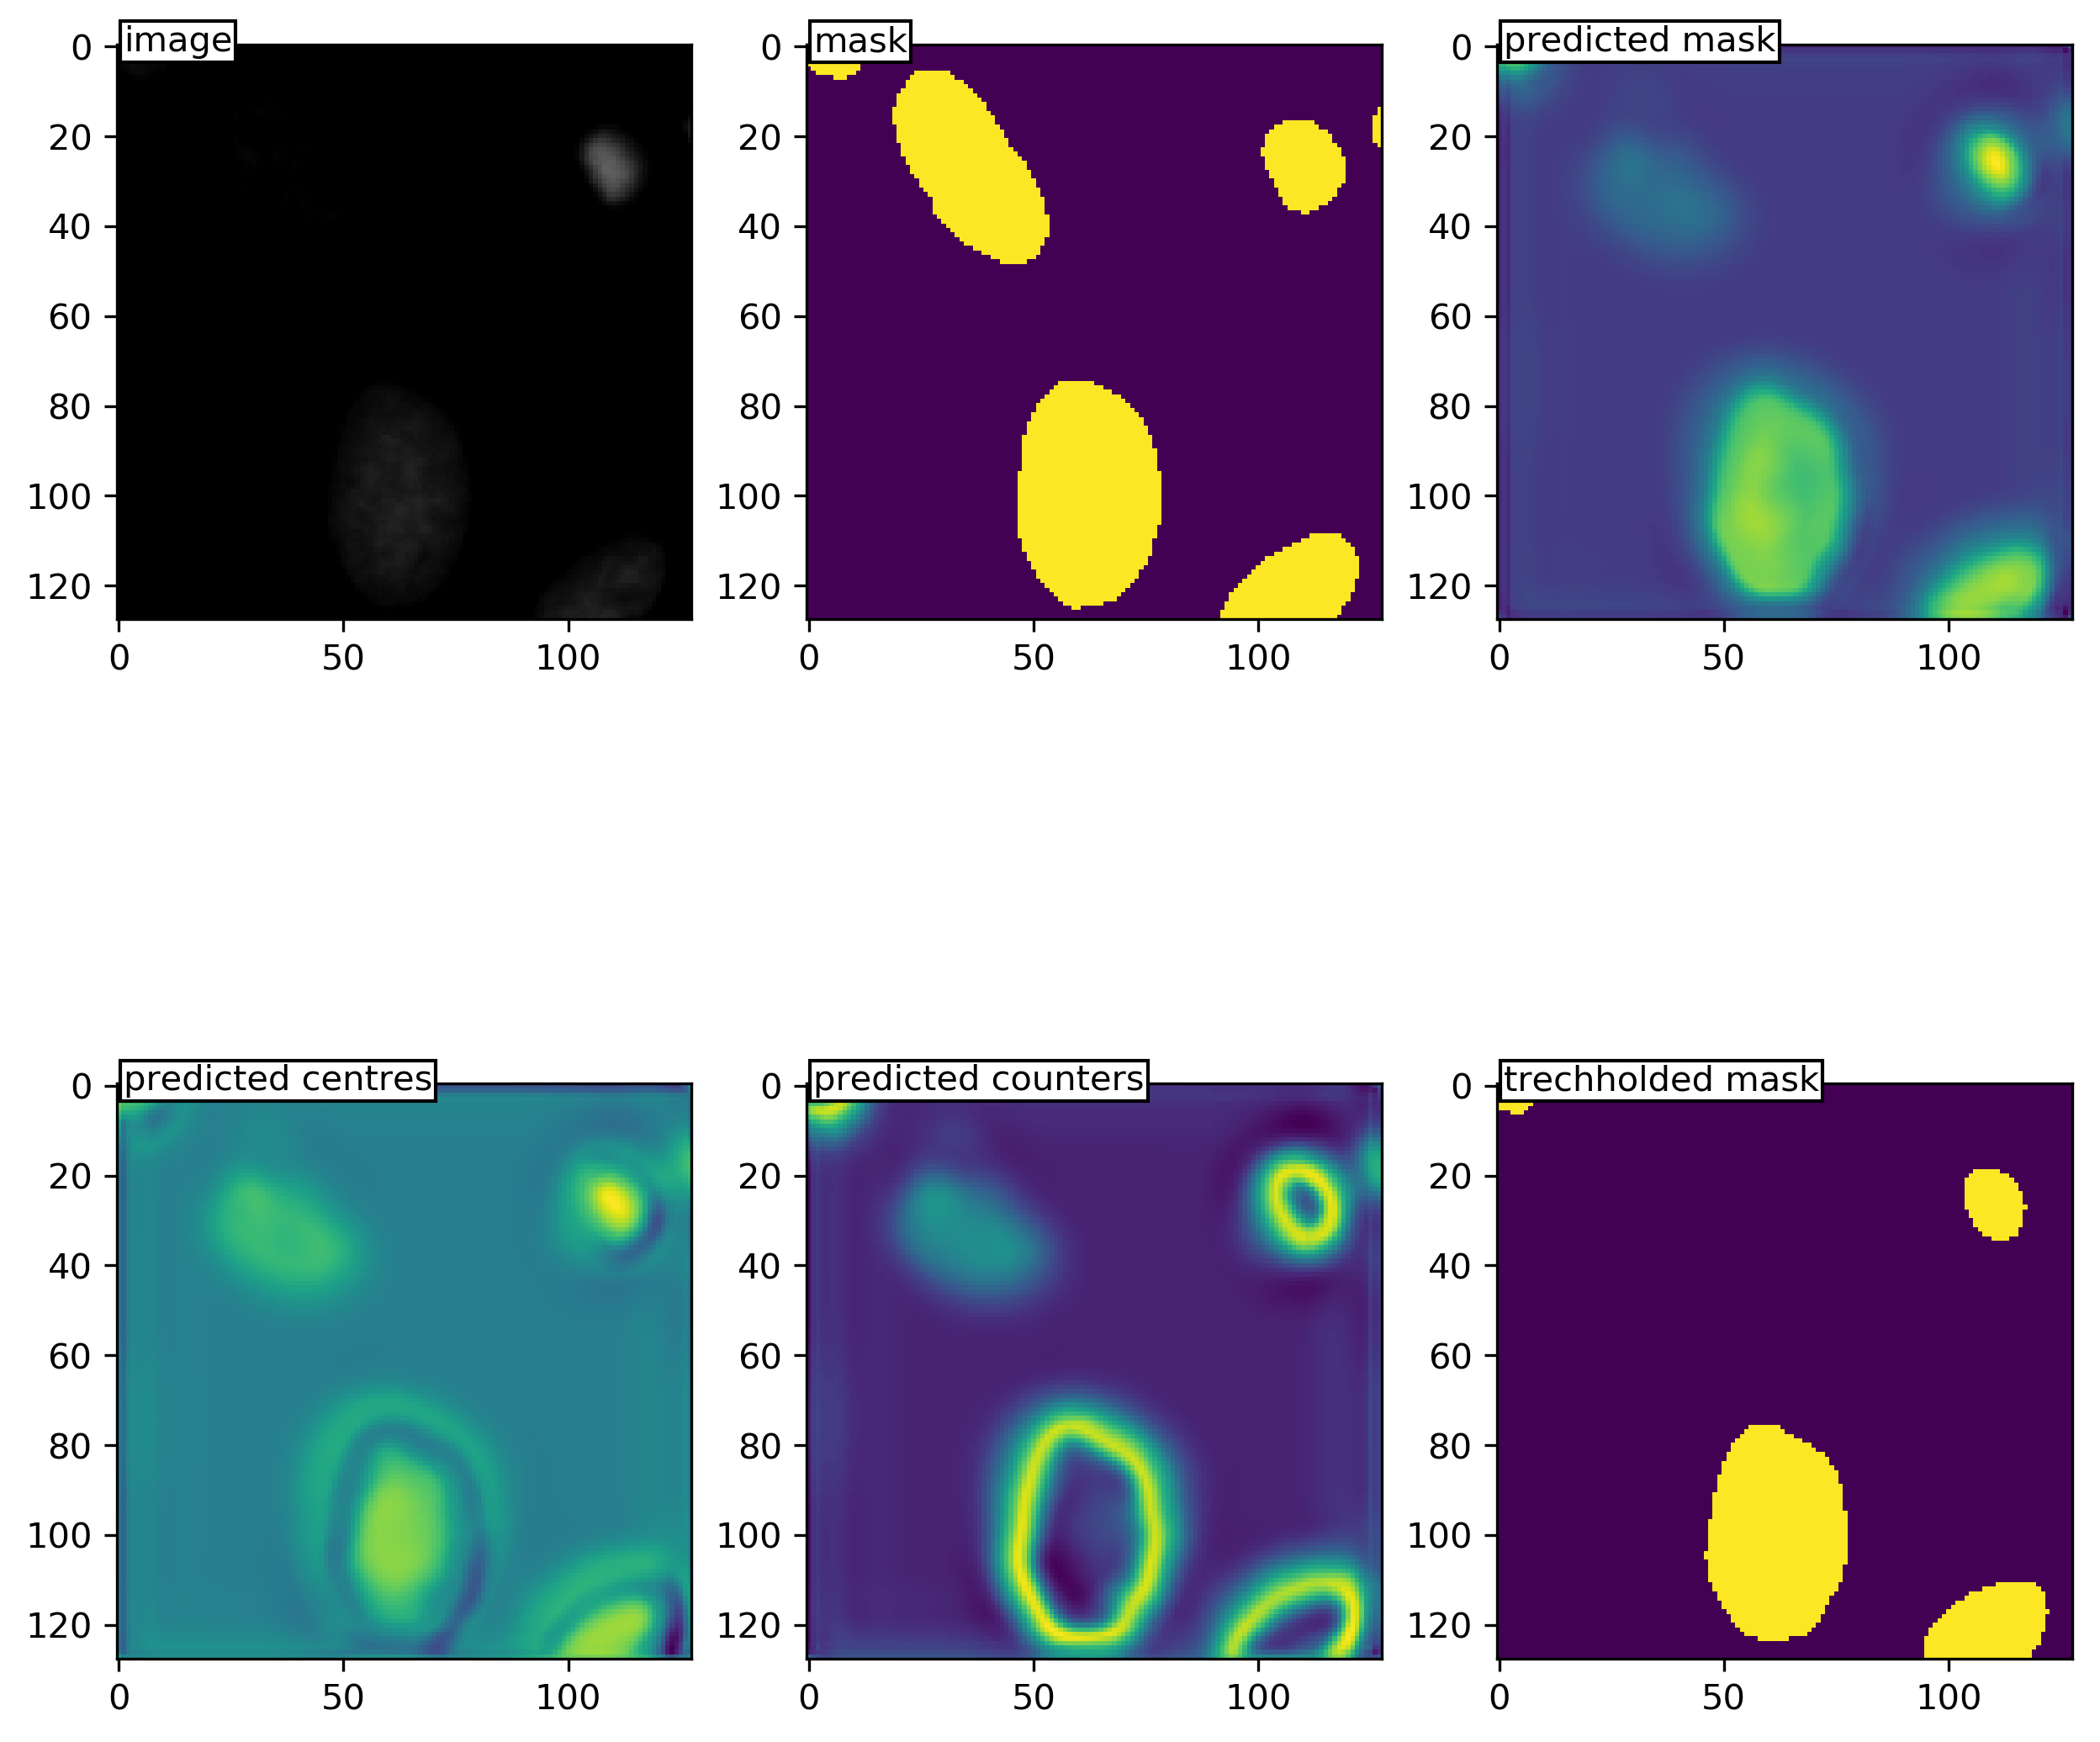

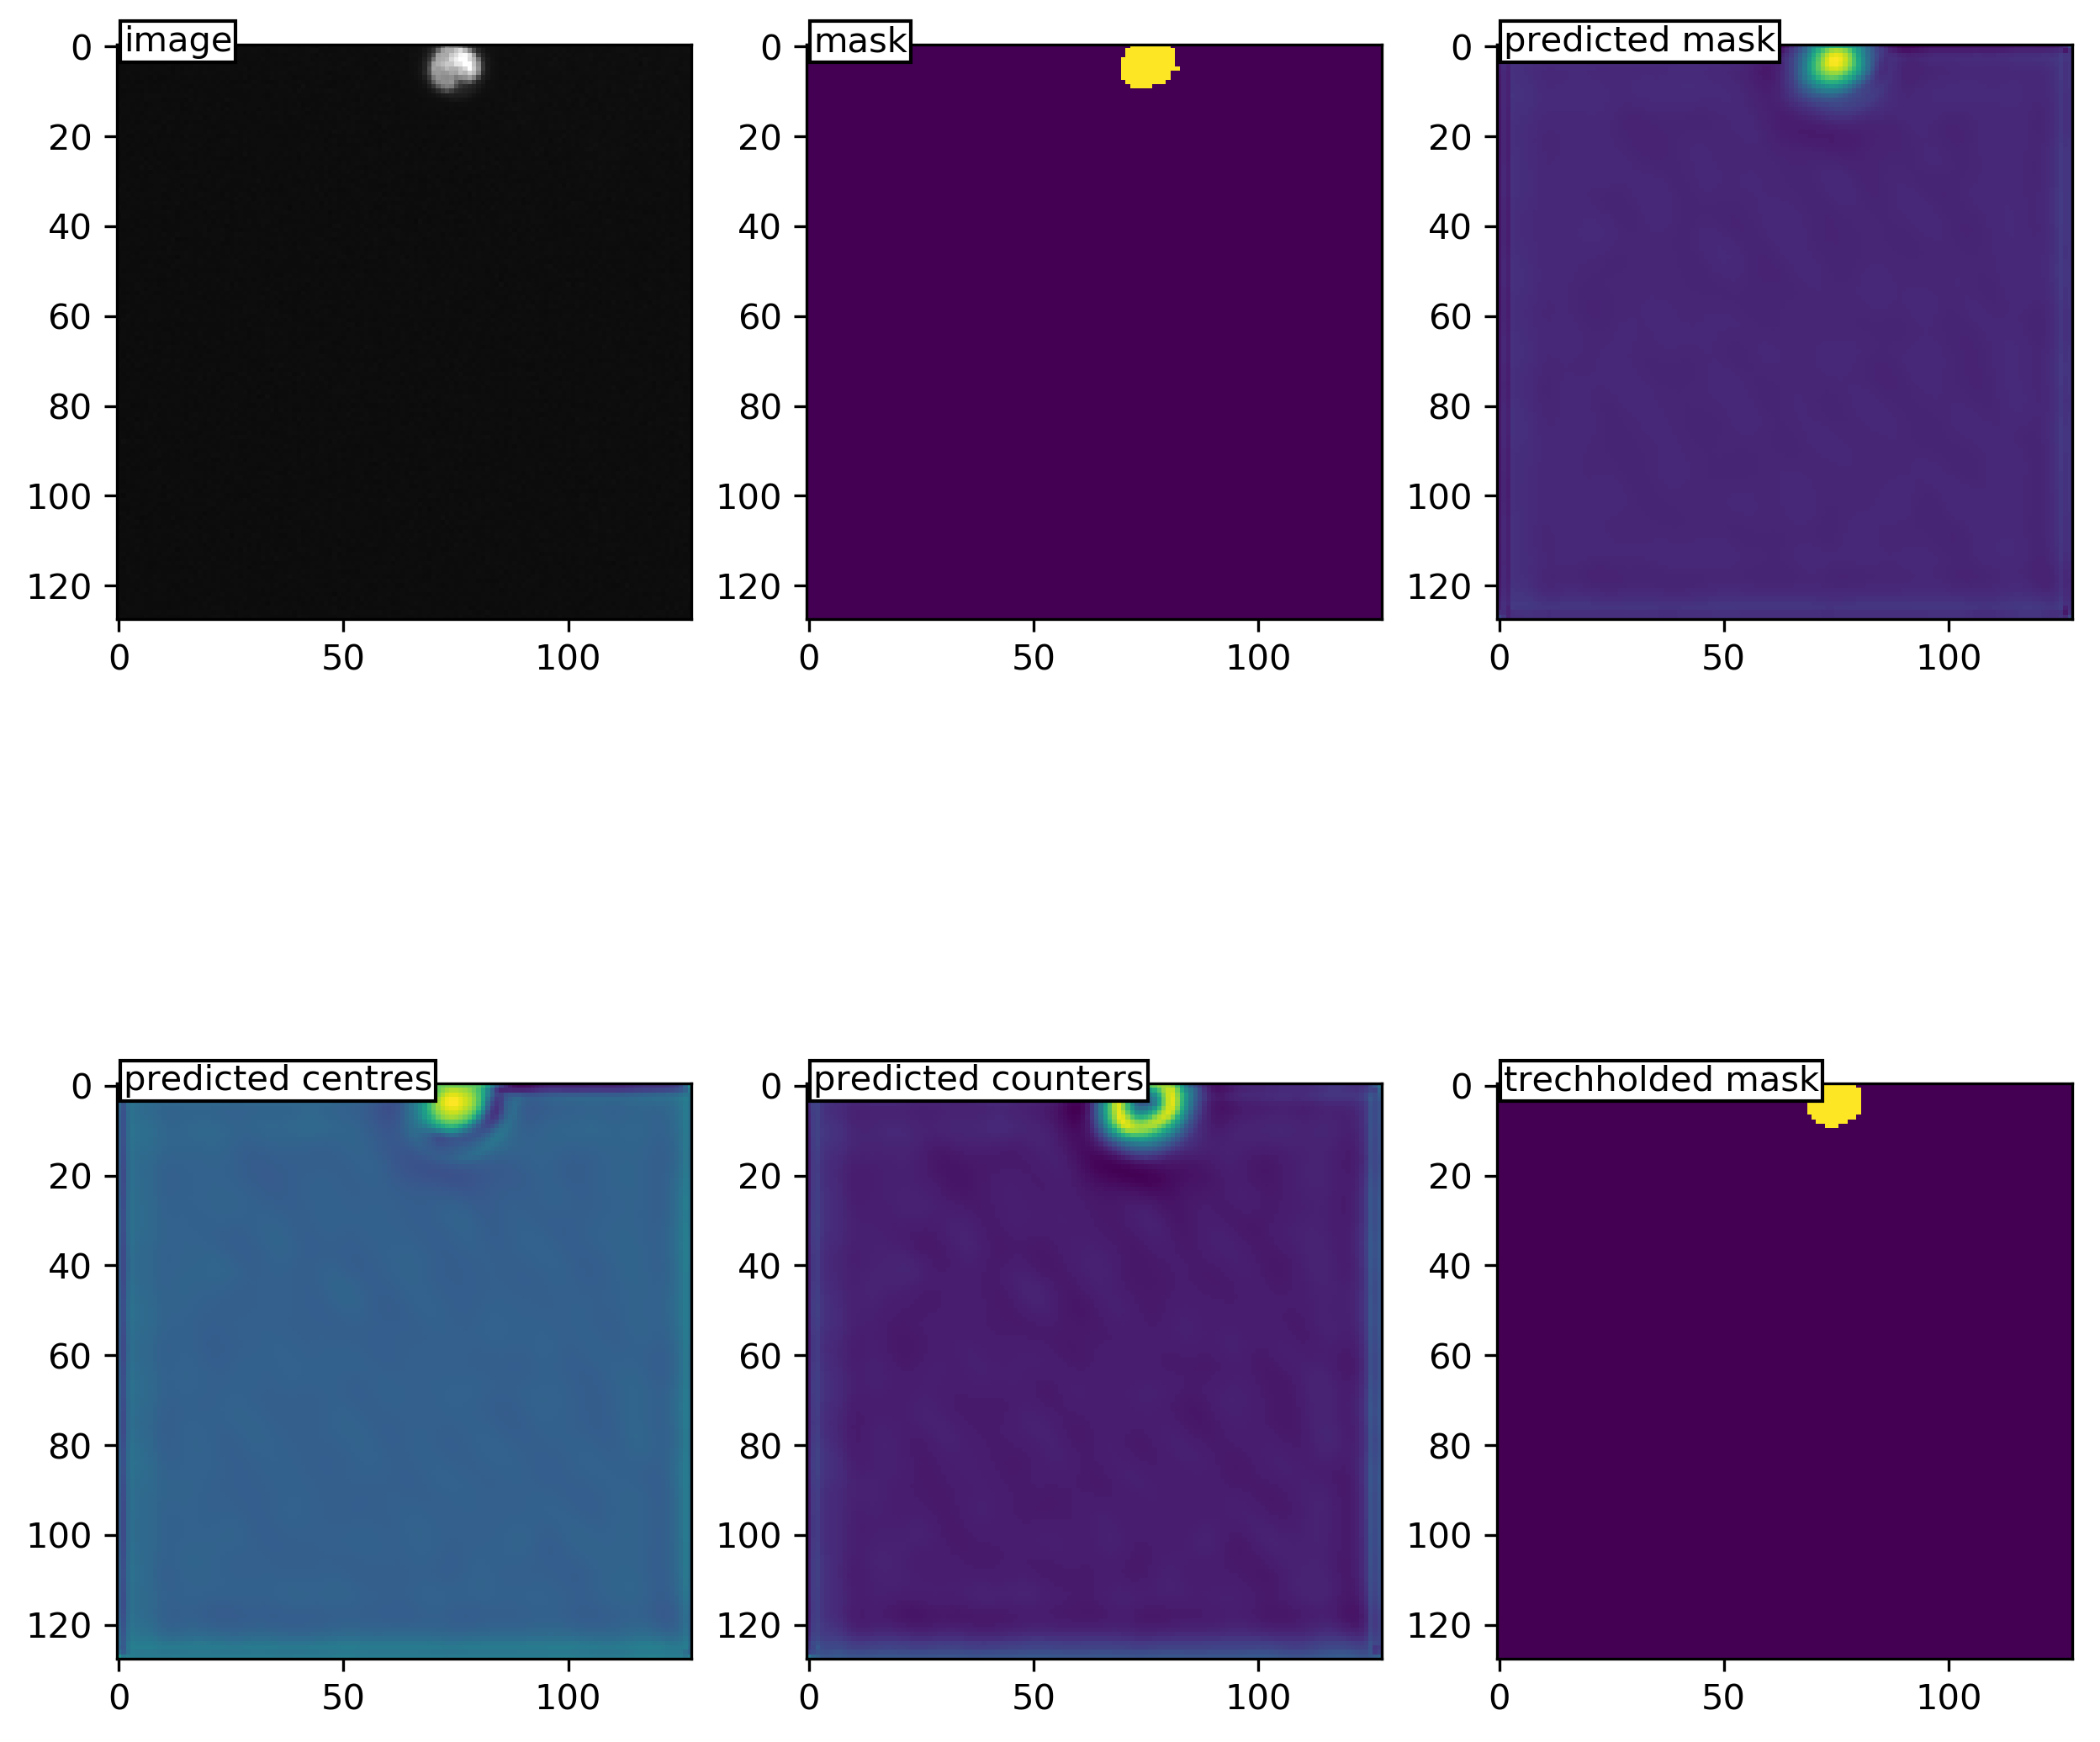

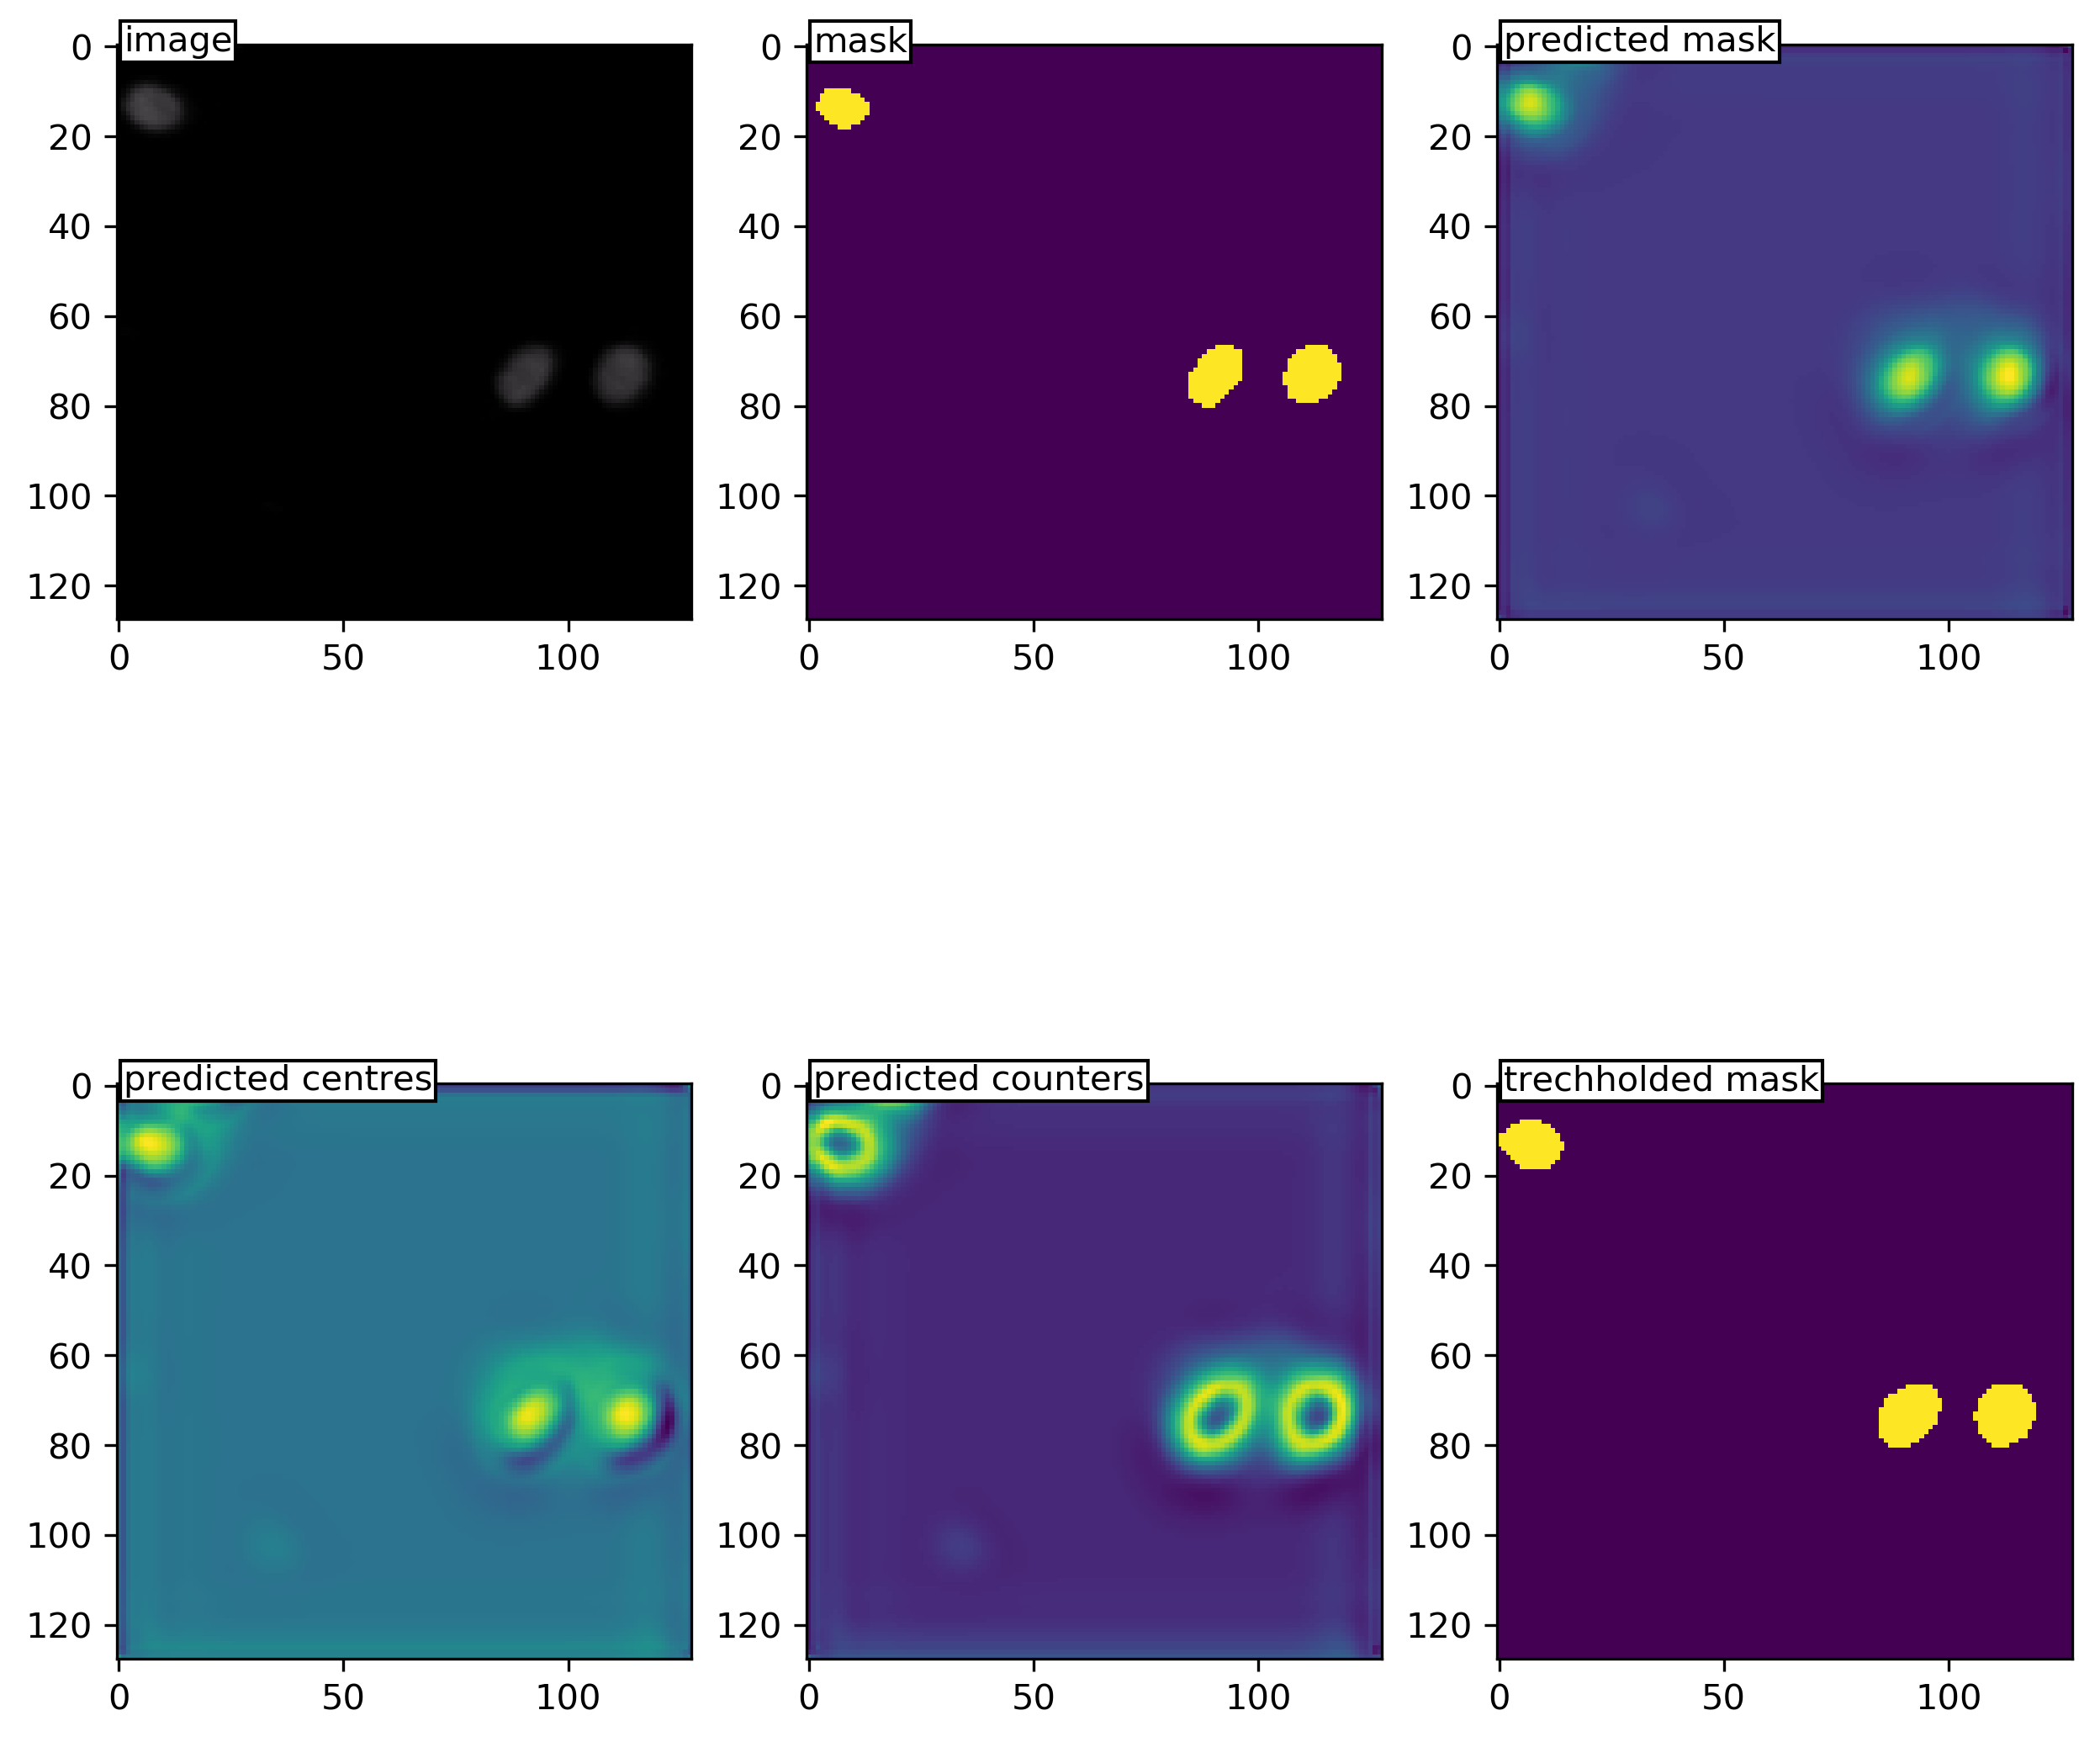

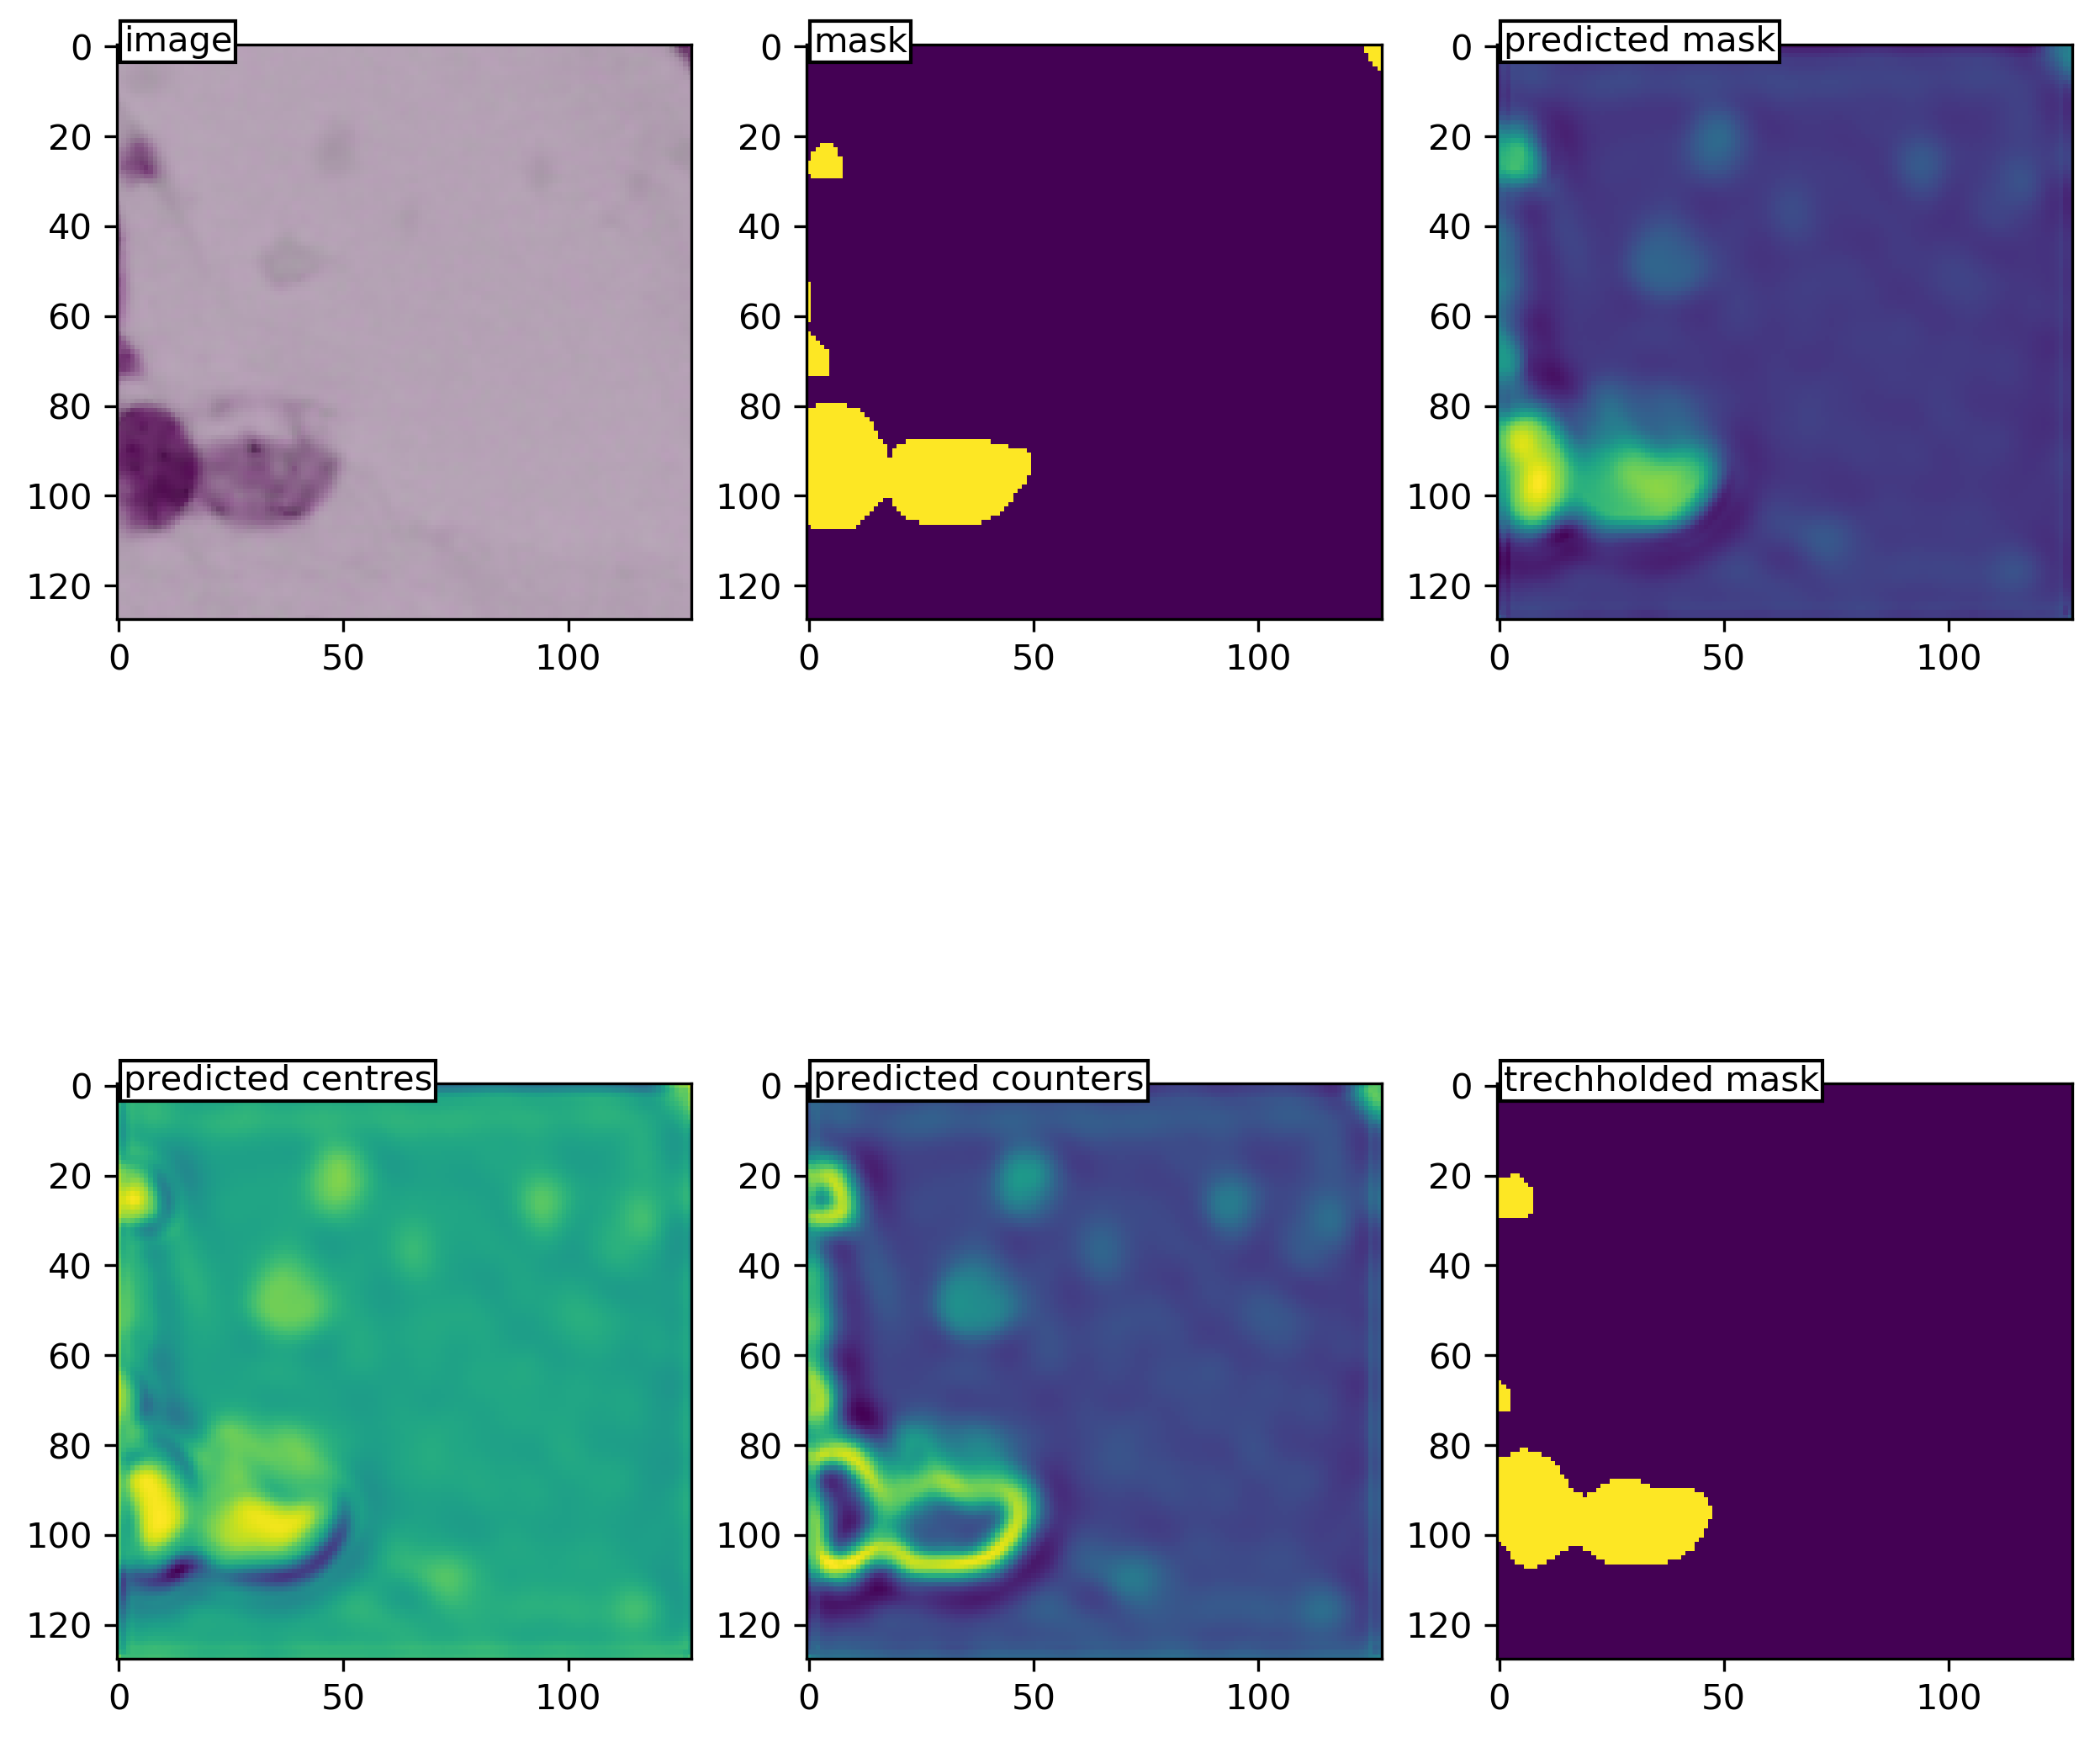

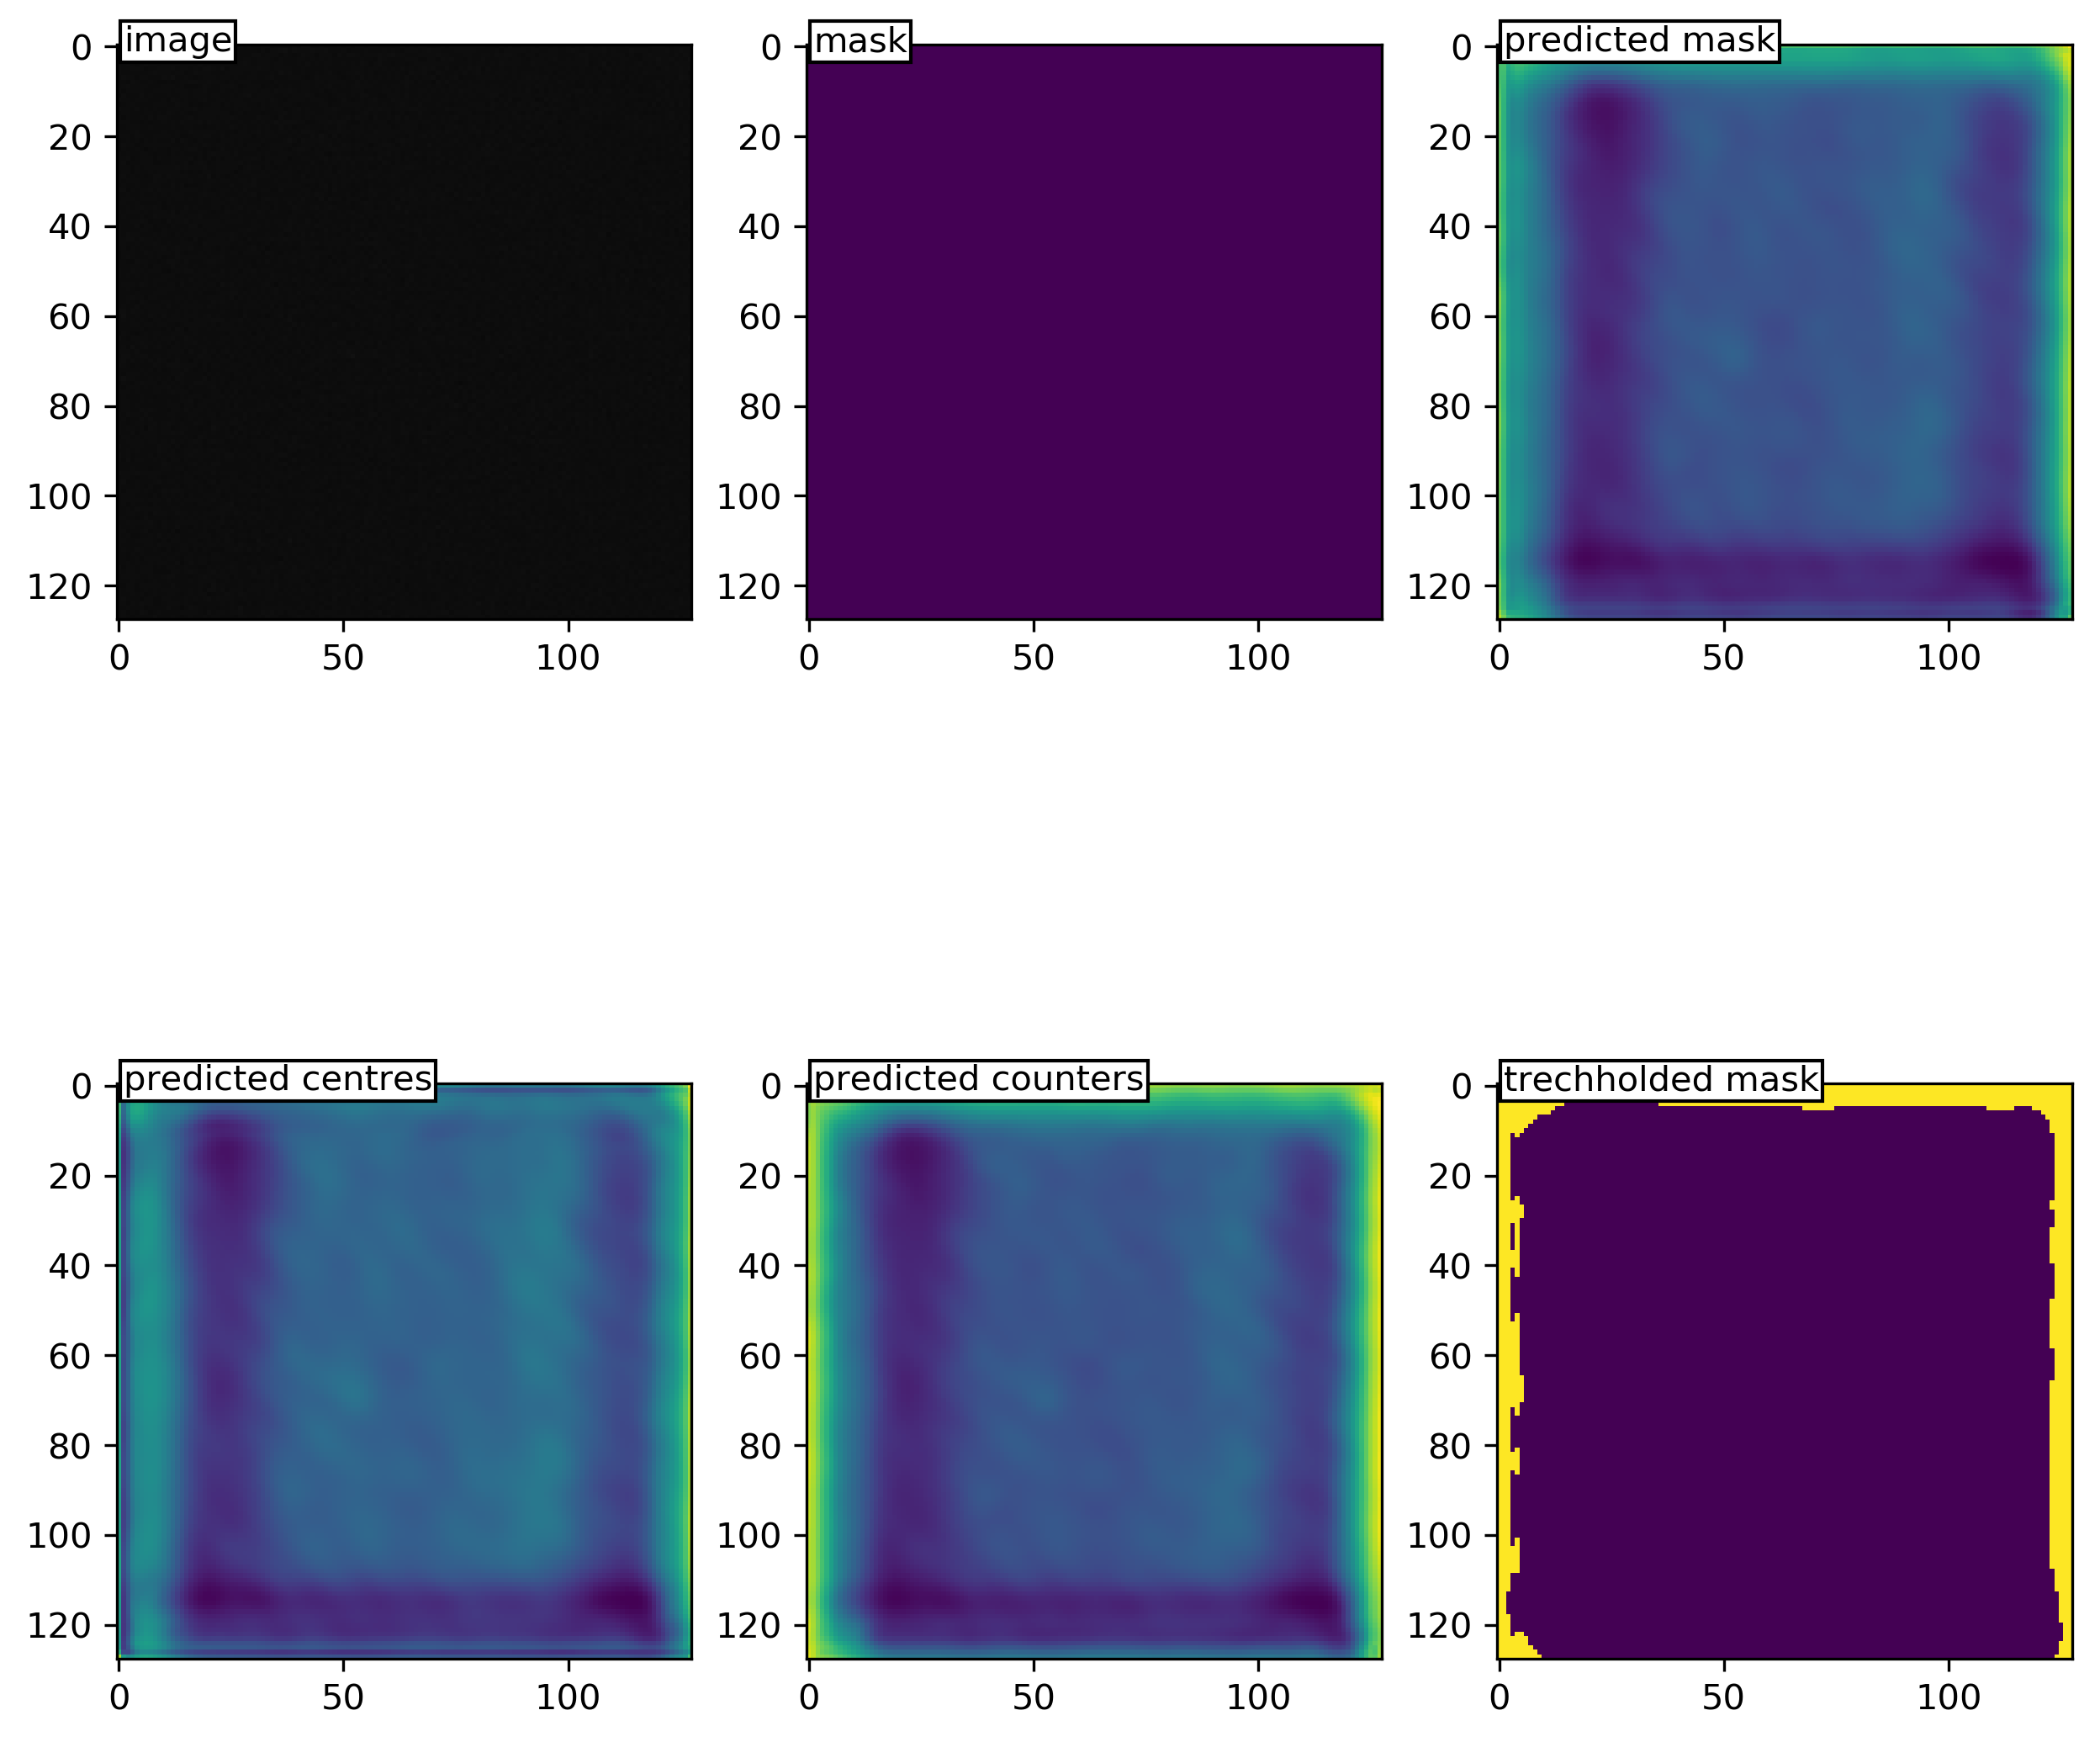

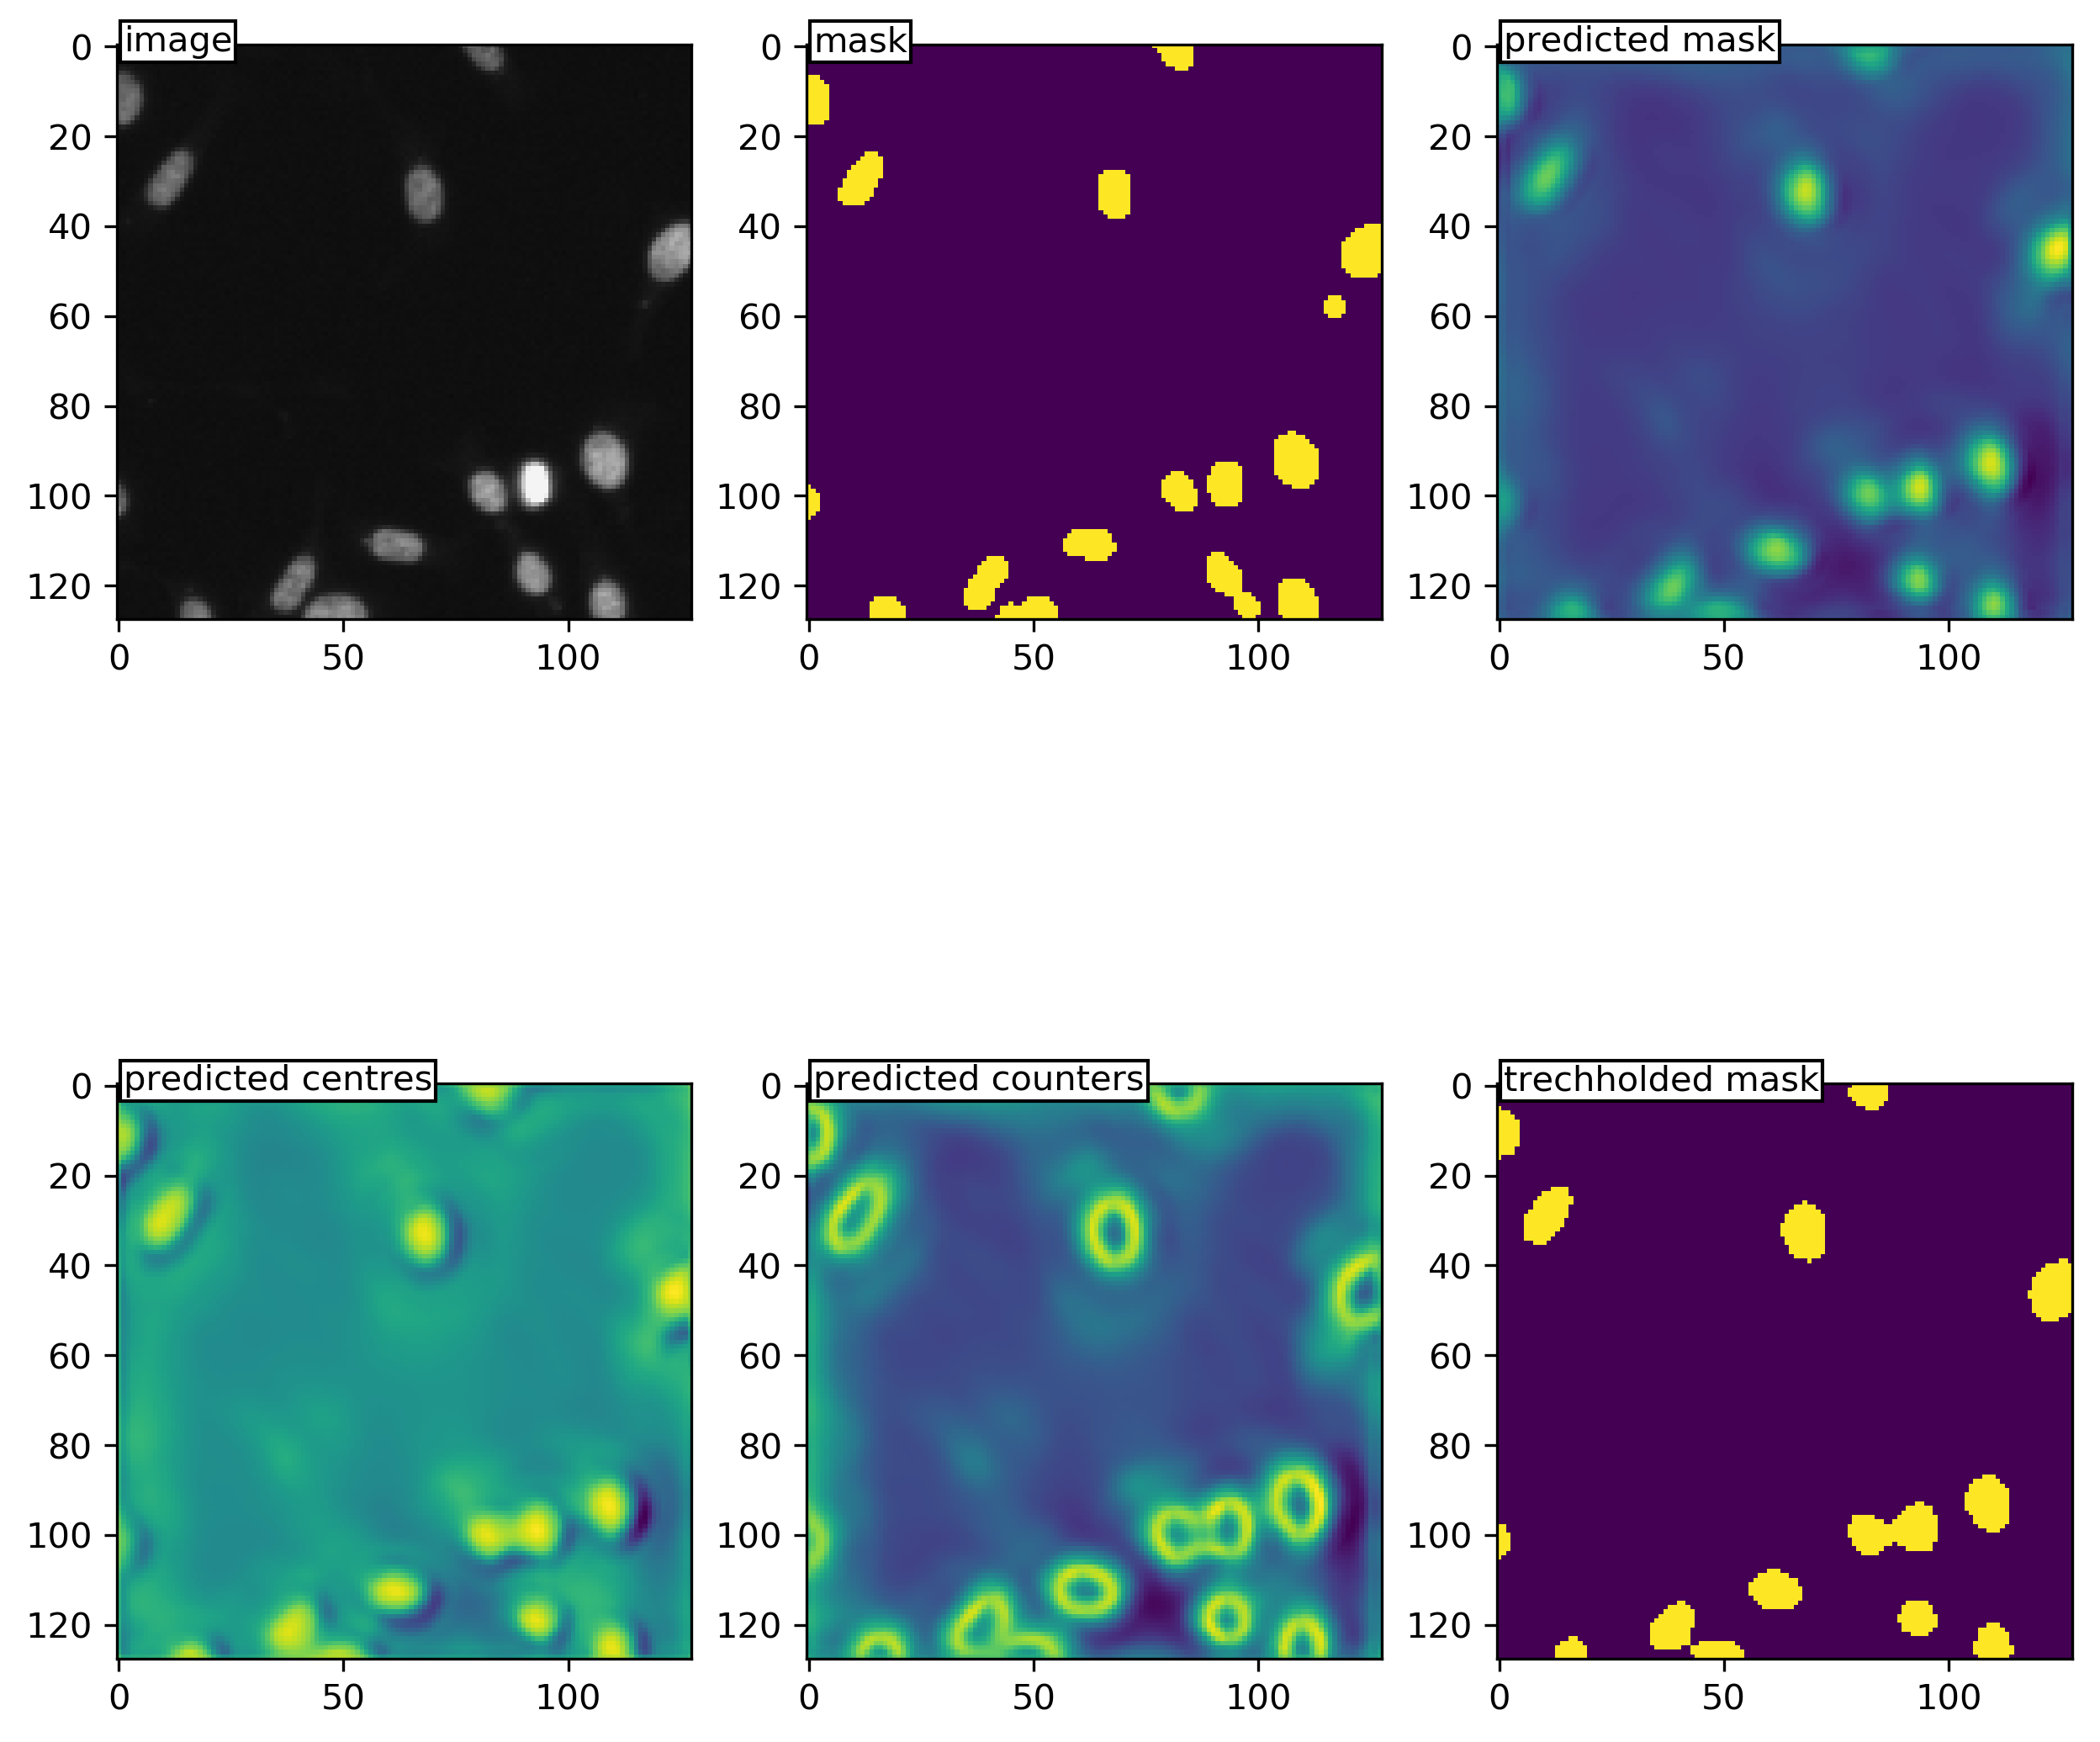

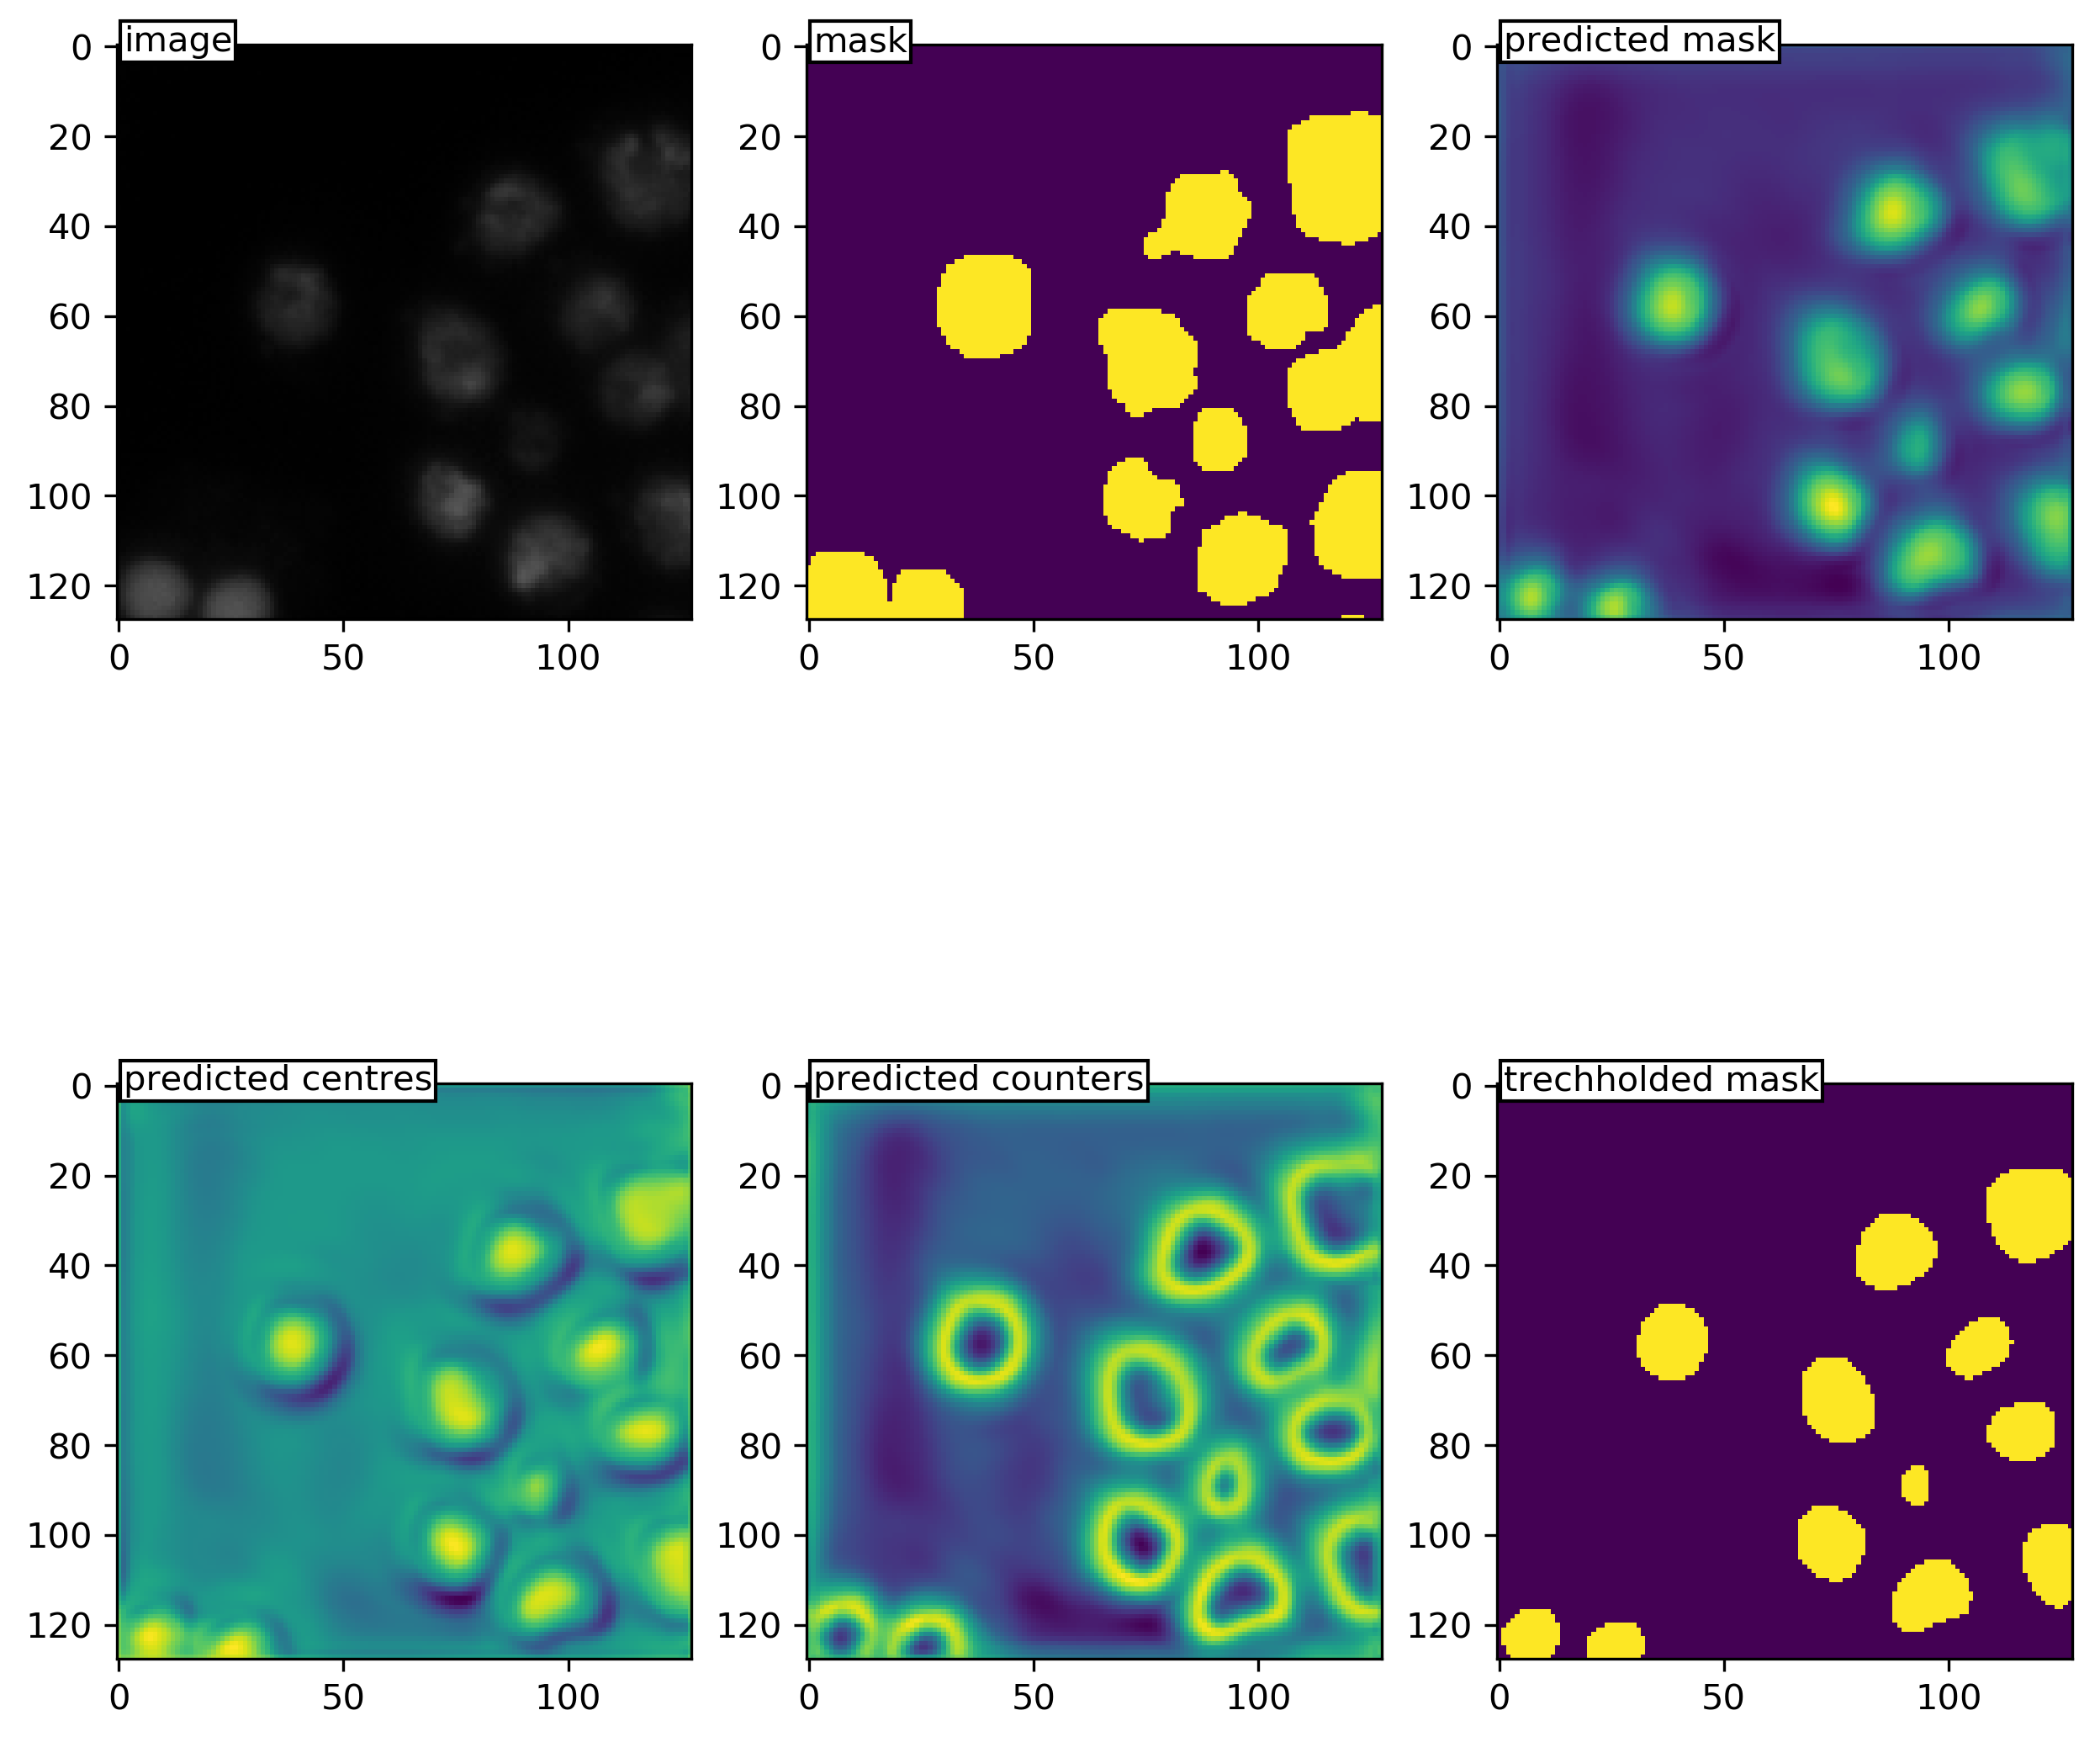

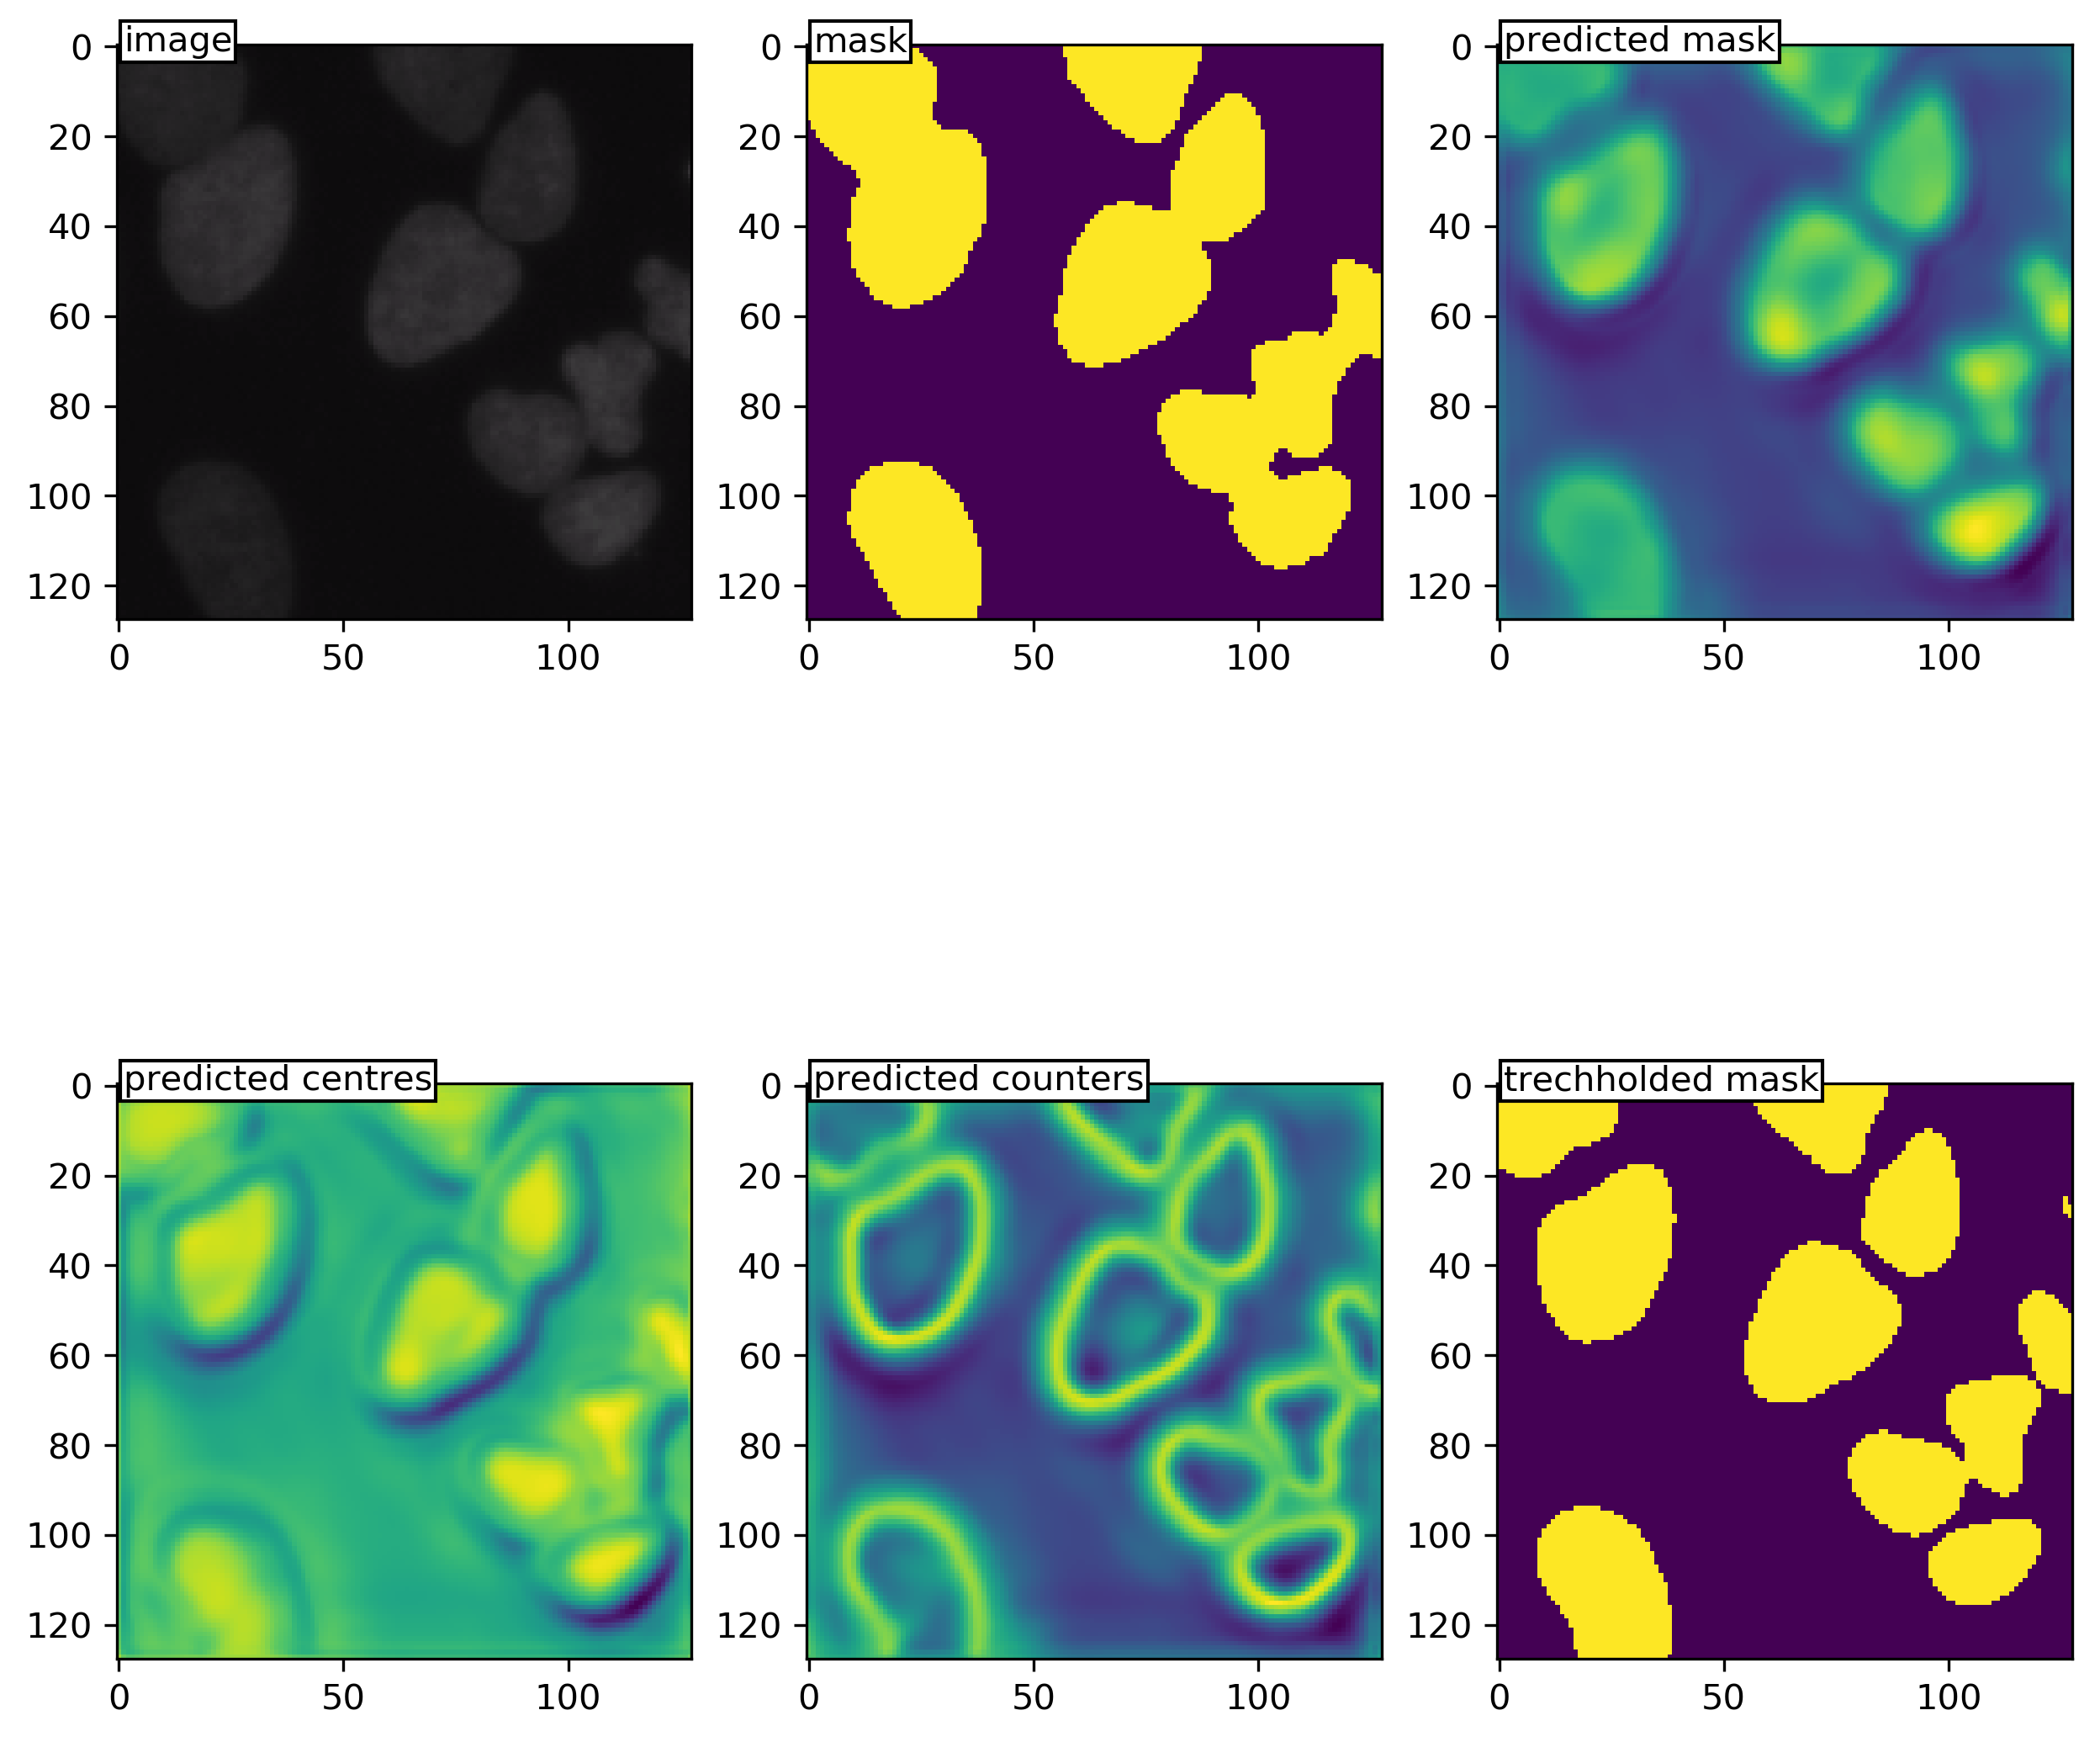

In [103]:
%%time
for num in range(33):
    img = x[num][[0,1,2]].data.permute(1,2,0).cpu().numpy()
    masks = o[num][0].data.cpu().numpy()
    center = o[num][1].data.cpu().numpy()
    counter = o[num][2].data.cpu().numpy()

    masks = masks - masks.min()
    masks = masks / masks.max()
    center = center - center.min()
    center = center / center.max()
    counter = counter - counter.min()
    counter = counter / counter.max()
    if img.min() < 0:
        img = img * .5 + .5

    plt.figure(figsize=(10,10),dpi=300)
    plt.subplot(231)
    plt.text(1, 1, 'image', bbox={'facecolor': 'white', 'pad': 1})
    plt.imshow(img)
    plt.subplot(232)
    plt.text(1, 1, 'mask', bbox={'facecolor': 'white', 'pad': 1})
    plt.imshow(y[num].data.cpu().numpy()[0])
    plt.subplot(233)
    plt.text(1, 1, 'predicted mask', bbox={'facecolor': 'white', 'pad': 1})
    plt.imshow(masks)

    plt.subplot(234)
    plt.text(1, 1, 'predicted centres', bbox={'facecolor': 'white', 'pad': 1})
    plt.imshow(center)
    plt.subplot(235)
    plt.text(1, 1, 'predicted counters', bbox={'facecolor': 'white', 'pad': 1})
    plt.imshow(counter)
    plt.subplot(236)
    plt.text(1, 1, 'trechholded mask', bbox={'facecolor': 'white', 'pad': 1})
    plt.imshow(masks>0.5)

plt.savefig(f"./imgs/{num}.png")

In [46]:
y[0].data.cpu().numpy()

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

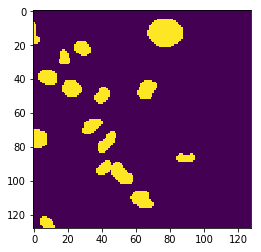

In [49]:
plt.imshow(y[0].data.cpu().numpy()[0])

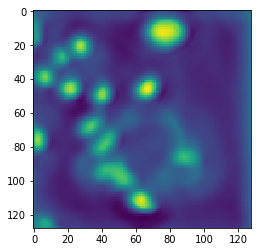

In [26]:
plt.imshow(masks)

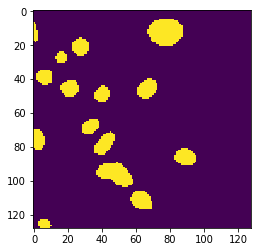

In [24]:
plt.imshow(masks>0.5)

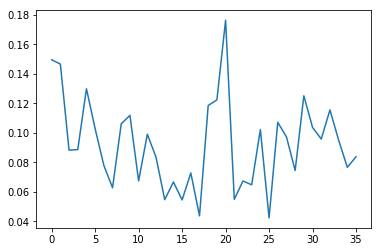

In [9]:
plt.plot(loss_array)

In [10]:
ious

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [8]:
def default_loss_composition(loss1, loss2, loss3):
    return loss1 + loss2 + loss3

In [9]:
def back_shaper(img,shape:tuple):
        if (shape[0] % 64 == 0) and (shape[1] % 64 == 0):
            return img

        indention_0 = 64 - shape[0] % 64
        indention_1 = 64 - shape[1] % 64
        
        return img[indention_0 // 2:-(indention_0 - indention_0 // 2), indention_1 // 2:-(indention_1 - indention_1 // 2), :]
    
    
def unet_deconstructor(dataset, tensor, dirr = '../data/stage1_train/'):
    shapes = []
    dec_images = []
    
    for ids in dataset.img_id:
        img_dir = os.path.join(dirr, ids, 'images',ids + '.png')
        shapes.append(cv2.imread(img_dir).shape)
        
    for i in range(len(dataset)):
        dec_images.append(back_shaper(tensor[i].permute(1,2,0).numpy(),shapes[i]))
    
    return dec_images

In [10]:
def train(model, dataset, loss_mask, loss_center, loss_border, loss_compose_fn = default_loss_composition, best_loss_val = 9999, name_prefix="", n_epochs=10, batch_size=16):
    N_EPOCHS = n_epochs
    BATCH_SIZE = batch_size
    lr = 0.0001
    optimizer = t.optim.Adam(model.parameters(), lr=lr)
    model.cuda()
    model.train()
    best_loss = best_loss_val #тут храним лучший лосс среди всех эпох
    losses = []
    for epoch in range(N_EPOCHS): #итерируемся по числу эпох
        report_ep = "Epoch[{}]".format(epoch)
        if epoch % 10 == 9:
            optimizer = t.optim.Adam(model.parameters(), lr = lr / 5) #каждые десять эпох уменьшаем лернинг рейт(не уверен что это норм способ)
        print("Epoch[{}]".format(epoch))
        b = 0 #храним номер текущего батча(в конце эпохи зануляется)
        i = 0 #хз чо но пусть будет
        avg_loss = 0 #средний лосс по эпохе
        optimizer.zero_grad()
        epoch_iou = [] #массив значений iou по эпохе(содержит средние значения по каждому из батчей)
        ious = [] #массив значений iou по батчу
      
        for sample in dataset:
            batch_x = t.autograd.Variable(sample[:3].cuda()).unsqueeze(dim=0) # получаем перве три канала(картинку), оборачиваем в вариэйбл, и расширяем до батч*каналы*высота*ширина

            batch_mask = t.autograd.Variable(sample[3].cuda()) #читаем маску
          
            batch_center = t.autograd.Variable(sample[4].cuda()).squeeze() #читаем центры
          
            batch_border = t.autograd.Variable(sample[5].cuda()).squeeze() #читаем границы
          
          
        
            pred = model(batch_x)[0] #предиктим и берем первый элемент из батча предиктов(размер батча 1)
          

            loss_1 = loss_mask(pred[0], batch_mask) #считаем лосс по маскам
            loss_2 = loss_center(pred[1], batch_center) #считаем лосс по центрам
            loss_3 = loss_border(pred[2], batch_border) #считаем лосс по границам
            loss = loss_compose_fn(loss_1, loss_2, loss_3) #композитим три лосса
            avg_loss = 0.9 * avg_loss + 0.1 * loss.data[0] #обновляем средний лосс с учетом нового
            loss = loss / BATCH_SIZE #хз чо но работает
            loss.backward() #градиенты
            iou = iou_t(batch_mask.data.cpu().numpy(), pred[0].data.cpu().numpy()) #считаем iou для конкретного изображения
        
            avg_loss = 0.9 * avg_loss + 0.1 * loss.data[0]#хз зачем но ещё раз обновляем средний лосс
            losses.append(avg_loss)# добавляем в историю лоссов
            ious.append(iou)# добавлчем список значений по батчу
        
            if i % BATCH_SIZE == BATCH_SIZE - 1:#если подошли к концу батча
            
                mean_iou = np.array(ious).mean() #считаем средний по батчу
                epoch_iou.append(mean_iou) #добавляем в список средних по эпохе
                ious = [] #зануляем список средних по батчу
              
                report_b = "Batch #{}; Loss:{}; Mean IoU:{}".format(b, avg_loss, mean_iou)
              #if b % 20 == 0:
                #tp.send_text(report_b)
                print(report_b)
                b += 1
                optimizer.step() #Оптимайзим
                i = -1
                optimizer.zero_grad() #Зануляемся
            i += 1
        """if (avg_loss < best_loss): #Сохраняем модель если лосс улучшился
            iou = np.array(epoch_iou).mean()
            best_loss = avg_loss
            report_loss = "Epoch loss - {}. Epoch IoU - {}. Loss improved; Model Saved as {}".format(avg_loss, iou, model_path + name_prefix + model_file)
            torch.save(model,  model_path + name_prefix + model_file)
        
            print(report_loss)
        
        else: #Или не сохраняем, если не
            report_loss = "Epoch last loss - {}. Not an improvement".format(avg_loss)
"""     
        report_loss = f"Epoch last loss - {avg_loss}. Not an improvement"
        print(report_loss)
        
    report_end = "Training ended"
    print(report_end)

    return losses

In [11]:
albunet = AlbuNet(pretrained=True, num_classes=3)
losses = train(albunet, train_dataset, n_epochs=25, loss_mask=LossBinary(0.01), loss_center=LossBinary(0.01), loss_border=LossBinary(0.01), batch_size=32)

Epoch[0]
Batch #0; Loss:1.0887470685290774; Mean IoU:0.0
Batch #1; Loss:1.0787065774471993; Mean IoU:0.0


/media/stas/fastdata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in long_scalars


Batch #2; Loss:1.0762772491188726; Mean IoU:nan
Batch #3; Loss:1.0873211721941423; Mean IoU:nan
Batch #4; Loss:1.066307567403256; Mean IoU:nan
Batch #5; Loss:1.0575611701127703; Mean IoU:nan
Batch #6; Loss:1.11102634389693; Mean IoU:nan
Batch #7; Loss:1.0287893885670663; Mean IoU:nan
Batch #8; Loss:0.9065978071505216; Mean IoU:nan
Batch #9; Loss:0.7602519612131756; Mean IoU:nan
Batch #10; Loss:0.8125604884680514; Mean IoU:0.0
Batch #11; Loss:0.6616341130429624; Mean IoU:0.0002840909090909091
Batch #12; Loss:0.5771125286056402; Mean IoU:nan
Batch #13; Loss:0.5381637748443073; Mean IoU:0.0
Batch #14; Loss:0.47526345496454775; Mean IoU:nan
Batch #15; Loss:0.47838000212856285; Mean IoU:nan
Epoch last loss - 0.5383499879256034. Not an improvement
Epoch[1]
Batch #0; Loss:0.4164549902483904; Mean IoU:nan
Batch #1; Loss:0.5506774140061671; Mean IoU:nan
Batch #2; Loss:0.7081519111986423; Mean IoU:0.0
Batch #3; Loss:0.5209446313839603; Mean IoU:nan
Batch #4; Loss:0.4798326502177256; Mean IoU:nan

Batch #13; Loss:0.1700876503983517; Mean IoU:nan
Batch #14; Loss:0.13581885720319287; Mean IoU:0.2225362499200233
Batch #15; Loss:0.2432399041326444; Mean IoU:nan
Epoch last loss - 0.12831890444665087. Not an improvement
Epoch[10]
Batch #0; Loss:0.21253507749929712; Mean IoU:nan
Batch #1; Loss:0.2626416677857803; Mean IoU:nan
Batch #2; Loss:0.23477847626672457; Mean IoU:0.22916238716945314
Batch #3; Loss:0.20148679120380164; Mean IoU:0.2237232616577649
Batch #4; Loss:0.20467401827700663; Mean IoU:nan
Batch #5; Loss:0.15648329226334884; Mean IoU:0.25392471326727306
Batch #6; Loss:0.19865296139223942; Mean IoU:nan
Batch #7; Loss:0.23425408509691079; Mean IoU:nan
Batch #8; Loss:0.12640231377480324; Mean IoU:nan
Batch #9; Loss:0.18466823265320786; Mean IoU:0.22414608917044976
Batch #10; Loss:0.3088143780726514; Mean IoU:nan
Batch #11; Loss:0.1527003200396858; Mean IoU:0.29508420402718083
Batch #12; Loss:0.17669239627458908; Mean IoU:0.29193830753330113
Batch #13; Loss:0.15119625731146782; 

Batch #8; Loss:0.1528622449298117; Mean IoU:0.3499963505553155
Batch #9; Loss:0.17725048730345022; Mean IoU:nan
Batch #10; Loss:0.20144153601063597; Mean IoU:0.2483240901497368
Batch #11; Loss:0.21260125514531322; Mean IoU:nan
Batch #12; Loss:0.18806696004455892; Mean IoU:0.2983601163085589
Batch #13; Loss:0.15665912190401107; Mean IoU:nan
Batch #14; Loss:0.1817048973659913; Mean IoU:nan
Batch #15; Loss:0.20448461149367958; Mean IoU:nan
Epoch last loss - 0.09860630050559452. Not an improvement
Epoch[19]
Batch #0; Loss:0.18195473829842604; Mean IoU:nan
Batch #1; Loss:0.18786984068754986; Mean IoU:nan
Batch #2; Loss:0.2033755753127747; Mean IoU:nan
Batch #3; Loss:0.1570437403502137; Mean IoU:0.3813849683445323
Batch #4; Loss:0.17256174479669467; Mean IoU:0.3175197304742945
Batch #5; Loss:0.129443031783409; Mean IoU:0.35120406647500235
Batch #6; Loss:0.1818752316006658; Mean IoU:nan
Batch #7; Loss:0.15314345696694015; Mean IoU:nan
Batch #8; Loss:0.13738638698858102; Mean IoU:nan
Batch #9;

In [12]:
torch.save(albunet, "Model_Danill") 

In [97]:
model = torch.load("cool_model.torch")
model = model.eval()
for data in validloader:
    data = t.autograd.Variable(data, volatile=True).cuda()
    o = model(data)
    break

(256, 256, 3)
(256, 256, 3)
(3, 256, 256)
(360, 360, 3)
(256, 320, 3)
(512, 640, 3)
(3, 256, 256)
(256, 256, 3)
(3, 256, 256)
(3, 384, 384)
(520, 696, 3)
(3, 320, 256)
(256, 256, 3)
(3, 256, 256)
(256, 320, 3)
(520, 696, 3)
(512, 640, 3)
(256, 256, 3)
(3, 256, 256)
(3, 320, 256)
(520, 696, 3)
(520, 696, 3)
(3, 704, 544)
(520, 696, 3)
(360, 360, 3)
(3, 704, 544)
(256, 256, 3)
(3, 256, 256)
(520, 696, 3)


RuntimeError: DataLoader worker (pid 11875) is killed by signal: Segmentation fault.

In [56]:
o

NameError: name 'o' is not defined

In [22]:
o = o - o.min()
o = o / o.max()

NameError: name 'o' is not defined

In [23]:
i = 0

#tra = 0.8
flat = o[i][0].data.cpu().numpy()

#low = flat < tra
#high = flat >= tra

#flat[low] = 0
#flat[high] = 1

plt.subplot(121)
plt.imshow(data[i].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(flat)

NameError: name 'o' is not defined

In [19]:
test_data = o.data.cpu().numpy()
preds_test_t = (test_data > tra).astype(np.uint8)

In [20]:
test_data.shape,preds_test_t.shape

((65, 1, 128, 128), (65, 1, 128, 128))

In [21]:
preds_test_upsampled = []
for i in range(65):
    preds_test_upsampled.append((resize(np.squeeze(preds_test_t[i][0]), 
                                       (256, 256),
                                       mode='constant', preserve_range=True) > 0.01))

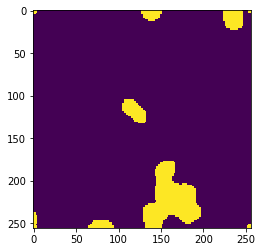

In [22]:
plt.imshow(preds_test_upsampled[4])

In [23]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [24]:
new_test_ids = []
rles = []
for n, id_ in enumerate(files):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [25]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['ImageId'] = sub.ImageId.apply(lambda x: str(x)[21:])
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

In [26]:
sub.head()

ImageId  \
0  0114f484a16c152baa2d82fdd43740880a762c93f436c8...   
1  0114f484a16c152baa2d82fdd43740880a762c93f436c8...   
2  0114f484a16c152baa2d82fdd43740880a762c93f436c8...   
3  0114f484a16c152baa2d82fdd43740880a762c93f436c8...   
4  0114f484a16c152baa2d82fdd43740880a762c93f436c8...   

                                       EncodedPixels  
0                       1 5 257 5 513 5 769 3 1025 3  
1            64257 3 64513 3 64769 5 65025 5 65281 5  
2  43818 16 44074 16 44328 20 44584 20 44838 24 4...  
3  49504 18 49760 18 50014 22 50270 22 50524 26 5...  
4  9098 10 9354 10 9606 16 9862 16 10116 20 10372...